# Parameter Estimation

Users can:
    
    - Set which parameters to estimate
    - Set boundaries of optimization problem
    - Choose algorithm and set algorithm specific parameters
    - Configure report options (which parameters to include, name, append etc.)
    - Map arbitrary number of data files to fit at once
    - Choose between time course or steady state
      

To do:

    - Support for affected experiments section
    - Support for validation experiments



## Imports and Getting Test Model

In [1]:
%matplotlib inline
import site
site.addsitedir('//home/b3053674/Documents/pycotools')
from pycotools import model, tasks, viz, misc
from pycotools.Tests import test_models
import os
import pandas
from lxml import etree


import logging
logging.basicConfig(format = '%(levelname)s:%(message)s')
LOG=logging.getLogger()

## get string model from test_models
zi_model_string = test_models.TestModels().zi_model()

## get a working directory. Change this to change this to wherever you like
directory = r'/home/b3053674/Documents/pycotools/pycotools/Examples'

## choose path to zi model
zi_path = os.path.join(directory, 'zi2012.cps')

##write model to file
with open(zi_path, 'w') as f:
    f.write(zi_model_string)
    
## check file exists
if not os.path.isfile(zi_path):
    raise Exception

zi = model.Model(zi_path)

//home/b3053674/Documents/pycotools/pycotools/viz.py:116: FutureWarning: The pandas.parser module is deprecated and will be removed in a future version. Please import from the pandas.io.parser instead
  from pandas.parser import CParserError


root:INFO:27:    Initializing pycotools
root:INFO:28:    Initializing logging System
root:INFO:29:    logging config file at: //home/b3053674/Documents/pycotools/pycotools/logging_config.conf


## Simulate Synthetic Data for Demonstration

In [2]:
report= 'parameter_estimation_synthetic_data.txt'
TC=tasks.TimeCourse(
    zi, start=0, end=1000, intervals=100, step_size=10, report_name=report
)

## validate that its worked
pandas.read_csv(TC.report_name,sep='\t').head()

Time  [Smad3n]  [Smad3c]  [Smad4n]  [Smad4c]  [T1R_Surf]  [T2R_Cave]  \
0     0   236.450   492.610   551.720  1149.400    0.237000    1.778000   
1    10   213.879   419.285   537.499  1073.290    0.046698    1.261880   
2    20   190.086   331.218   529.637   979.915    0.041292    0.903526   
3    30   181.994   291.099   532.446   936.161    0.034809    0.658106   
4    40   179.937   277.649   534.984   921.180    0.028182    0.492606   

   [T2R_Surf]  [Smads_Complex_n]  [T1R_EE]            ...              \
0    0.202000             0.0000  2.060000            ...               
1    0.013032            79.8621  1.543130            ...               
2    0.012959           252.7810  1.175980            ...               
3    0.013734           356.7320  0.908233            ...               
4    0.015320           396.7640  0.706949            ...               

   Values[Kcd]  Values[kr_Cave]  Values[ki_Cave]  Values[Kexp_Smad4n]  \
0        0.005          0.03742             0.33                  0.5   
1        0.005          0.03742             0.33                  0.5   
2        0.005          0.03742             0.33                  0.5   
3        0.005          0.03742             0.33                  0.5   
4        0.005          0.03742             0.33                  0.5   

   Values[Kdiss_Smads_Complex_n]  Values[Kimp_Smad2c]  \
0                         0.1174                 0.16   
1                         0.1174                 0.16   
2                         0.1174                 0.16   
3                         0.1174                 0.16   
4                         0.1174                 0.16   

   Values[Kimp_Smads_Complex_c]  Values[Kimp_Smad4c]  Values[Kdeg_T2R_EE]  \
0                          0.16                 0.08                0.025   
1                          0.16                 0.08                0.025   
2                          0.16                 0.08                0.025   
3                          0.16                 0.08                0.025   
4                          0.16                 0.08                0.025   

   Values[k_Smads_Complex_c]  
0                   0.000069  
1                   0.000069  
2                   0.000069  
3                   0.000069  
4                   0.000069  

[5 rows x 37 columns]

Give the data a more meaningful name

In [3]:
zi_data_file = TC.report_name

## Parameter Estimation Data Files
Rules to follow:

    - Column headings must match model variables exactly in order to be mapped. 
    - Independant variables can be mapped by appending the suffix `_indep` to the variable.
        - For example, if you vary the concentration of A between 0 and 10ng/mL in an experiment:
        
                Time A_indep  B   C
                t=1   0       -   - 
                t=2   0           -
                t=3  10           -
                t=4  10       -   -
    - Do not use non-asci strings (i.e. greek alpha or beta) in parameter definitions. They are minimally supported but this is unstable. 

Copasi time course output contains additional content in headers (i.e. `Values[specie_x]` instead of just `species_x`). For this demonstration to work the column headers must exactly match model variables. The `misc.correct_copasi_timecourse_headers` function specifically deals with this issue for us.  This occurs inplace (i.e. changes the content of the file) and returns the data as a `pandas.DataFrame`)

In [4]:
misc.correct_copasi_timecourse_headers(zi_data_file)

Time   Smad3n   Smad3c   Smad4n    Smad4c  T1R_Surf  T2R_Cave  T2R_Surf  \
0       0  236.450  492.610  551.720  1149.400  0.237000  1.778000  0.202000   
1      10  213.879  419.285  537.499  1073.290  0.046698  1.261880  0.013032   
2      20  190.086  331.218  529.637   979.915  0.041292  0.903526  0.012959   
3      30  181.994  291.099  532.446   936.161  0.034809  0.658106  0.013734   
4      40  179.937  277.649  534.984   921.180  0.028182  0.492606  0.015320   
5      50  179.712  274.549  536.189   917.603  0.022043  0.384409  0.017793   
6      60  180.350  276.037  536.916   919.062  0.016803  0.318202  0.021237   
7      70  181.553  280.139  537.544   923.355  0.012651  0.283564  0.025638   
8      80  183.149  285.947  538.168   929.488  0.009548  0.273063  0.030828   
9      90  185.019  292.922  538.800   936.875  0.007309  0.280949  0.036535   
10    100  187.070  300.676  539.437   945.100  0.005712  0.302490  0.042480   
11    110  189.226  308.892  540.064   953.825  0.004569  0.333741  0.048442   
12    120  191.416  317.297  540.670   962.759  0.003740  0.371478  0.054268   
13    130  193.583  325.660  541.244   971.653  0.003129  0.413148  0.059860   
14    140  195.679  333.785  541.776   980.299  0.002670  0.456794  0.065165   
15    150  197.666  341.520  542.262   988.535  0.002322  0.500963  0.070155   
16    160  199.517  348.754  542.699   996.240  0.002052  0.544608  0.074821   
17    170  201.215  355.412  543.086  1003.330  0.001842  0.586999  0.079164   
18    180  202.751  361.453  543.426  1009.770  0.001675  0.627655  0.083195   
19    190  204.122  366.865  543.720  1015.550  0.001541  0.666275  0.086927   
20    200  205.334  371.659  543.973  1020.660  0.001432  0.702693  0.090375   
21    210  206.394  375.862  544.188  1025.140  0.001344  0.736842  0.093556   
22    220  207.313  379.515  544.370  1029.040  0.001271  0.768722  0.096489   
23    230  208.104  382.663  544.524  1032.400  0.001211  0.798381  0.099190   
24    240  208.780  385.359  544.652  1035.280  0.001160  0.825899  0.101676   
25    250  209.355  387.652  544.760  1037.730  0.001117  0.851374  0.103962   
26    260  209.840  389.594  544.849  1039.800  0.001081  0.874917  0.106064   
27    270  210.249  391.230  544.923  1041.550  0.001050  0.896645  0.107995   
28    280  210.591  392.603  544.984  1043.020  0.001023  0.916676  0.109770   
29    290  210.877  393.751  545.035  1044.250  0.001000  0.935124  0.111400   
..    ...      ...      ...      ...       ...       ...       ...       ...   
71    710  212.269  399.344  545.274  1050.220  0.000778  1.136670  0.129034   
72    720  212.269  399.345  545.274  1050.220  0.000776  1.137120  0.129073   
73    730  212.269  399.345  545.274  1050.220  0.000775  1.137530  0.129109   
74    740  212.269  399.345  545.274  1050.220  0.000773  1.137910  0.129142   
75    750  212.269  399.345  545.274  1050.220  0.000771  1.138260  0.129172   
76    760  212.269  399.345  545.274  1050.220  0.000770  1.138580  0.129200   
77    770  212.269  399.345  545.274  1050.220  0.000768  1.138870  0.129225   
78    780  212.269  399.345  545.274  1050.220  0.000767  1.139130  0.129248   
79    790  212.269  399.345  545.274  1050.220  0.000765  1.139380  0.129269   
80    800  212.269  399.345  545.274  1050.220  0.000764  1.139600  0.129289   
81    810  212.269  399.345  545.274  1050.220  0.000763  1.139810  0.129307   
82    820  212.269  399.345  545.274  1050.220  0.000761  1.139990  0.129323   
83    830  212.269  399.345  545.274  1050.220  0.000760  1.140170  0.129338   
84    840  212.269  399.345  545.274  1050.220  0.000758  1.140320  0.129351   
85    850  212.269  399.345  545.274  1050.220  0.000757  1.140470  0.129364   
86    860  212.269  399.344  545.274  1050.220  0.000755  1.140600  0.129375   
87    870  212.269  399.344  545.274  1050.220  0.000754  1.140720  0.129386   
88    880  212.269  399.344  545.274  1050.220  0.000753  1.140830  0.129395   
89   

# Setup and run single parameter estimation 

Method outline:

    1) Instantiate ParameterEstimation instance with model and data filenames
        - Ensure optional arguments are specified to the ParameterEstimation class
    2) Use `write_config_template()` method to write and configure a parameter estimation config file.
    2) Use `setup()` method
    3) Use `run()` method
    4) Use `format_results()` method (to give output results meaningful headers)

## Use HookeJeeves algorithm

In [5]:
PE=tasks.ParameterEstimation(zi, zi_data_file, method='hooke_jeeves')

## Use particle swarm algorithm

In [6]:
PE=tasks.ParameterEstimation(zi, zi_data_file, method='particle_swarm')

## Use genetic algorithm

In [7]:
## Set getetic algorithm parameters to low for speed of demonstration
PE=tasks.ParameterEstimation(zi, zi_data_file, method='genetic_algorithm', 
                             population_size=15, number_of_generations=10)

## Write and configure item template

In [8]:
PE.write_config_file()
os.path.isfile(PE.config_filename)

True

### Configure manually
Now you can go to where the file was saved and modify it how you like.

    - Delete rows with parameters you want not to be included in estimation
    - Change starting values, lower bounds and upper bounds
        - If you set start values, remember to set the randomize_start_values variable to False as it defaults to True

This is a useful way of running parameter estimations as it provides a record of how you've configured parameter estimations. 

### Configure with API
The `metabolites`, `global_parameters` and `local_parameters` arguments tell Pycotools which parameters to include in the config file. By default all model parameters are included but these can be overridden by giving our own lists. 

For example, here we set `metabolites` and `globl_quantities` to empty lists to specify that we do not want to include them in the estimation process. We can also use the `upper_bound` and `lower_bound` arguments to constrain the estimation problem. An argument can also be given to `start_value` but parameter estimation is usually better performed multiple times with randomized start values (or with latin hypercube sampling but this is not supported here).

In [9]:
config_file = os.path.join(os.path.dirname(zi_path), 'Zi2002PEConfig.csv')
PE = tasks.ParameterEstimation(
    zi, zi_data_file, method='genetic_algorithm', population_size=15,
    number_of_generations=10, metabolites=[], local_parameters=[],
    lower_bound = 0.001, upper_bound = 3000, config_filename = config_file)

Here we've defined a config file with only kinetic parameters estimated between the boundaries of 0.1 and 100. 

In [10]:
if os.path.isfile(PE.config_filename):
    os.remove(PE.config_filename)
    
PE.write_config_file()

## check that the config filename exists
print (os.path.isfile(PE.config_filename))
PE.config_filename

True


'/home/b3053674/Documents/pycotools/pycotools/Examples/Zi2002PEConfig.csv'

## Setup and run parameter estimation

In [11]:
PE.setup()

Model(name=Zi2007_TGFbeta_signaling, time_unit=min, volume_unit=l, quantity_unit=nmol)

It can sometime be helpful to open the GUI and manually check that you've set all the options currectly. Run the next cell to open the model:

In [12]:
zi.open()

## Run with CopasiSE

In [13]:
PE.run() # will take some time depending on arguments to ParameterEstimation

# Visualization 
## Plot all estimated parameters

/home/b3053674/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


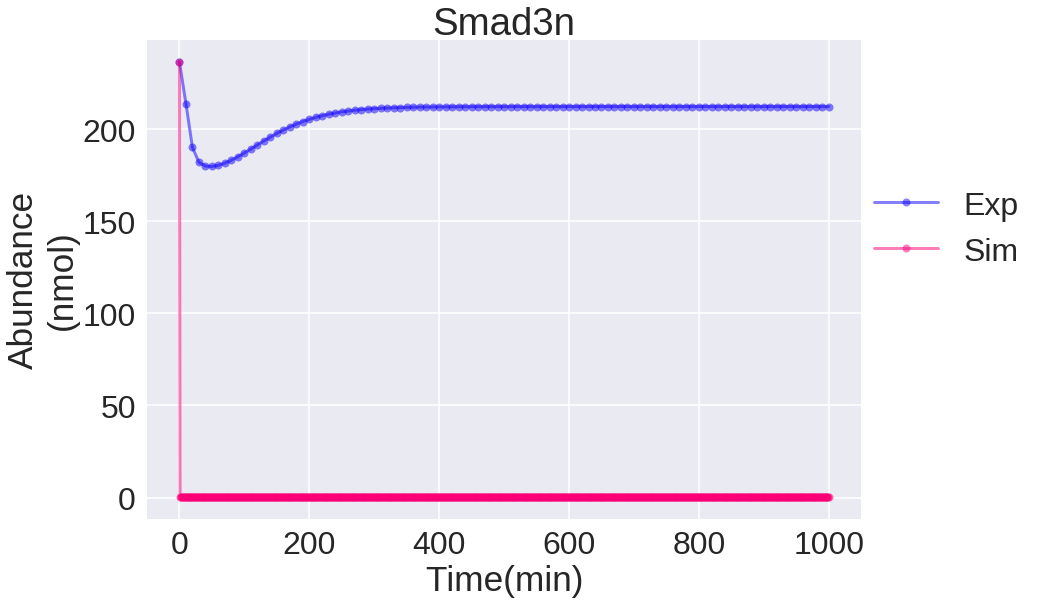

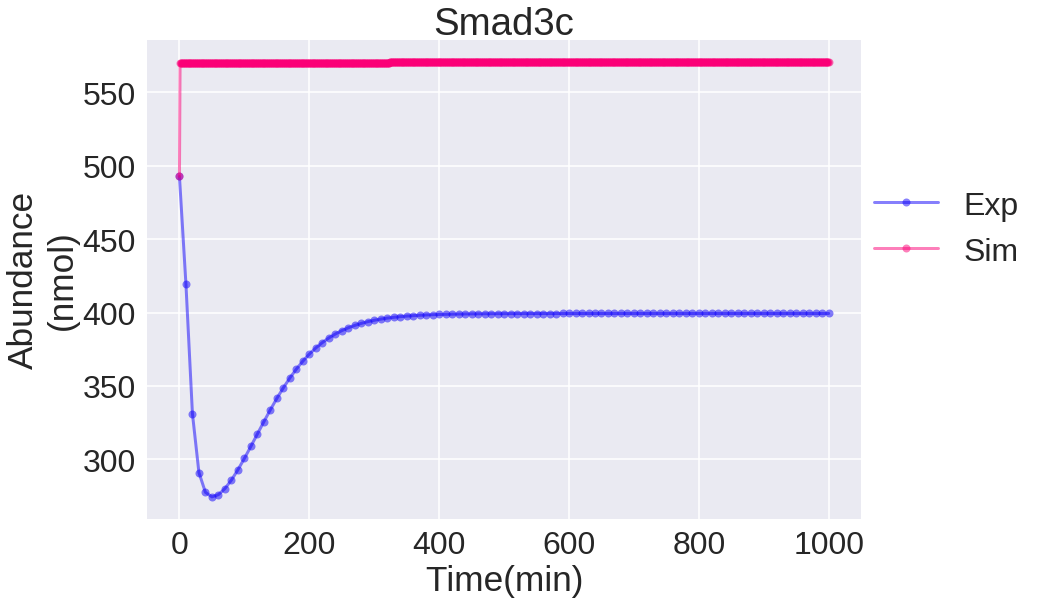

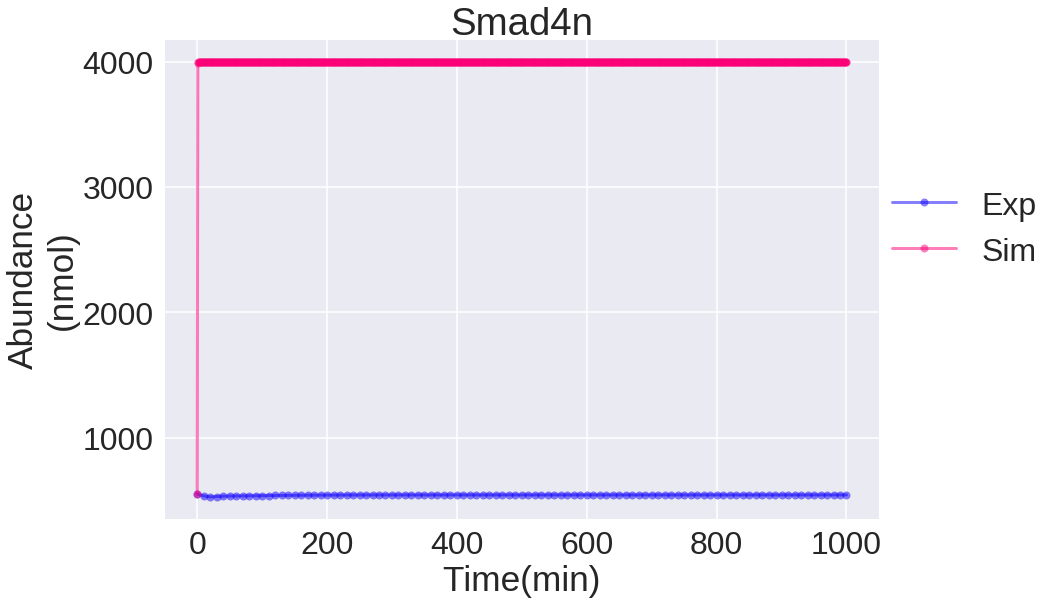

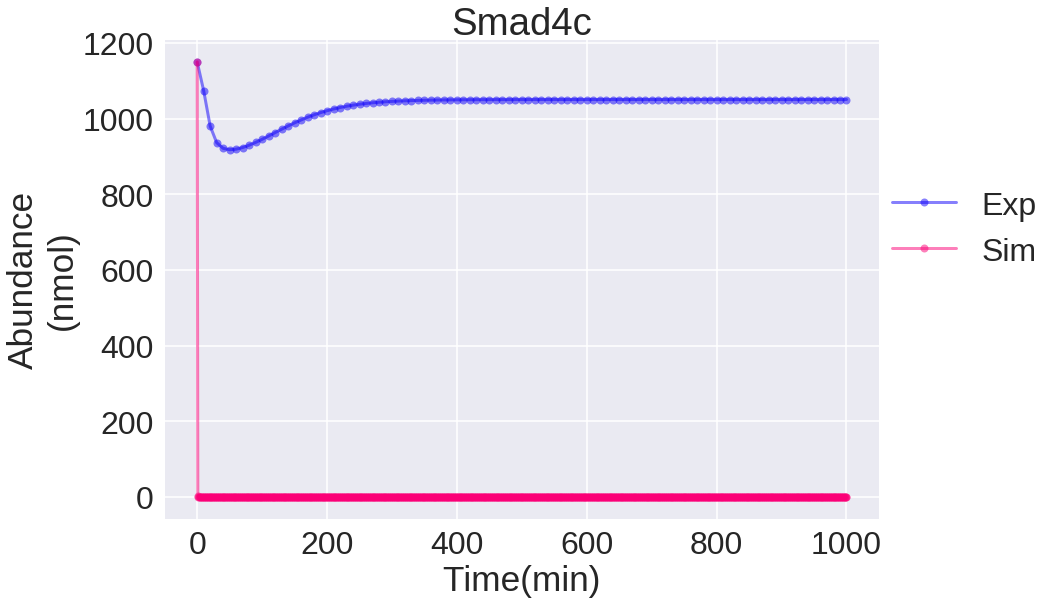

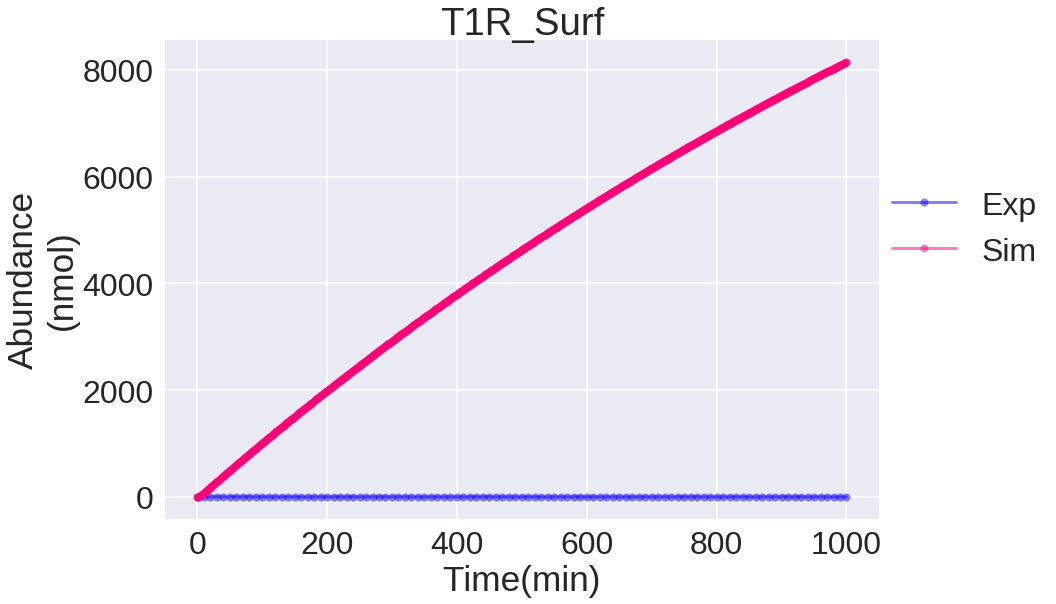

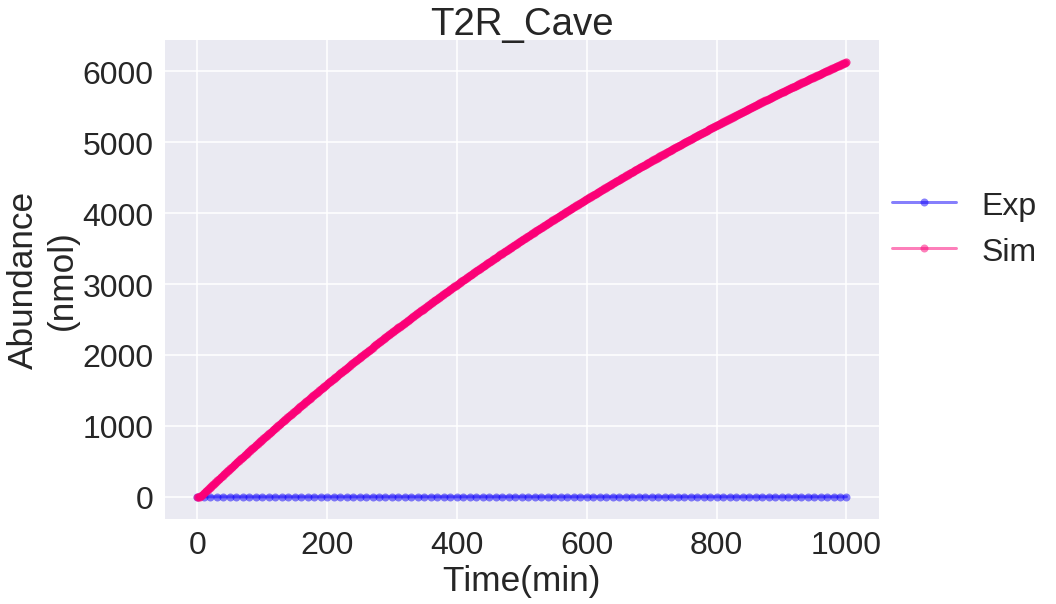

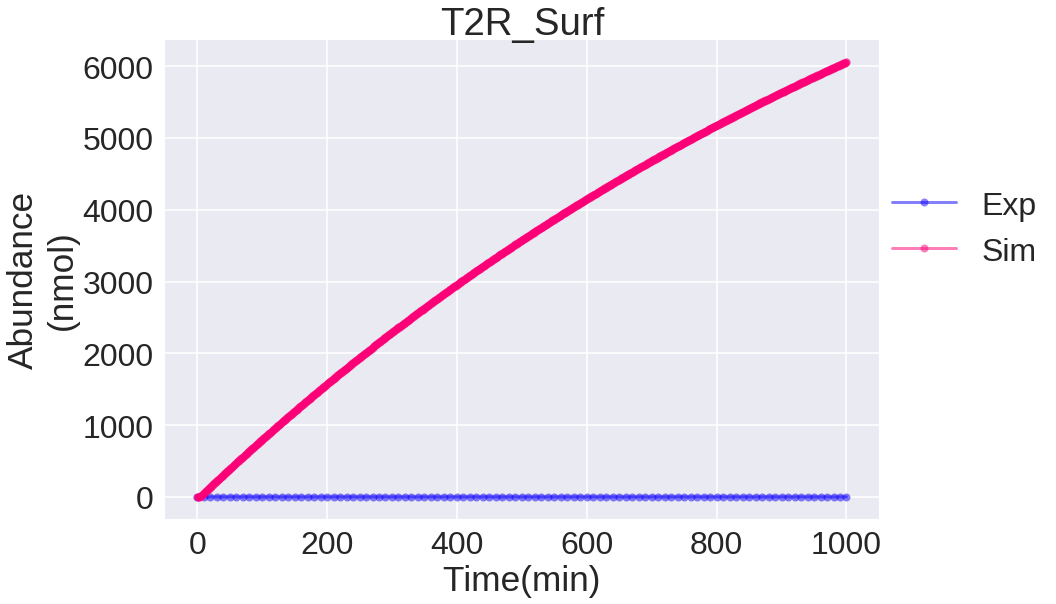

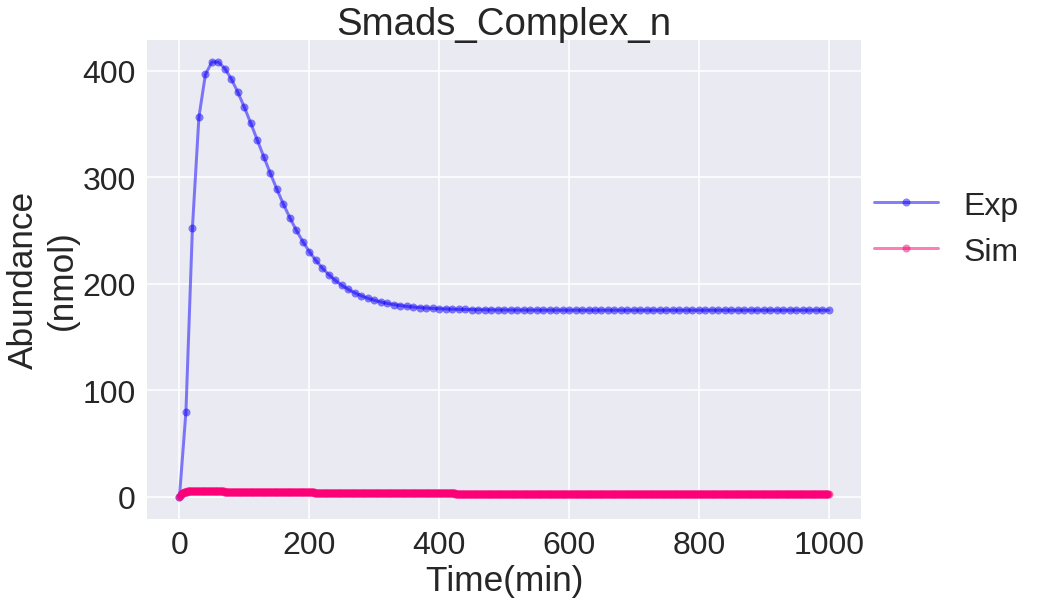

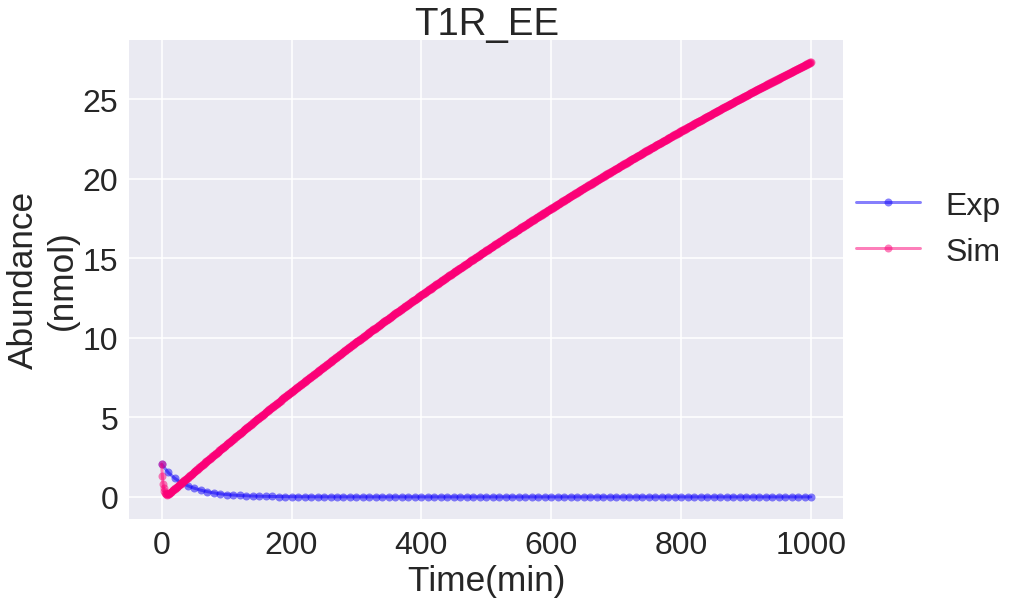

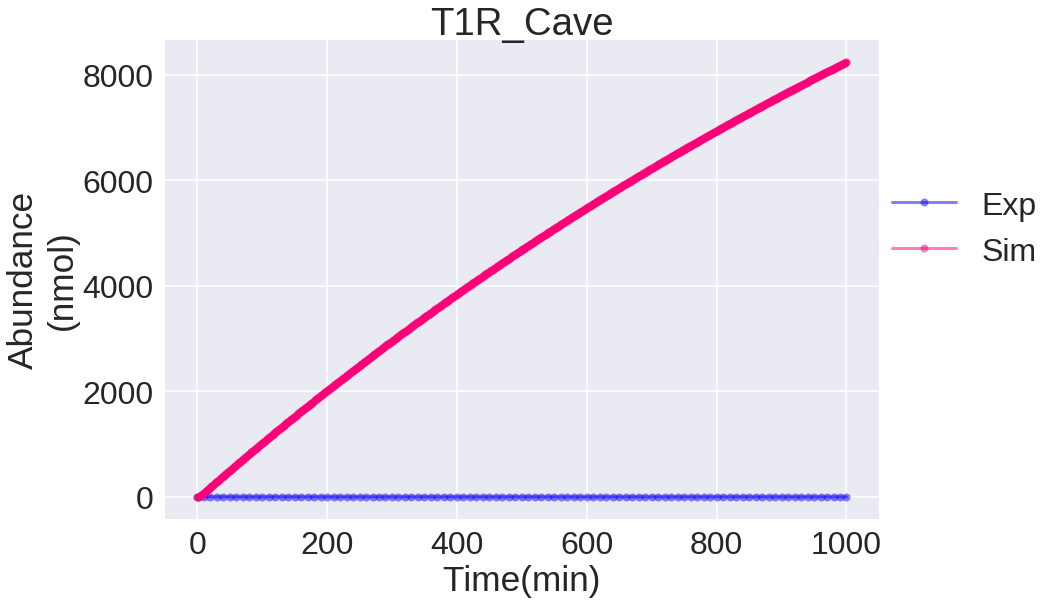

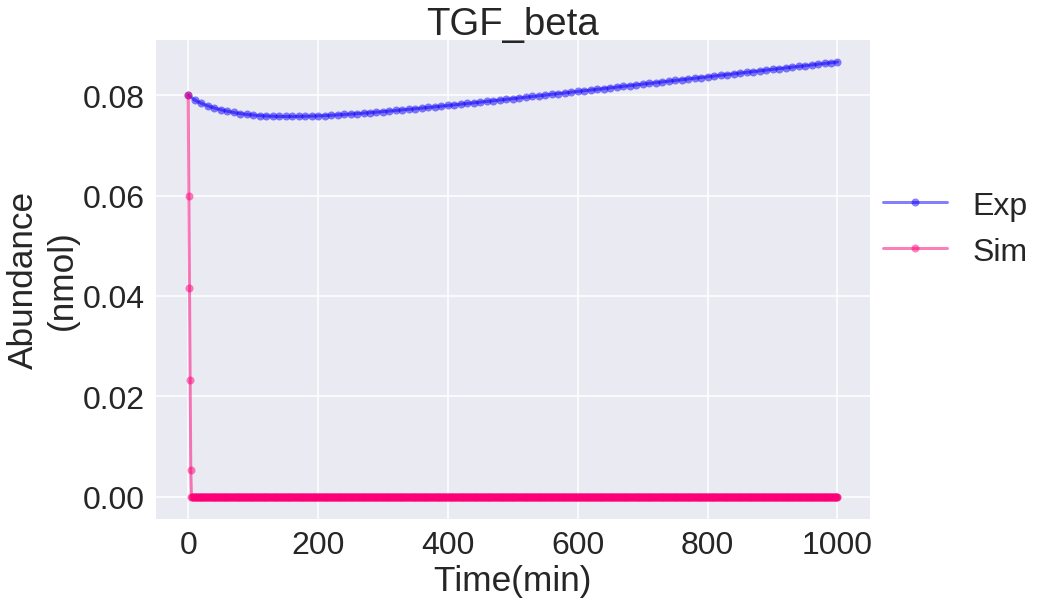

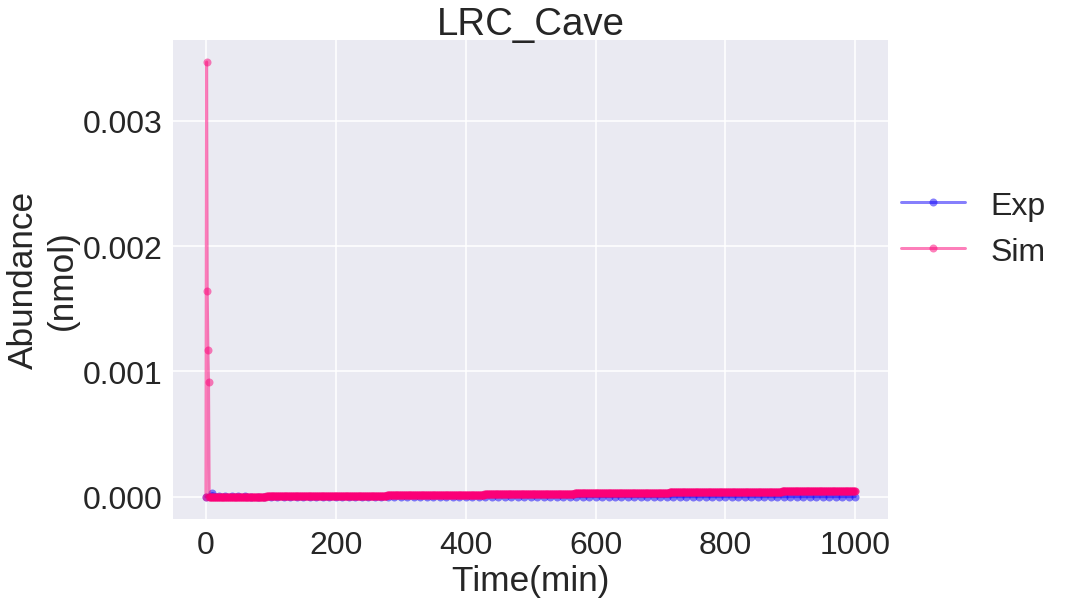

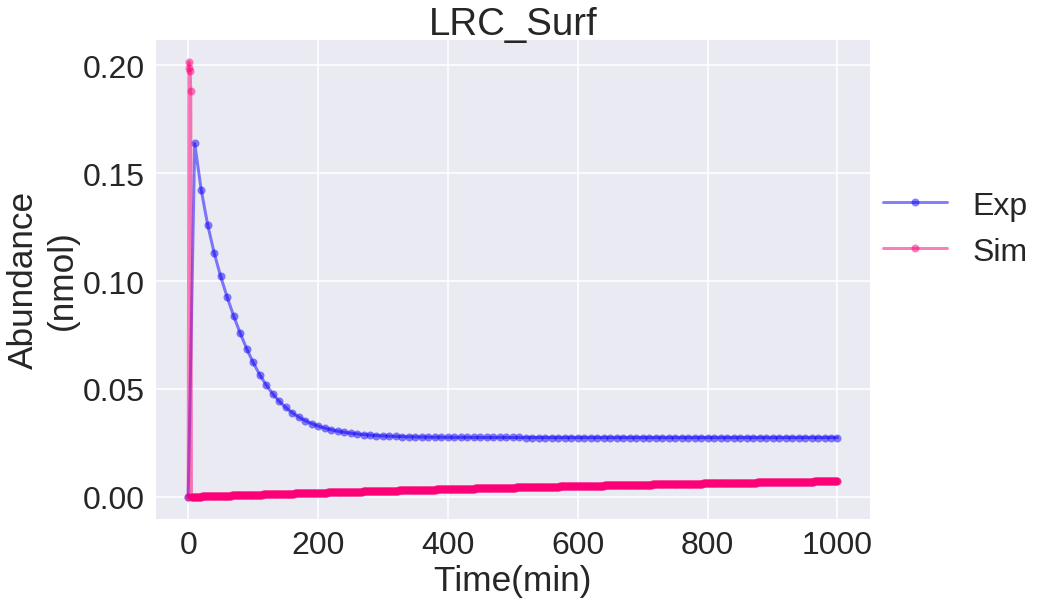

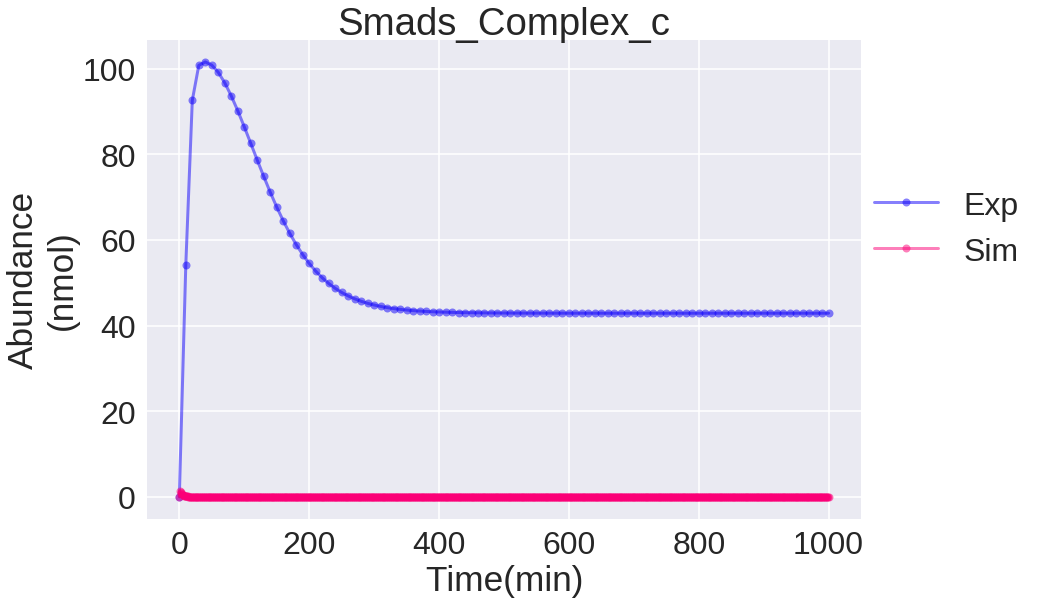

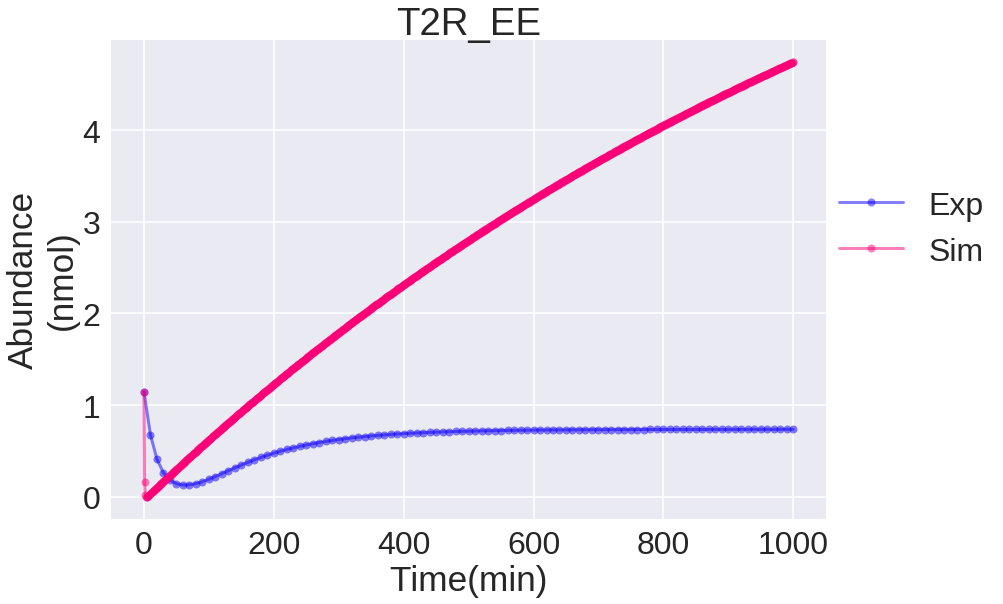

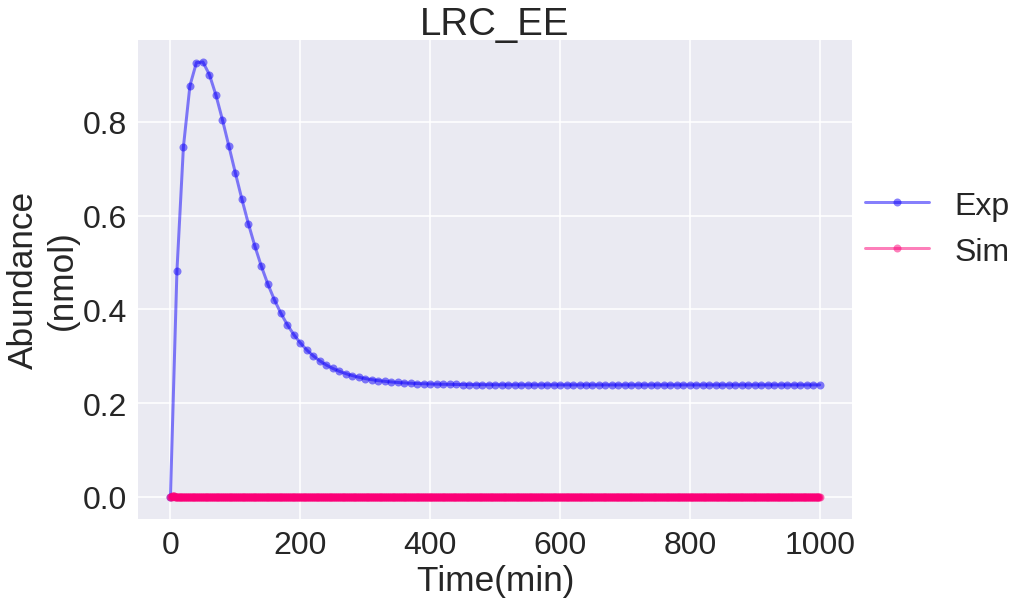

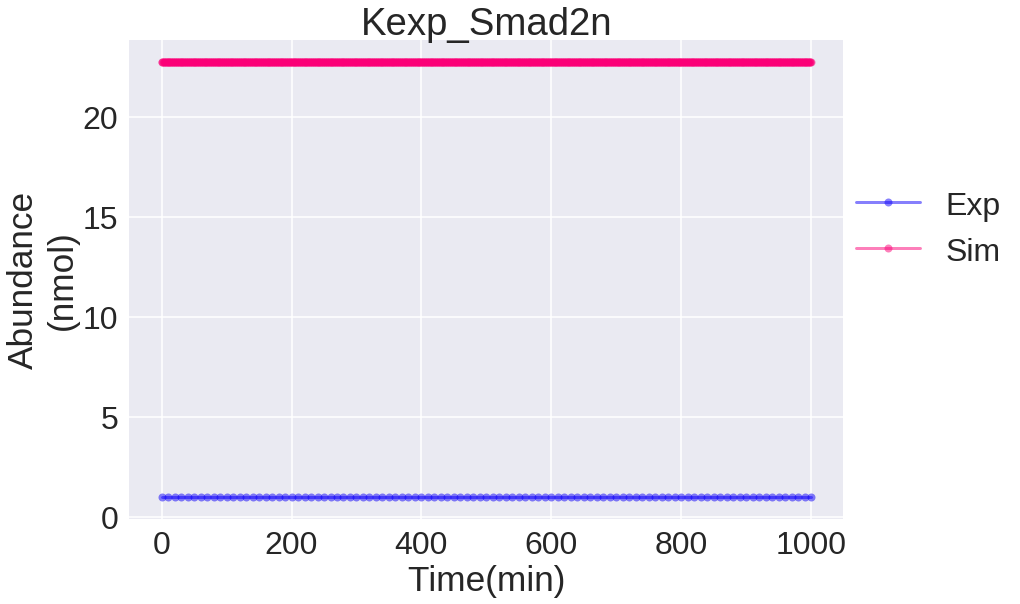

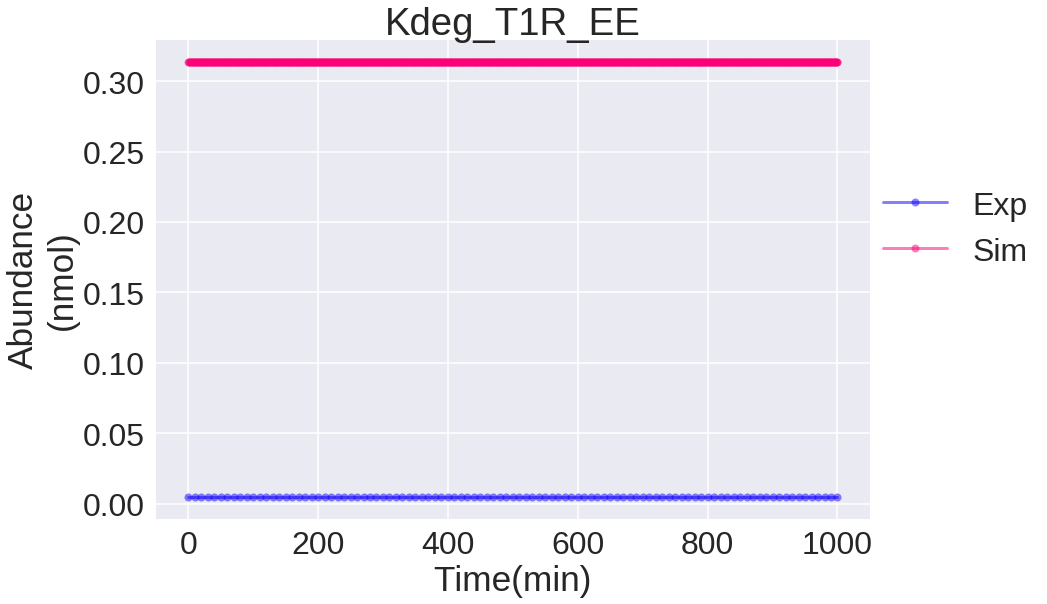

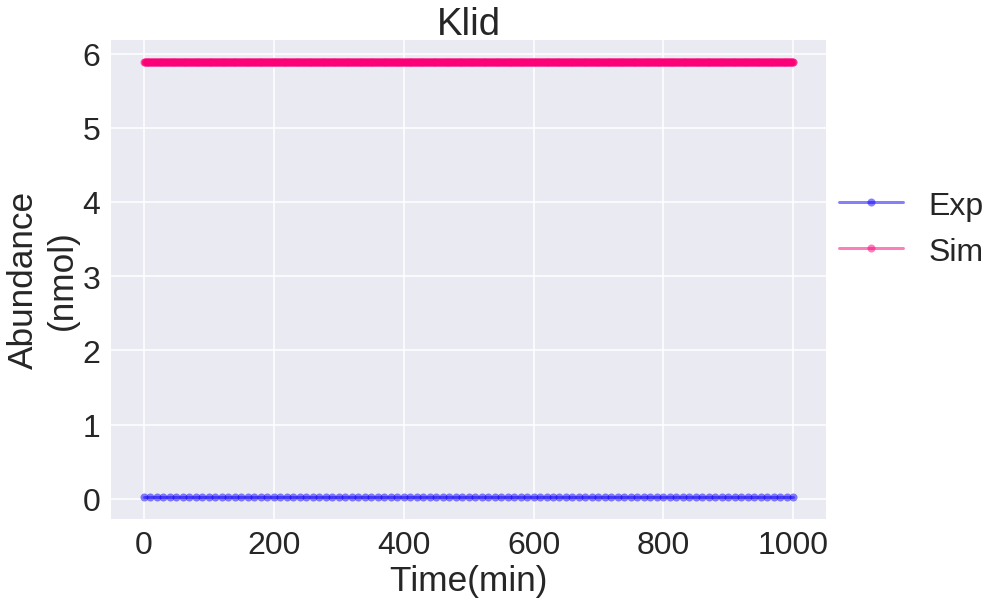

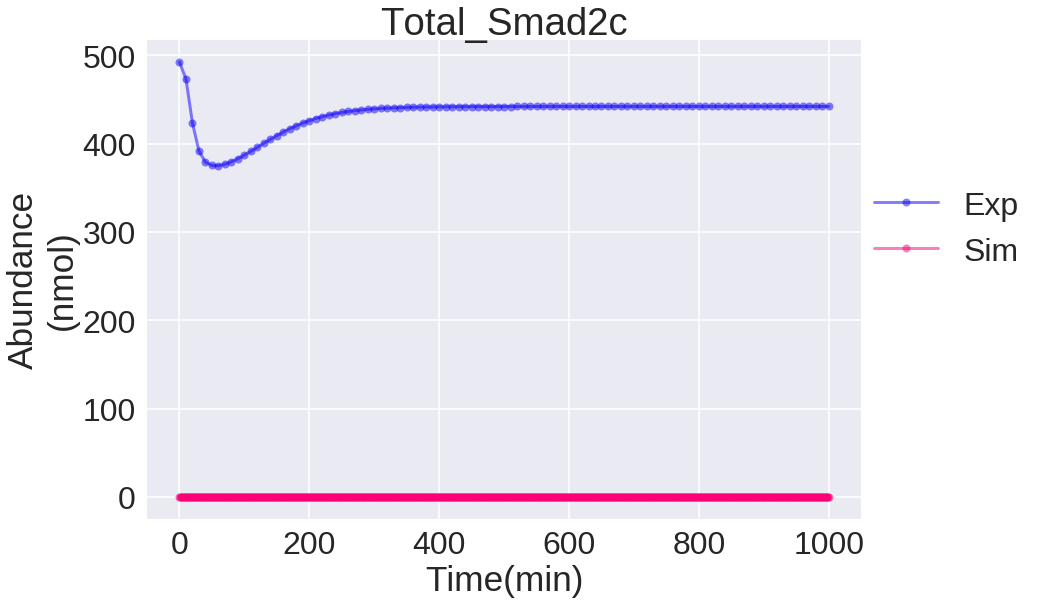

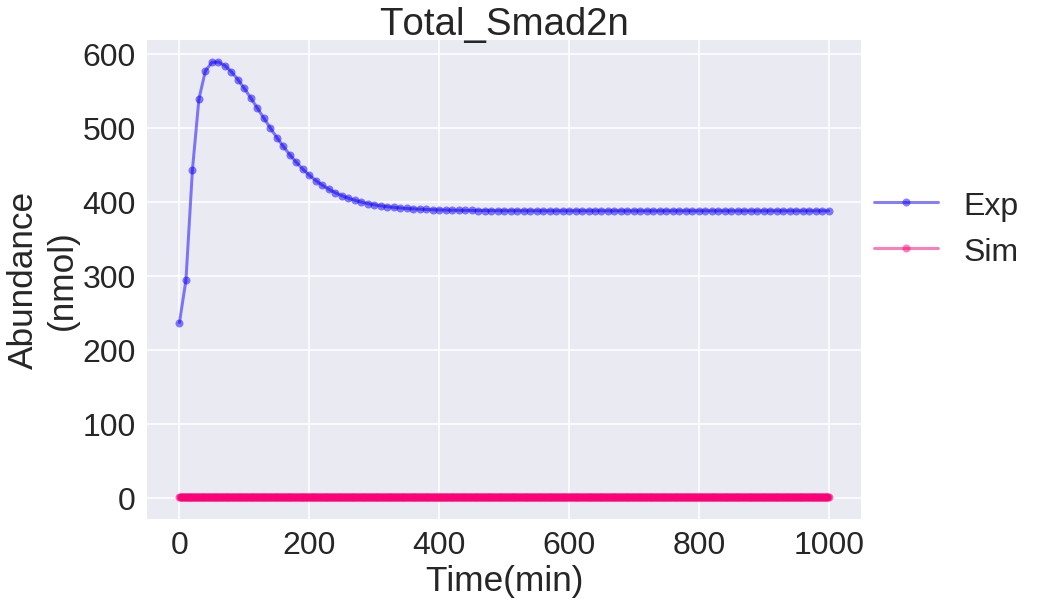

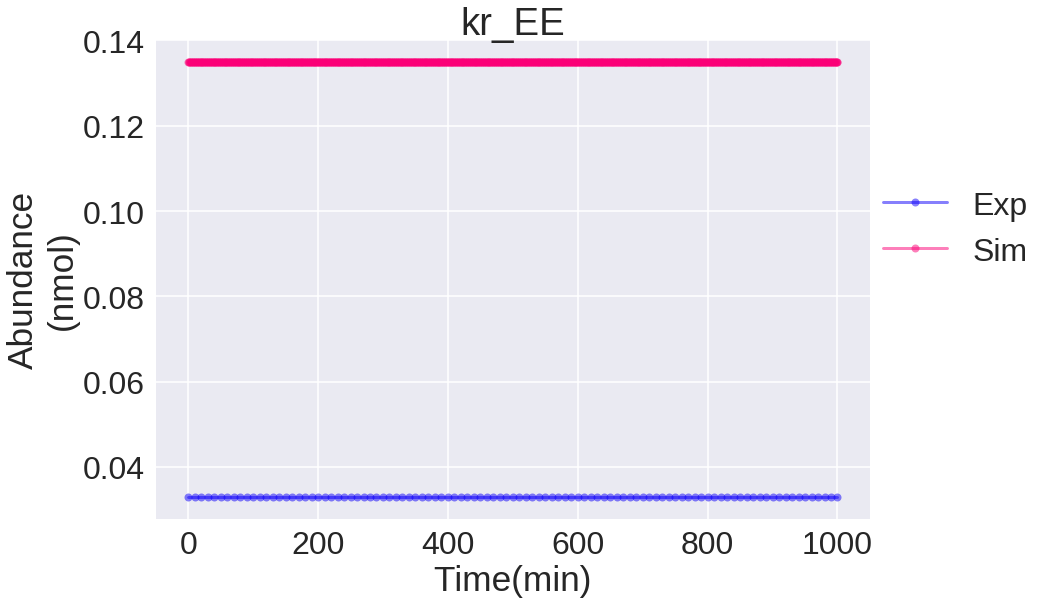

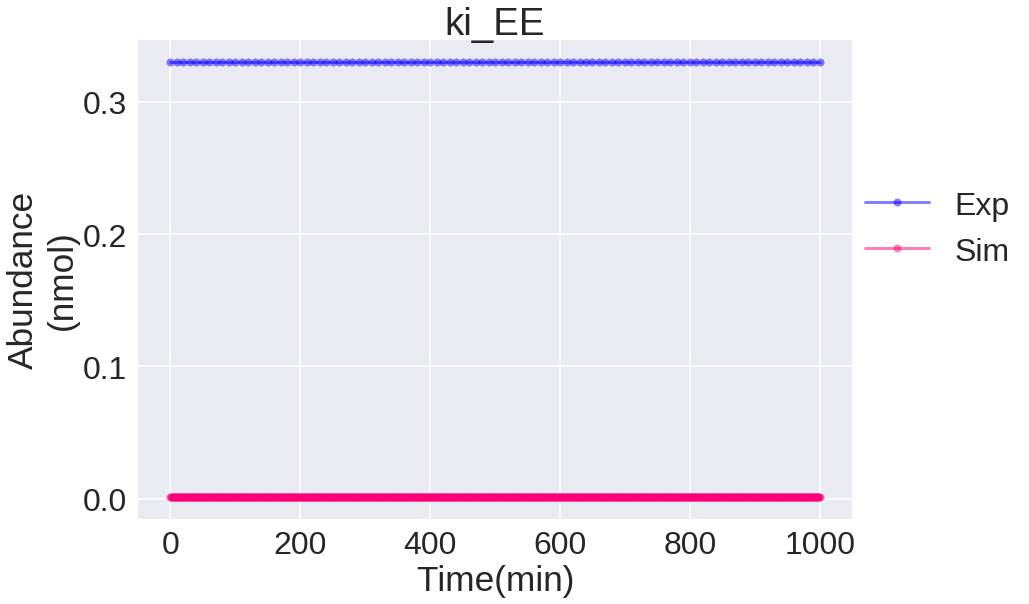

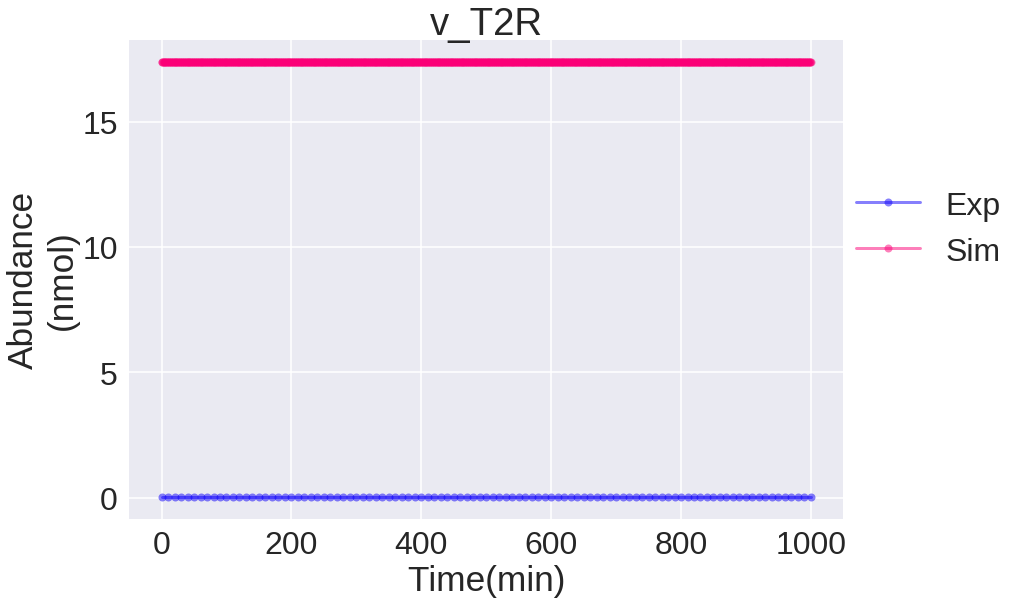

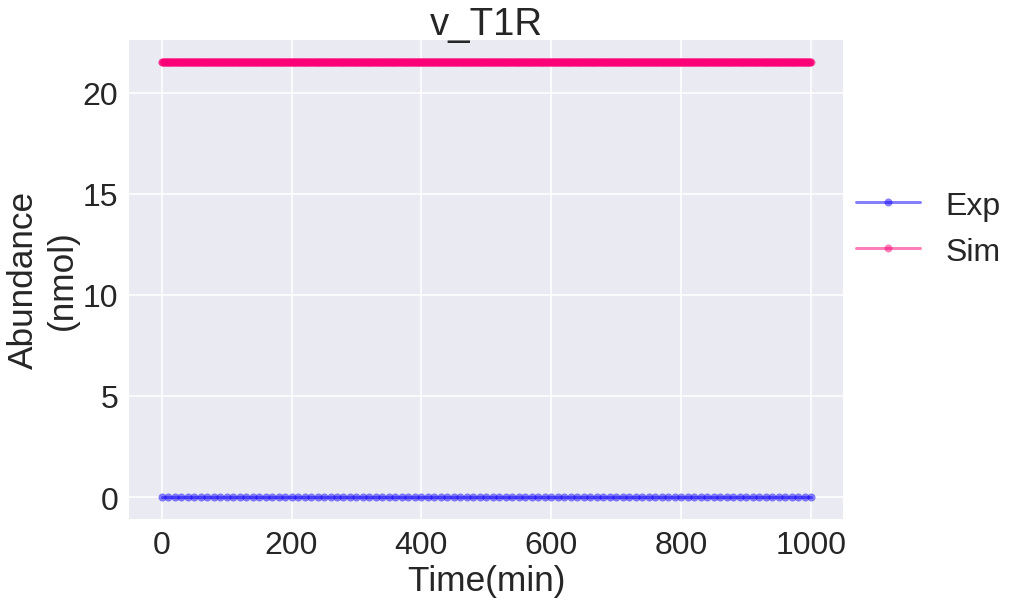

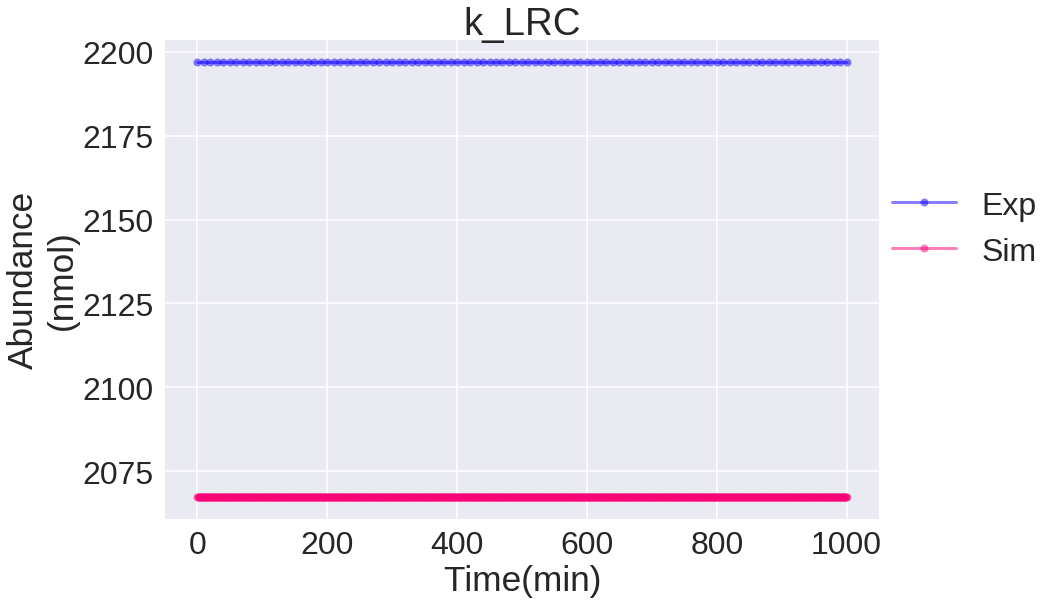

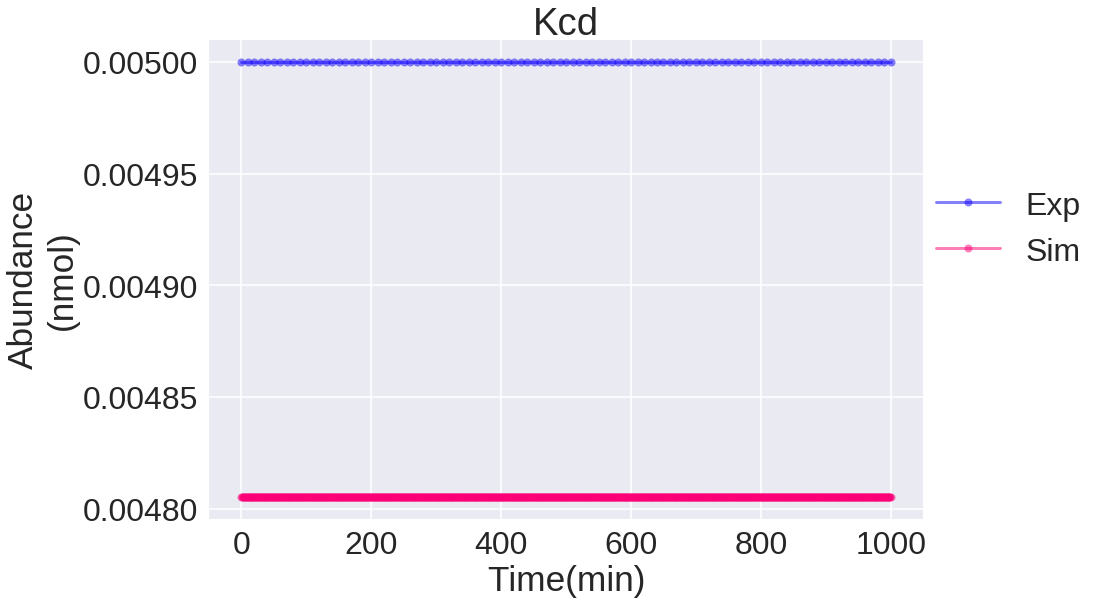

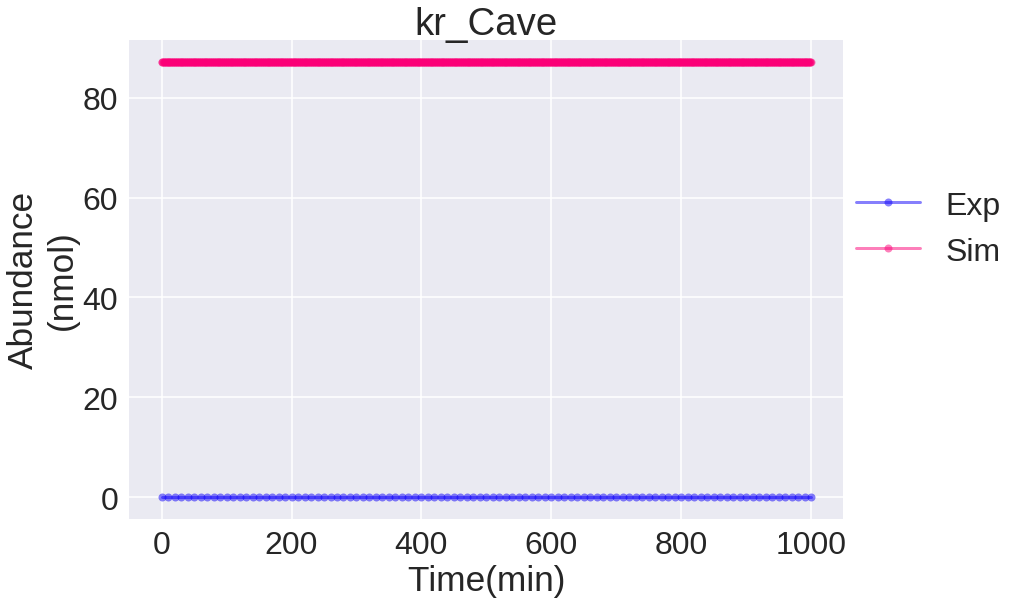

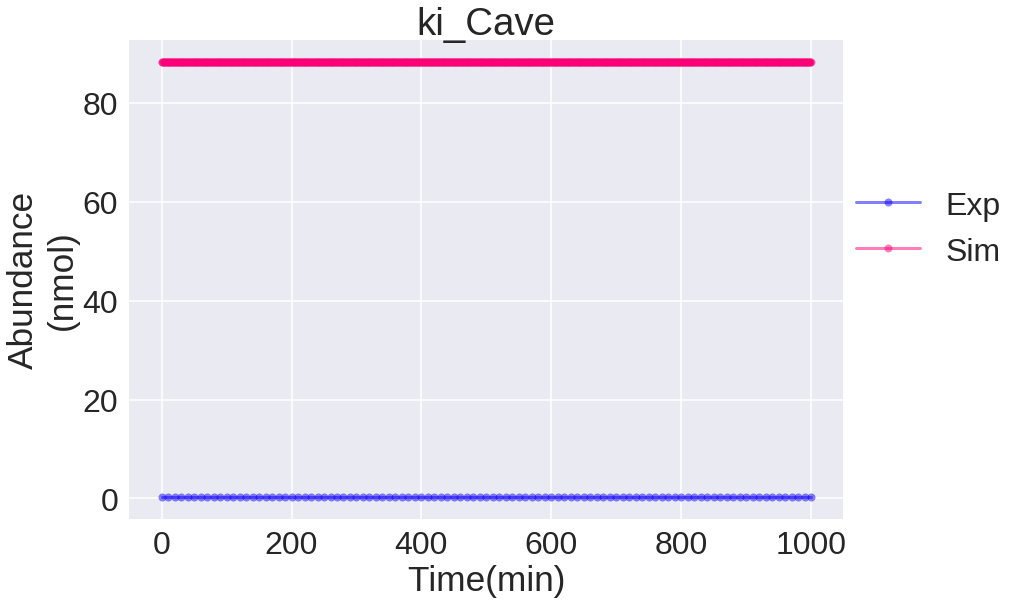

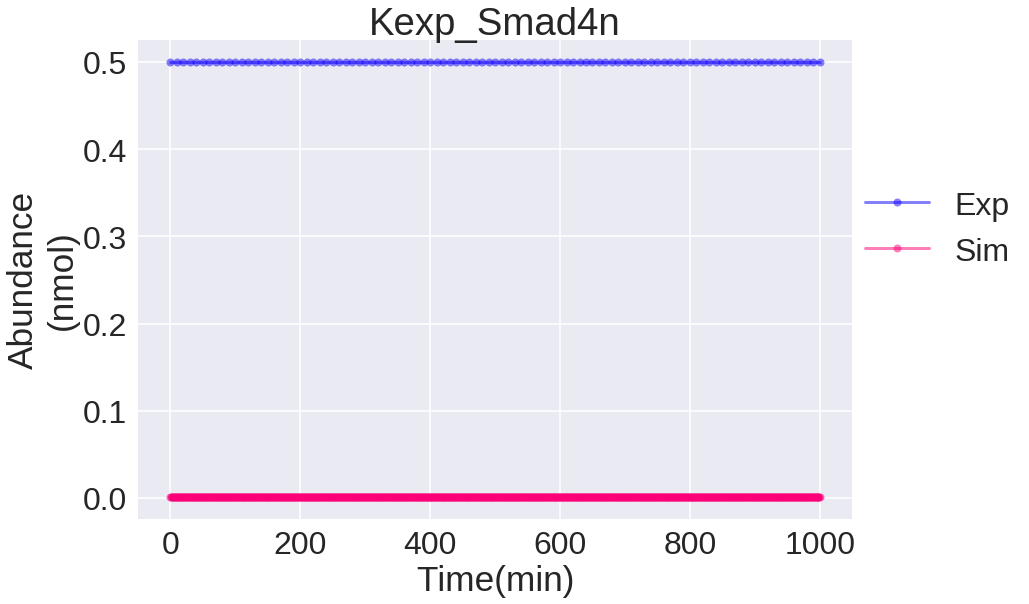

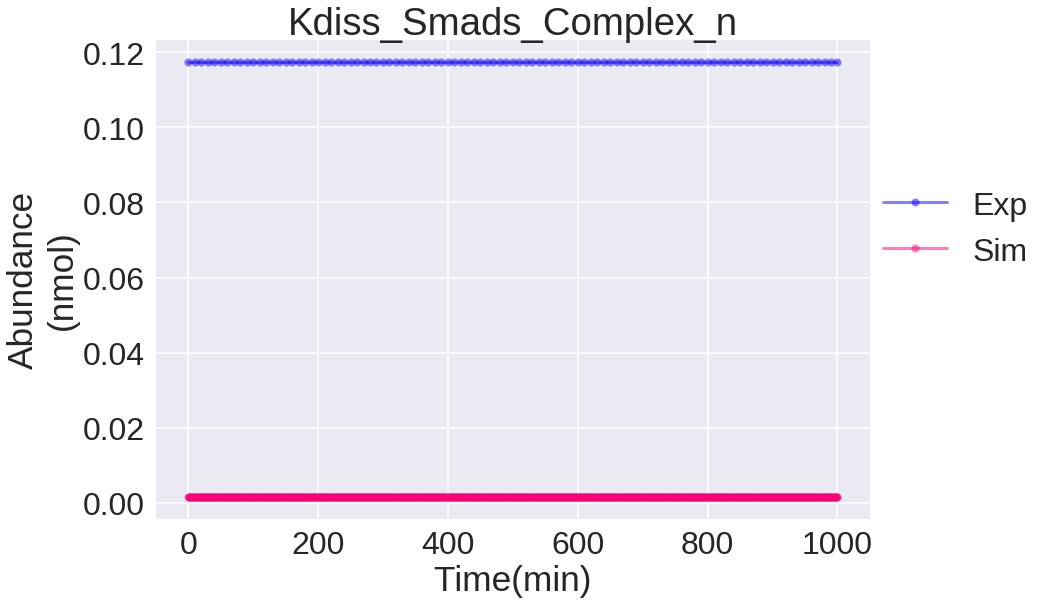

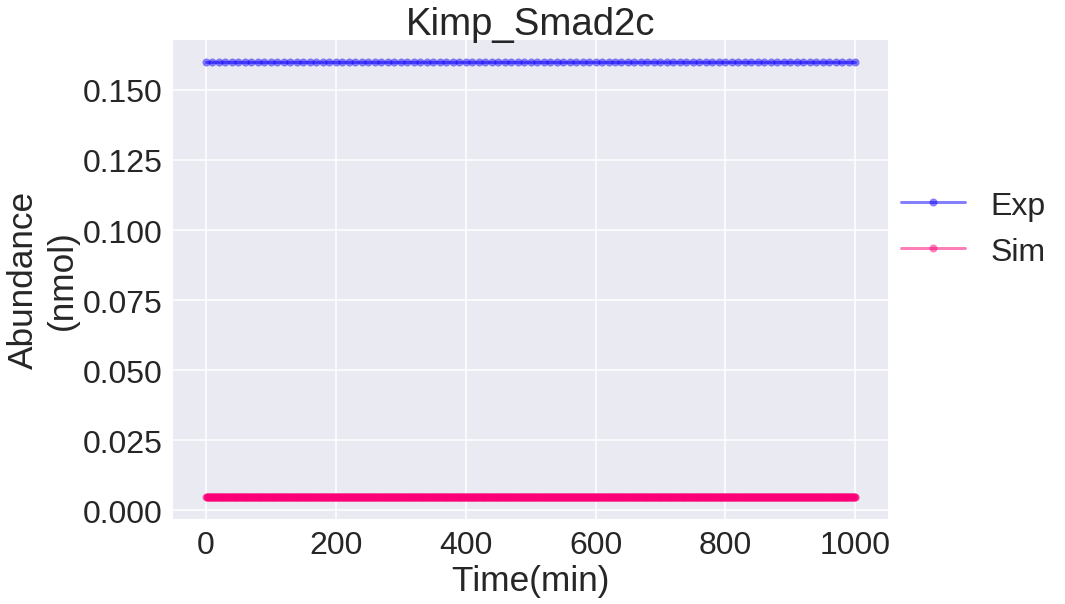

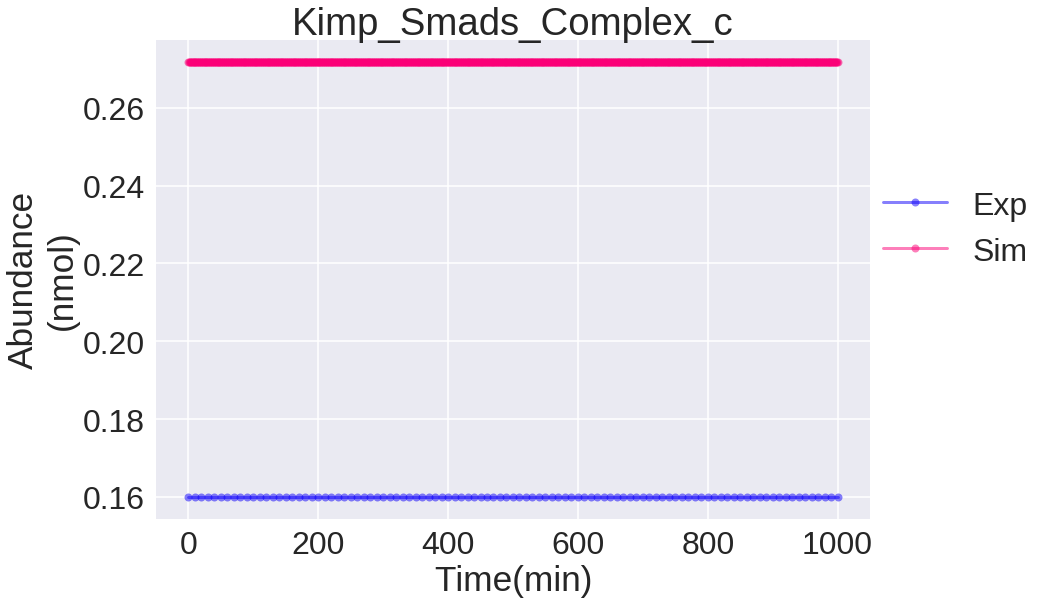

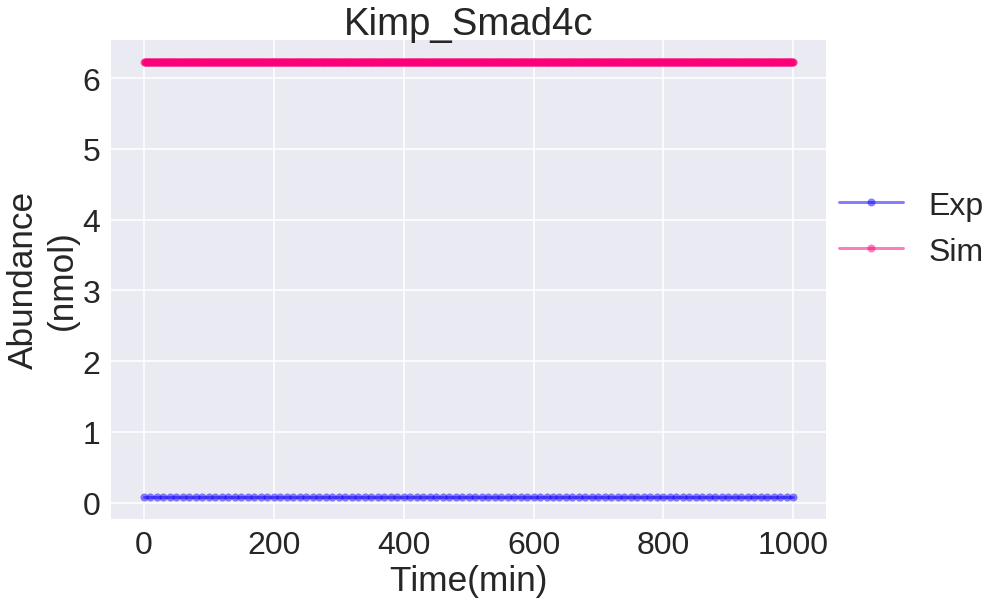

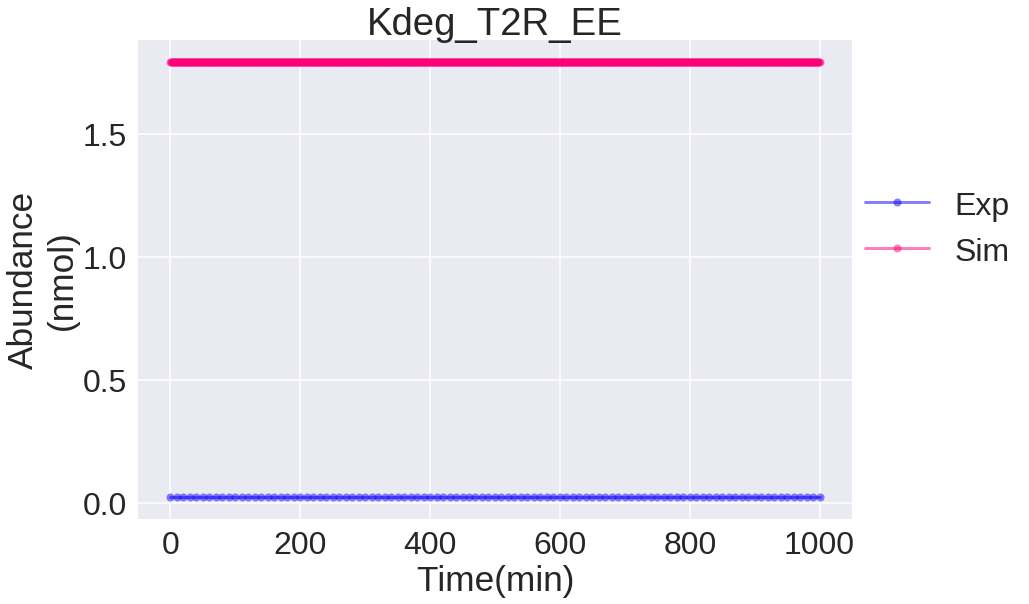

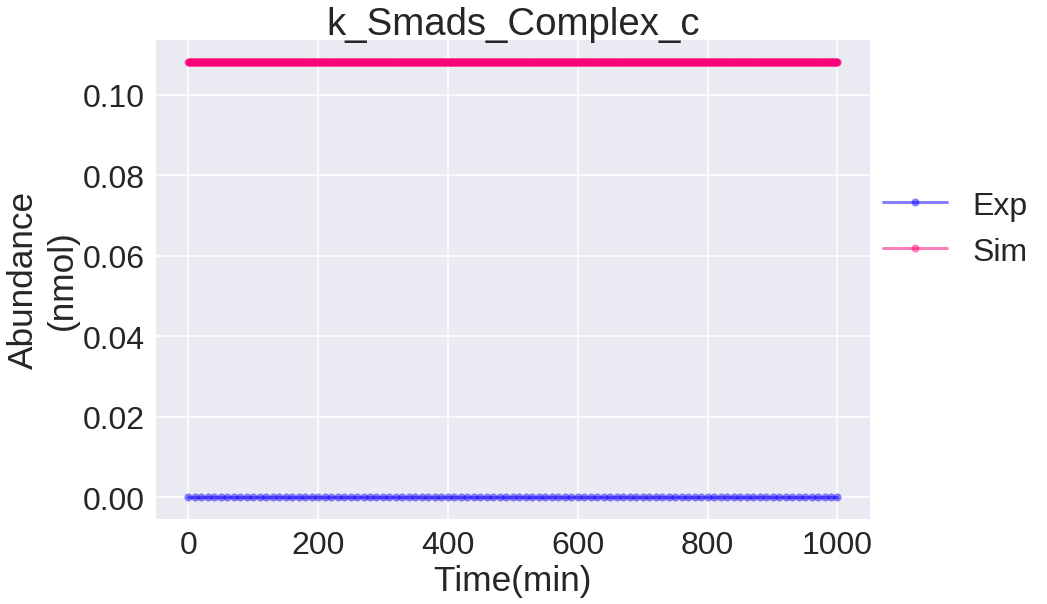

In [14]:
viz.PlotParameterEstimation(PE)

## Save to file (default options)

pycotools.viz:INFO:1559:    figure saved to "/home/b3053674/Documents/pycotools/pycotools/Examples/ParameterEstimationPlots/parameter_estimation_synthetic_data/Smad3n.png"
pycotools.viz:INFO:1559:    figure saved to "/home/b3053674/Documents/pycotools/pycotools/Examples/ParameterEstimationPlots/parameter_estimation_synthetic_data/Smad3c.png"
pycotools.viz:INFO:1559:    figure saved to "/home/b3053674/Documents/pycotools/pycotools/Examples/ParameterEstimationPlots/parameter_estimation_synthetic_data/Smad4n.png"
pycotools.viz:INFO:1559:    figure saved to "/home/b3053674/Documents/pycotools/pycotools/Examples/ParameterEstimationPlots/parameter_estimation_synthetic_data/Smad4c.png"
pycotools.viz:INFO:1559:    figure saved to "/home/b3053674/Documents/pycotools/pycotools/Examples/ParameterEstimationPlots/parameter_estimation_synthetic_data/T1R_Surf.png"
pycotools.viz:INFO:1559:    figure saved to "/home/b3053674/Documents/pycotools/pycotools/Examples/ParameterEstimationPlots/parameter_esti

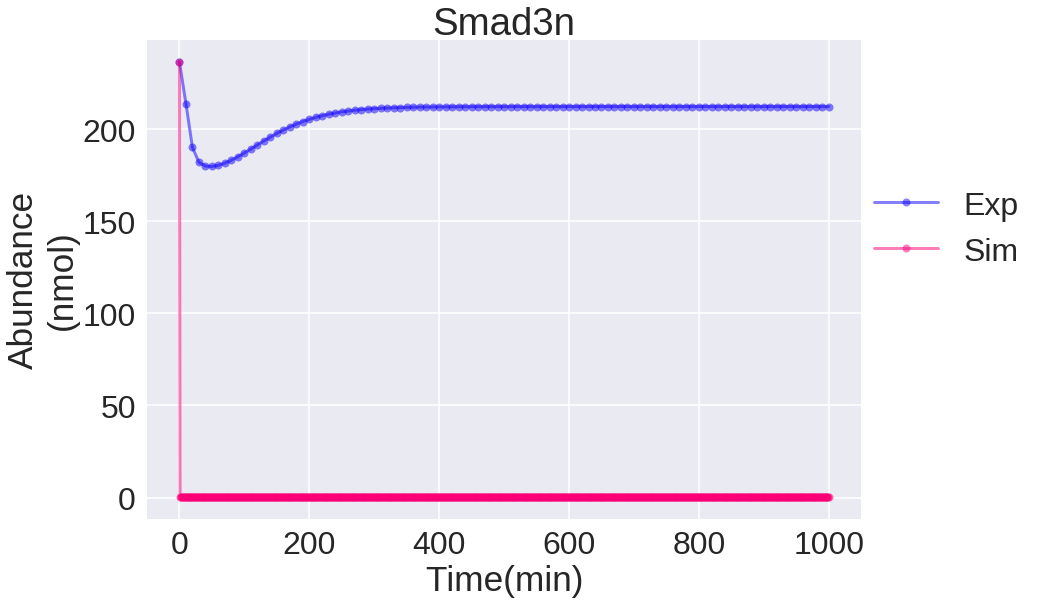

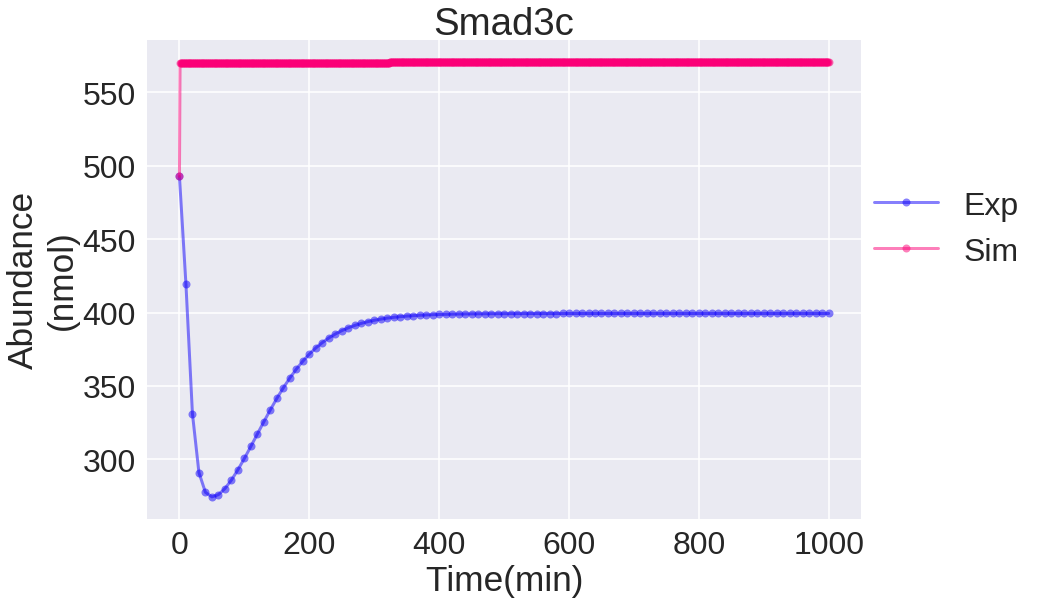

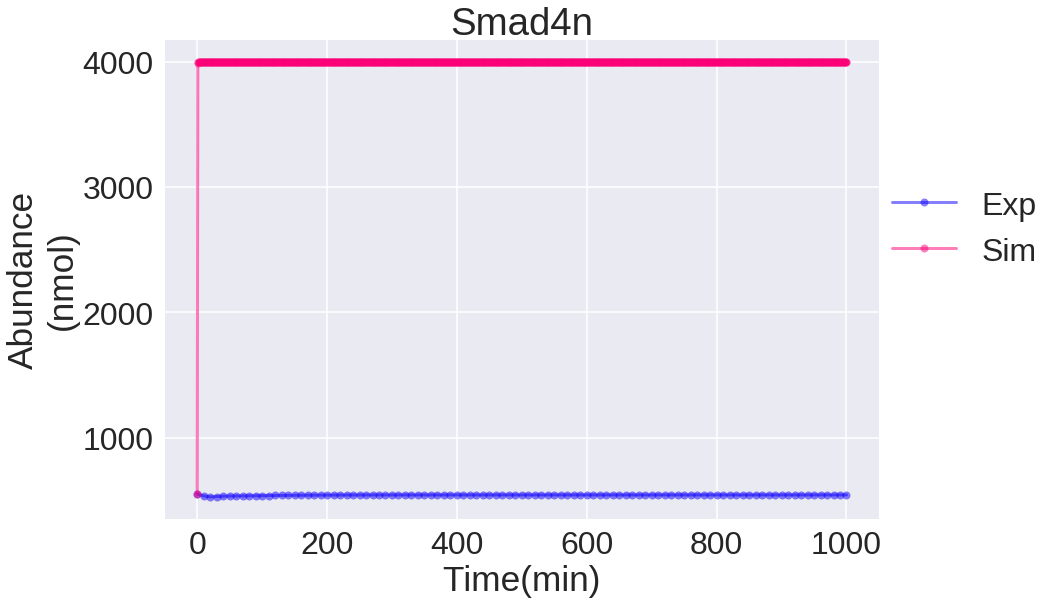

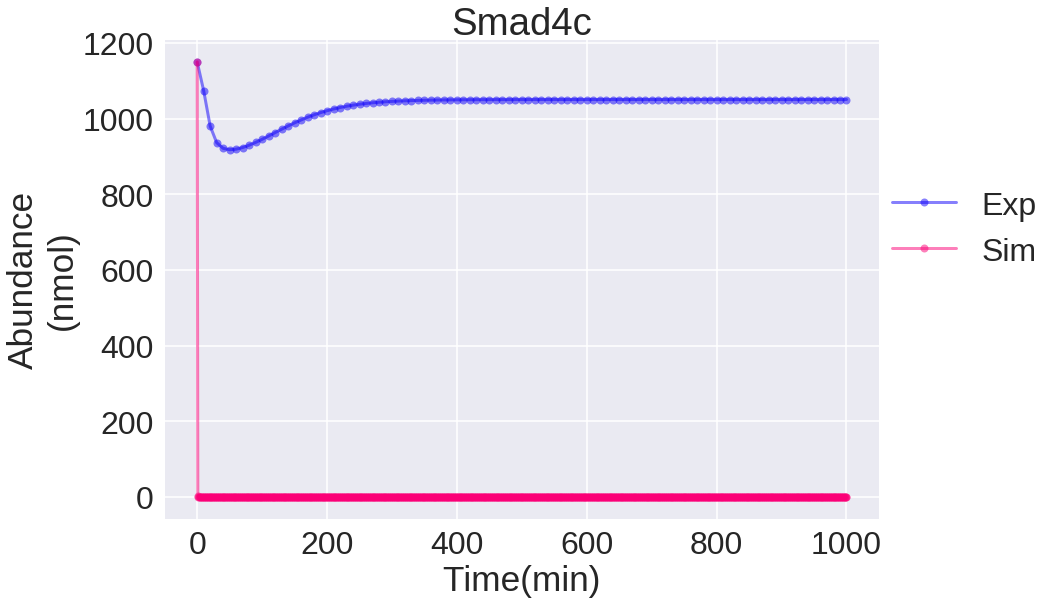

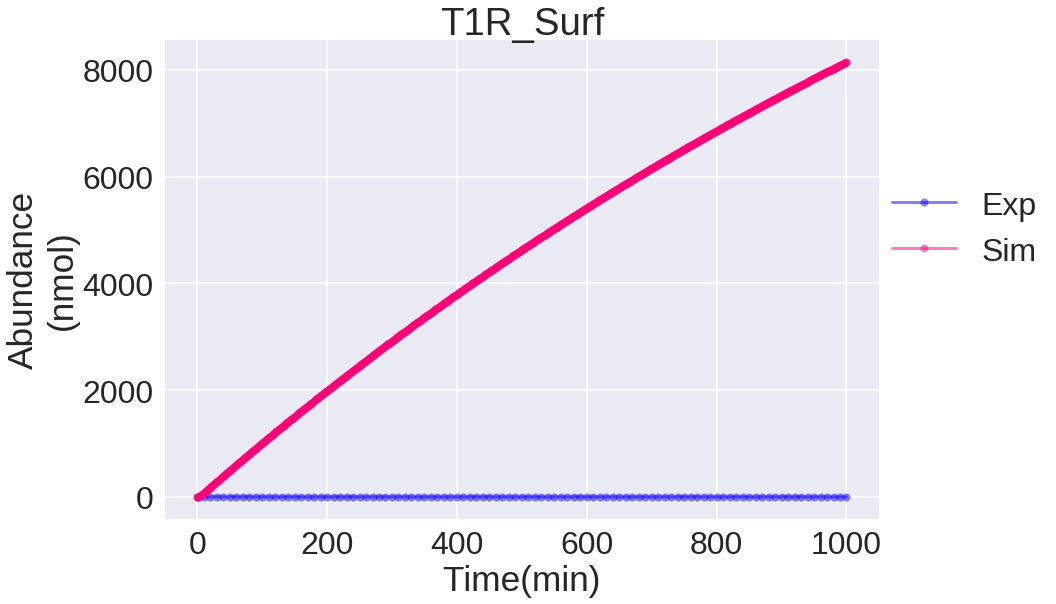

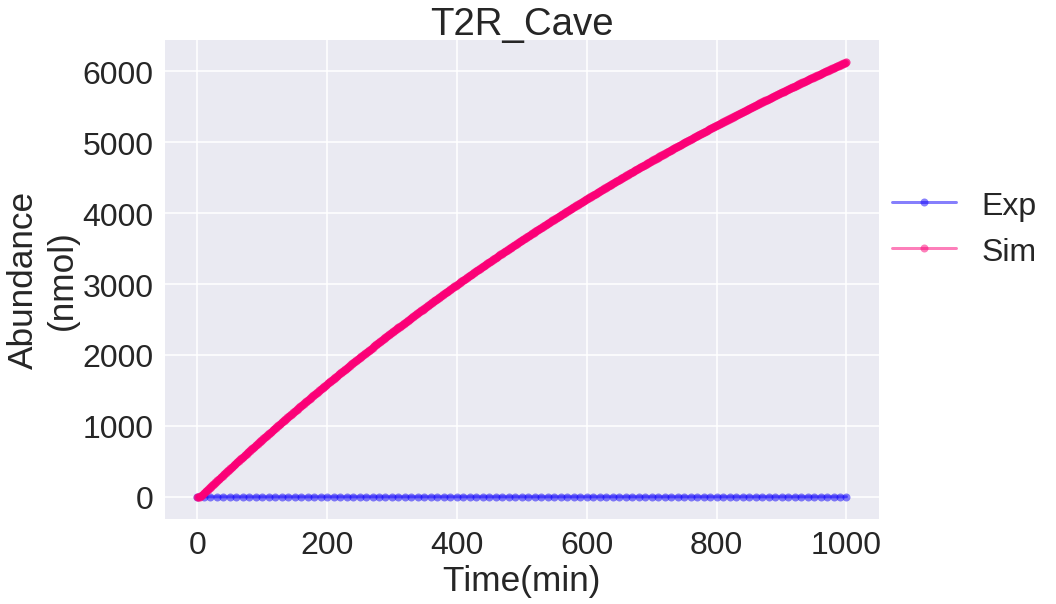

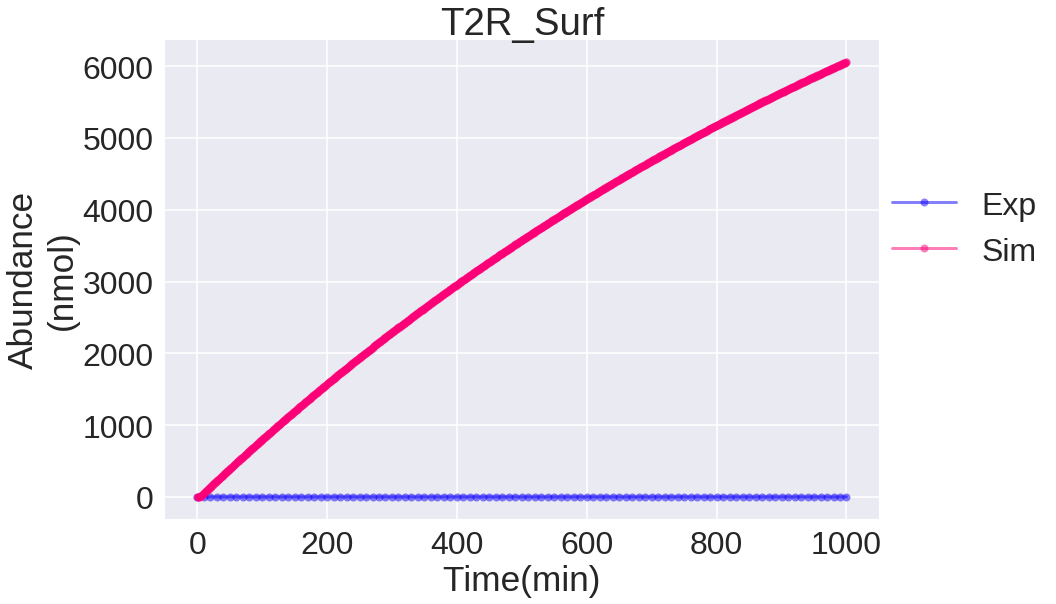

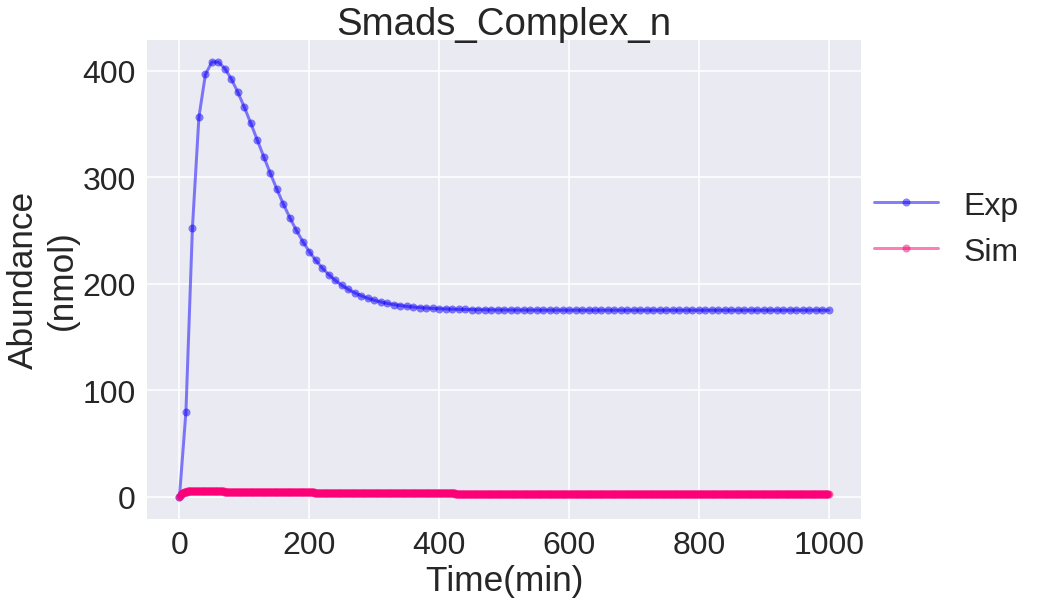

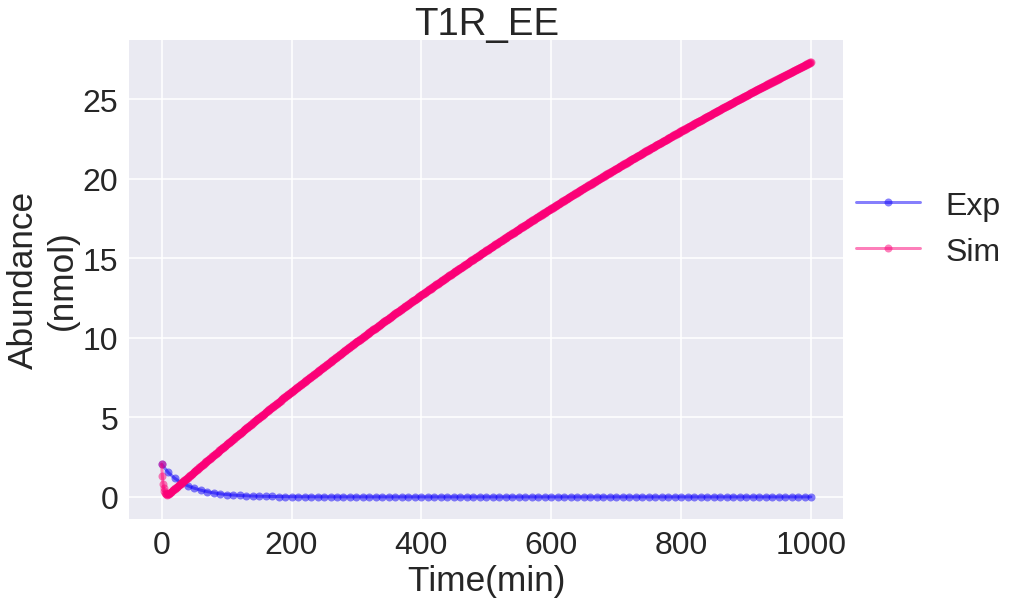

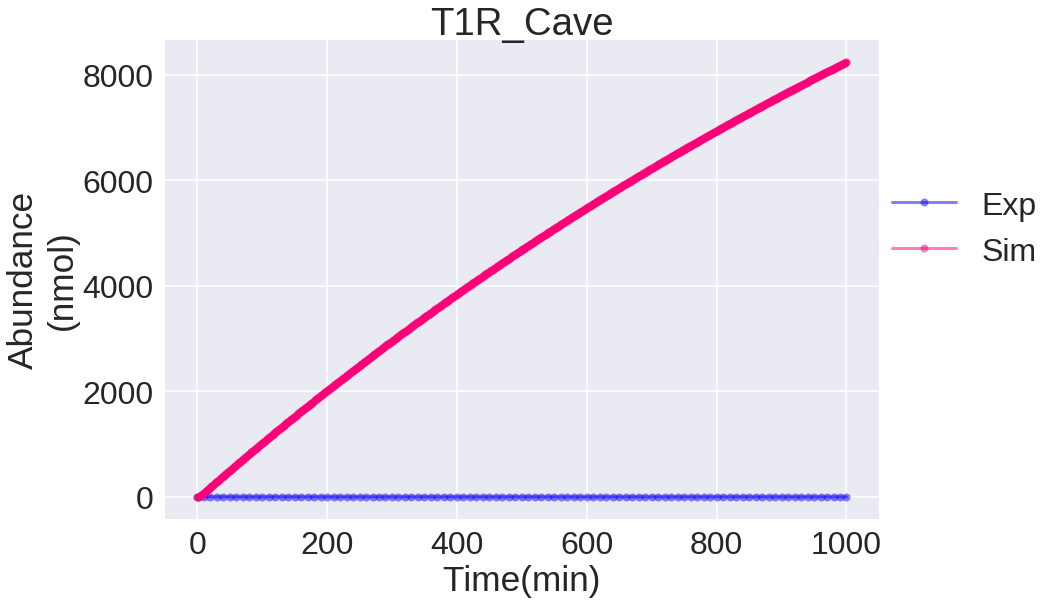

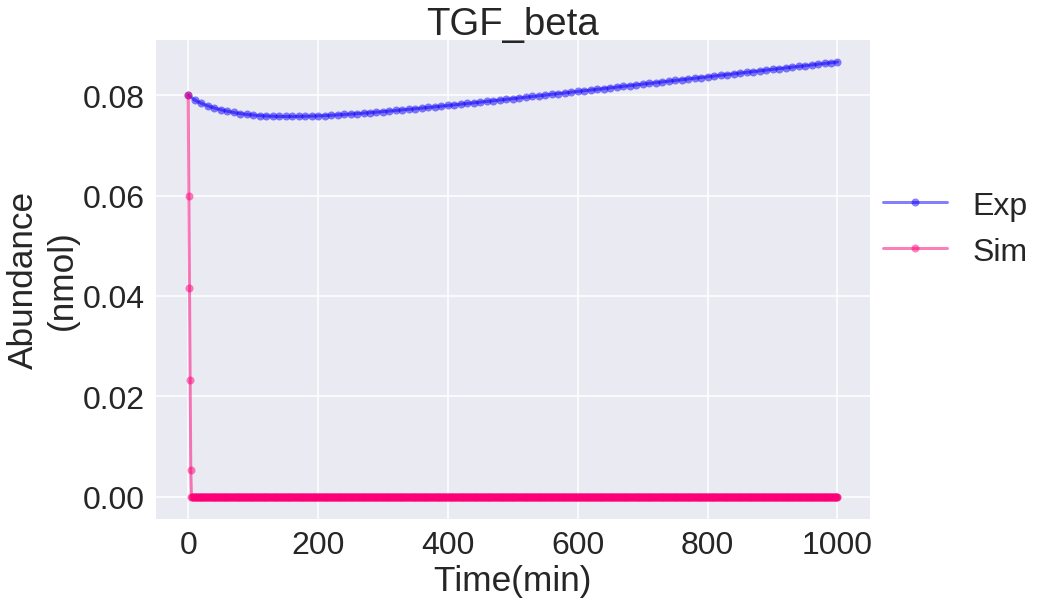

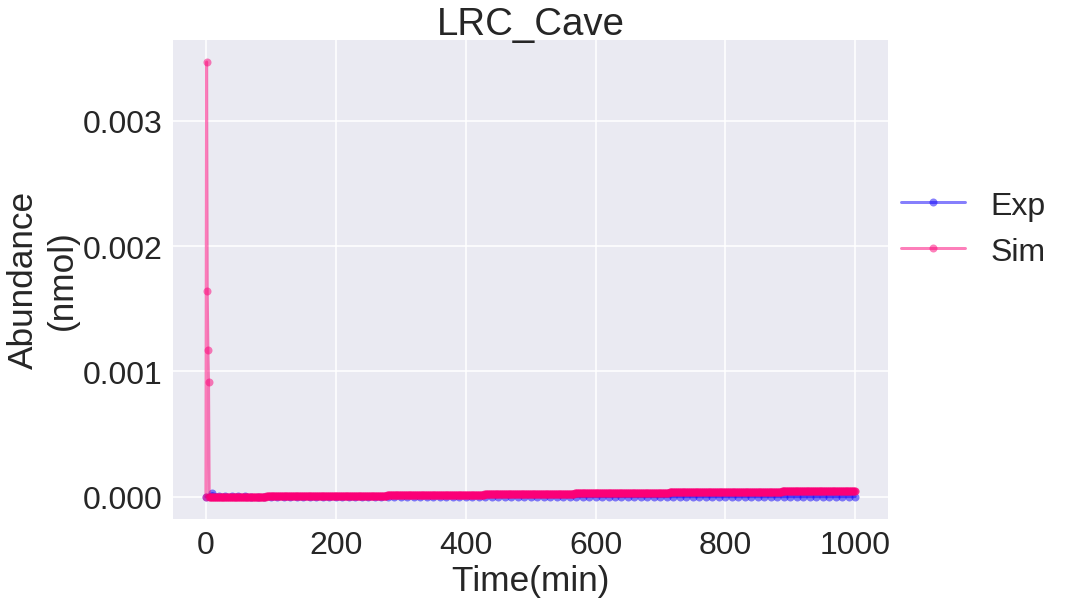

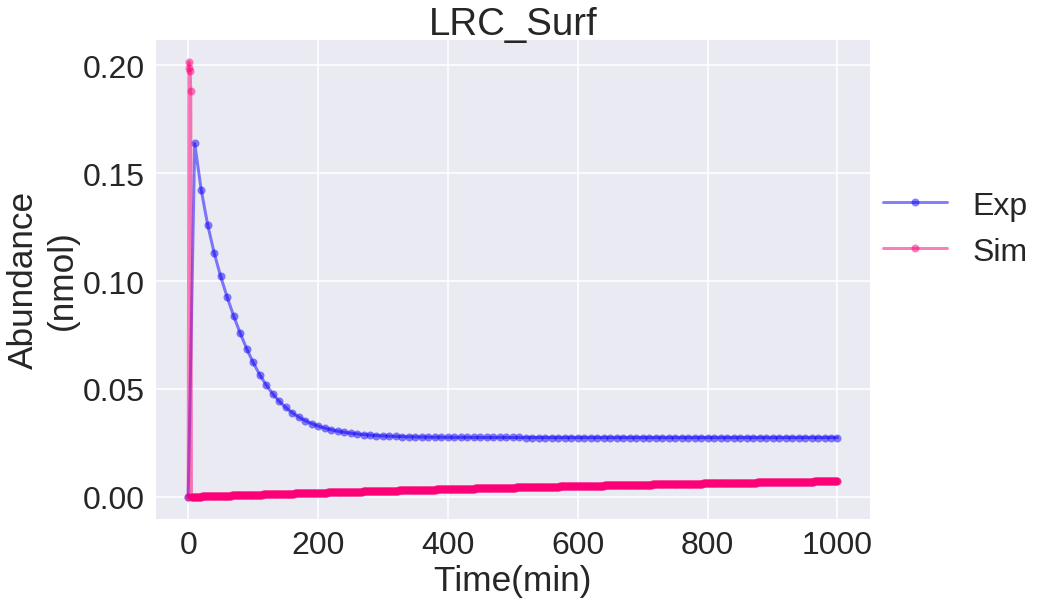

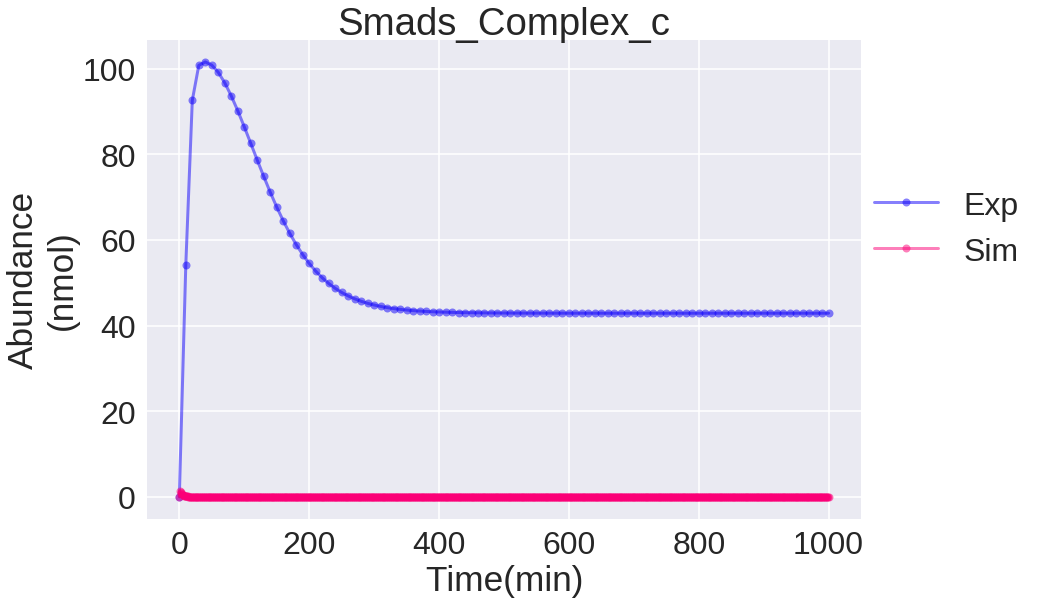

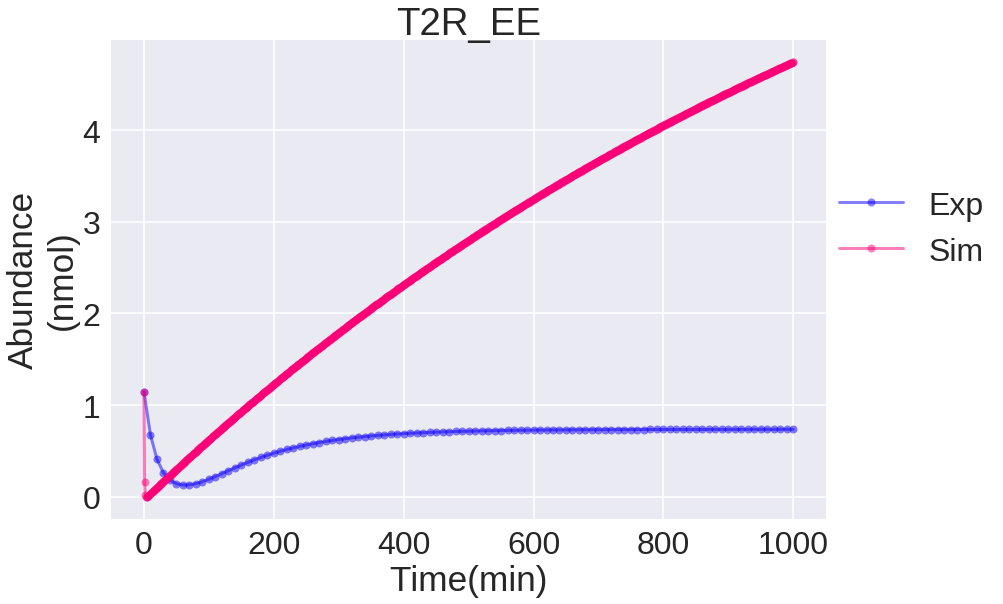

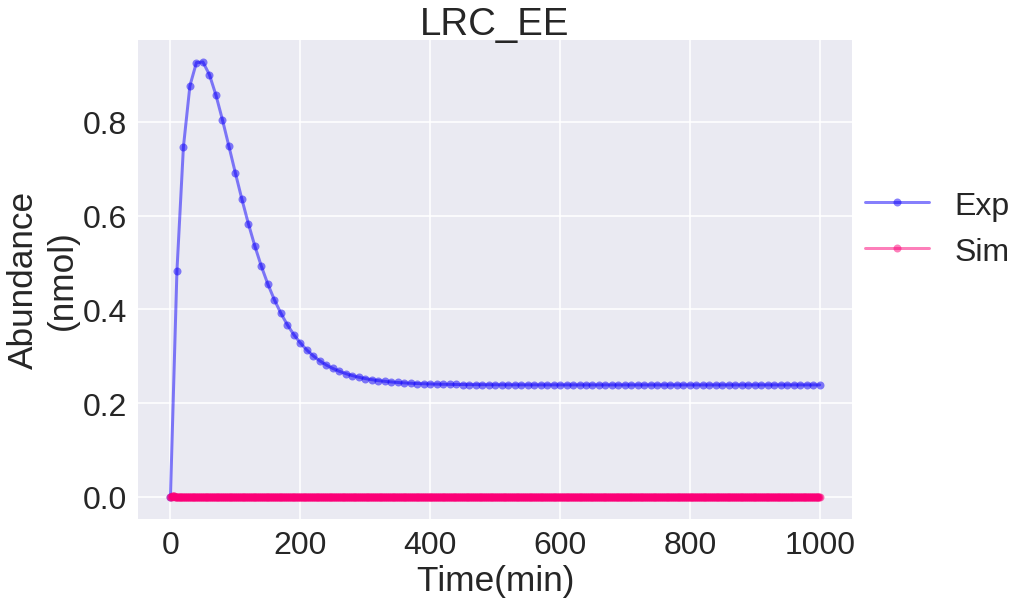

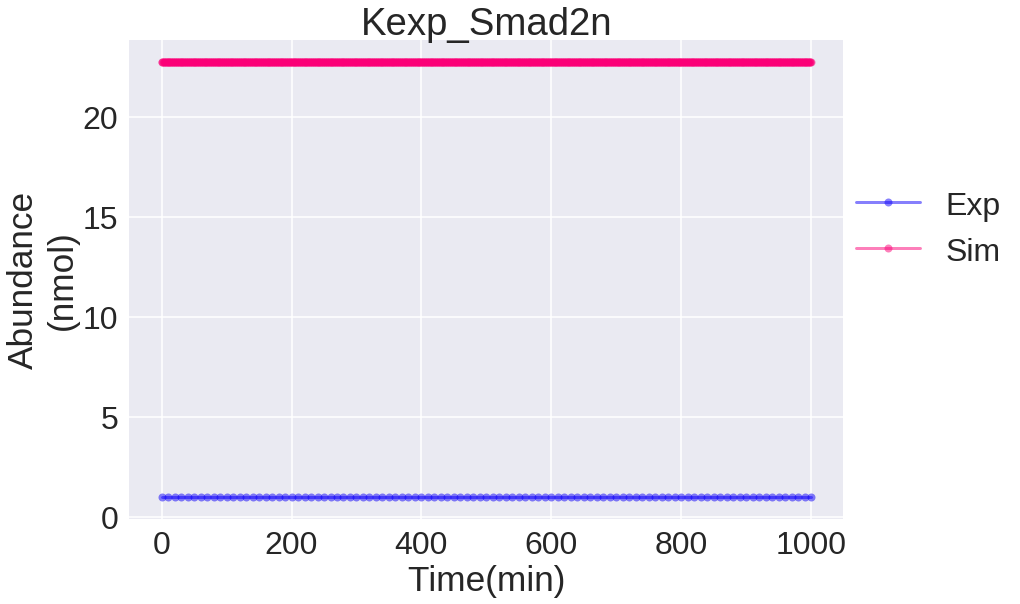

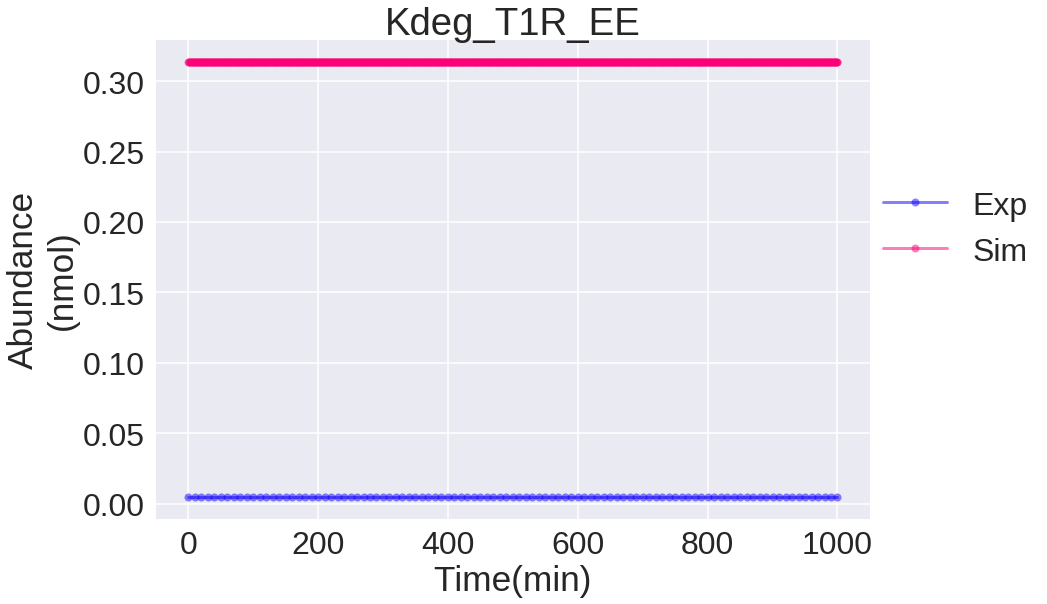

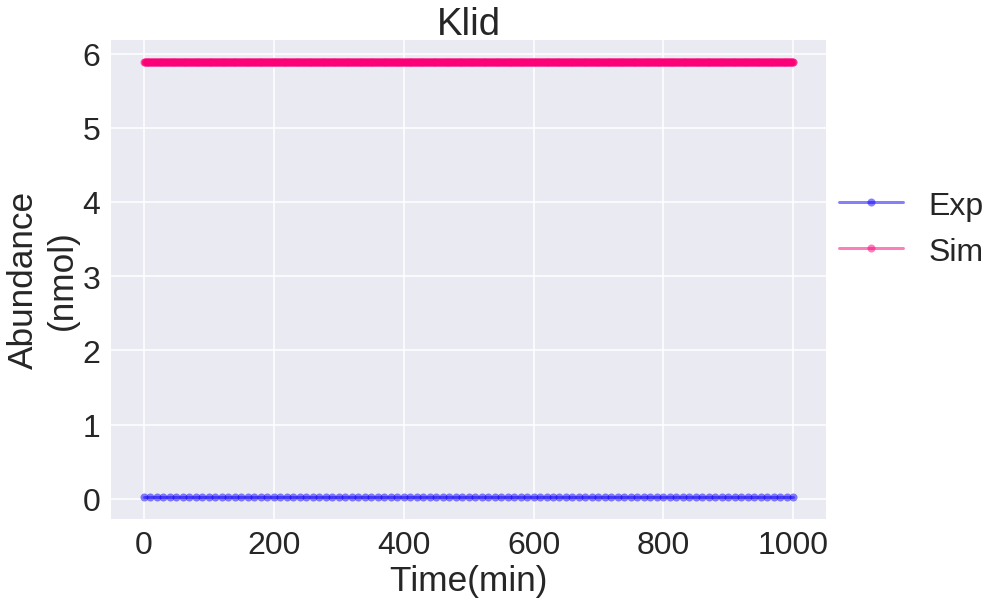

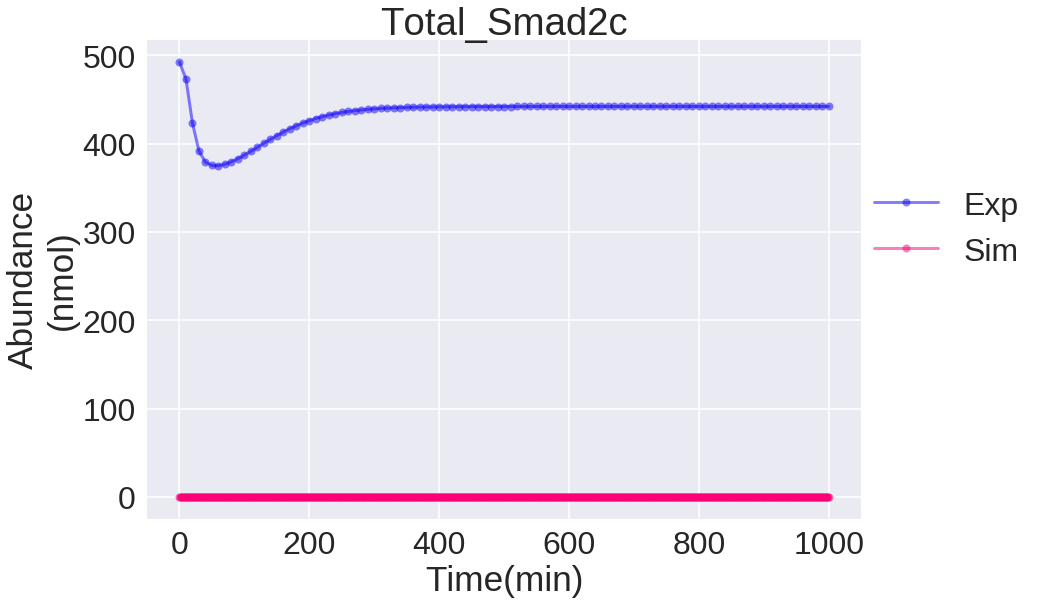

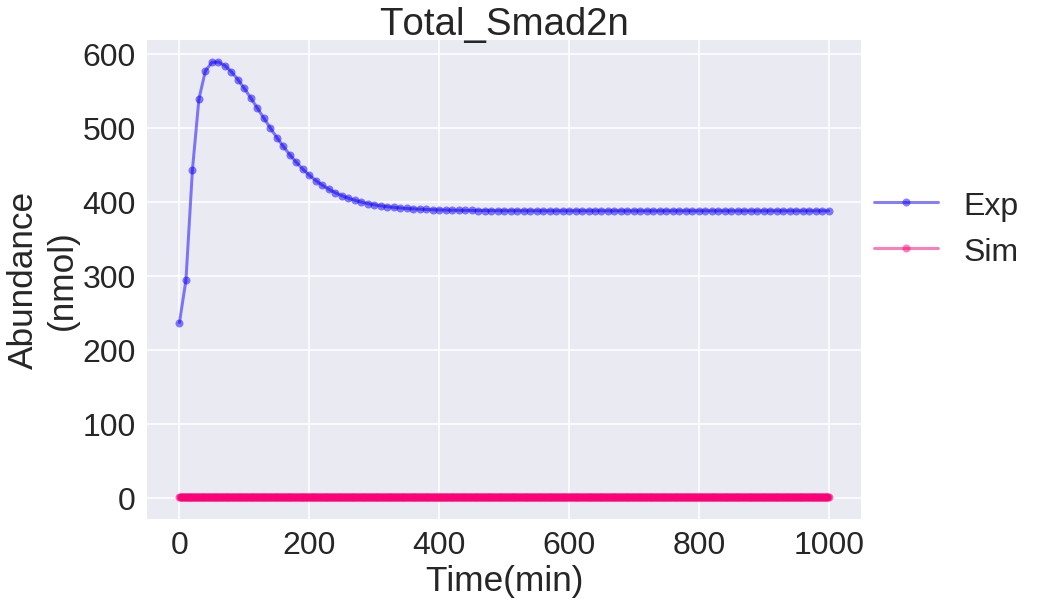

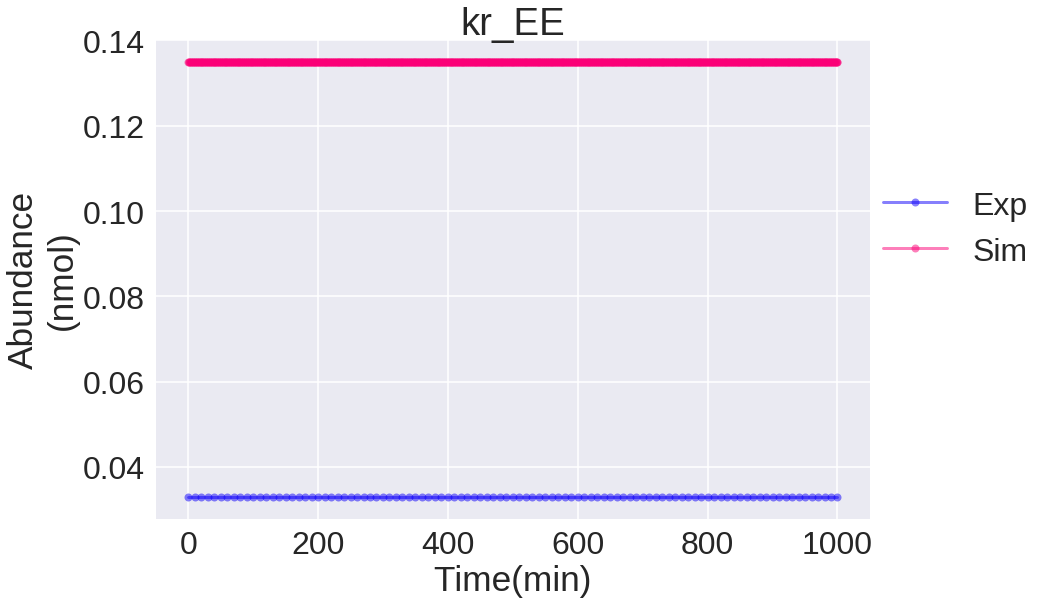

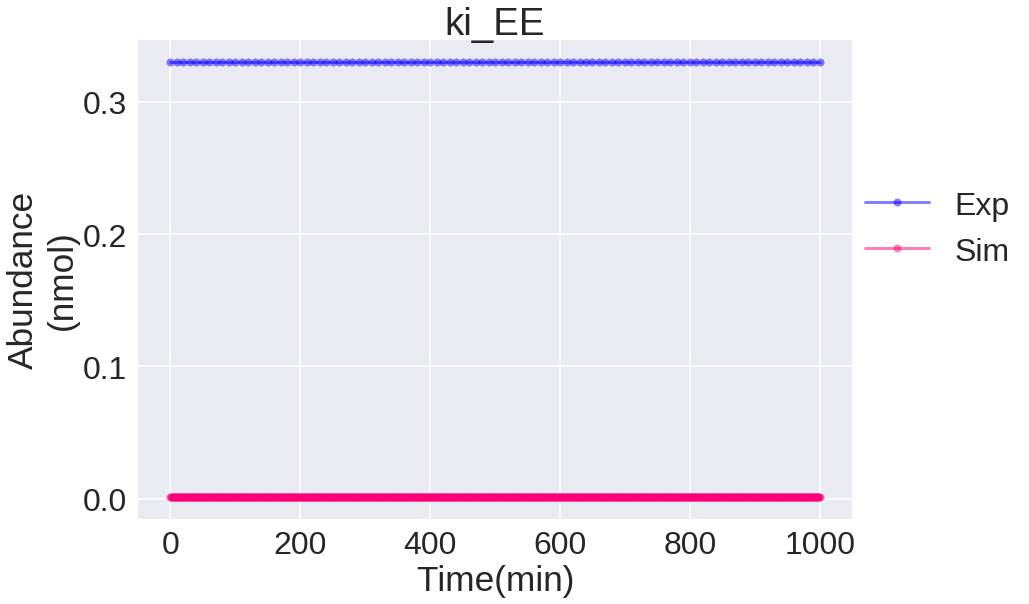

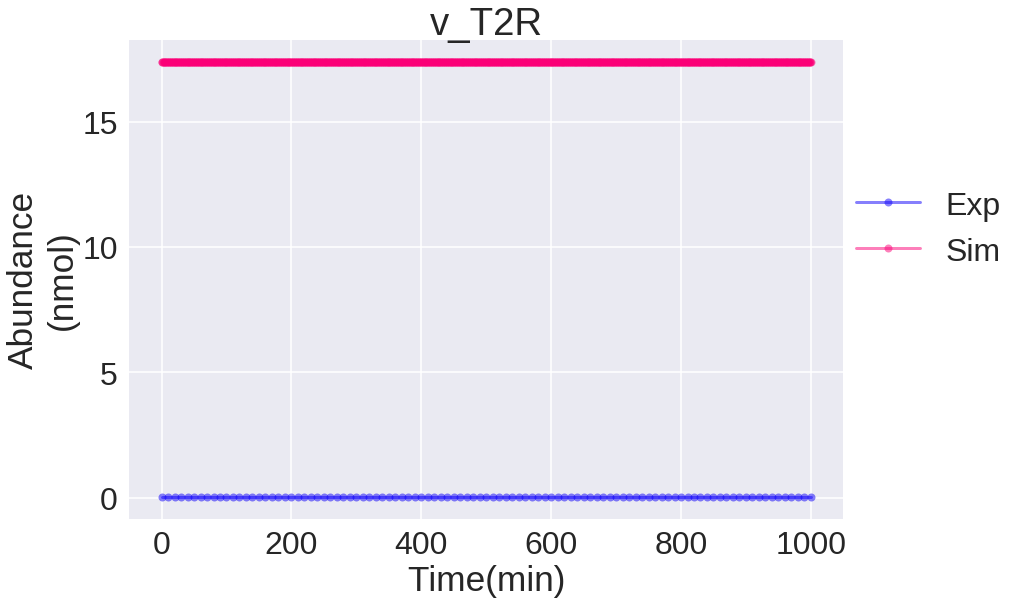

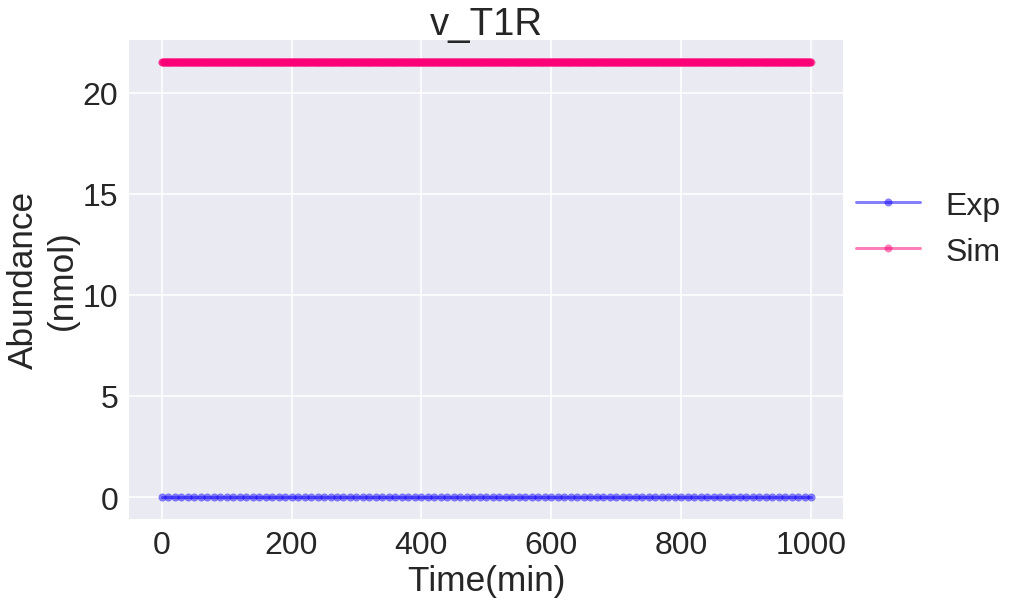

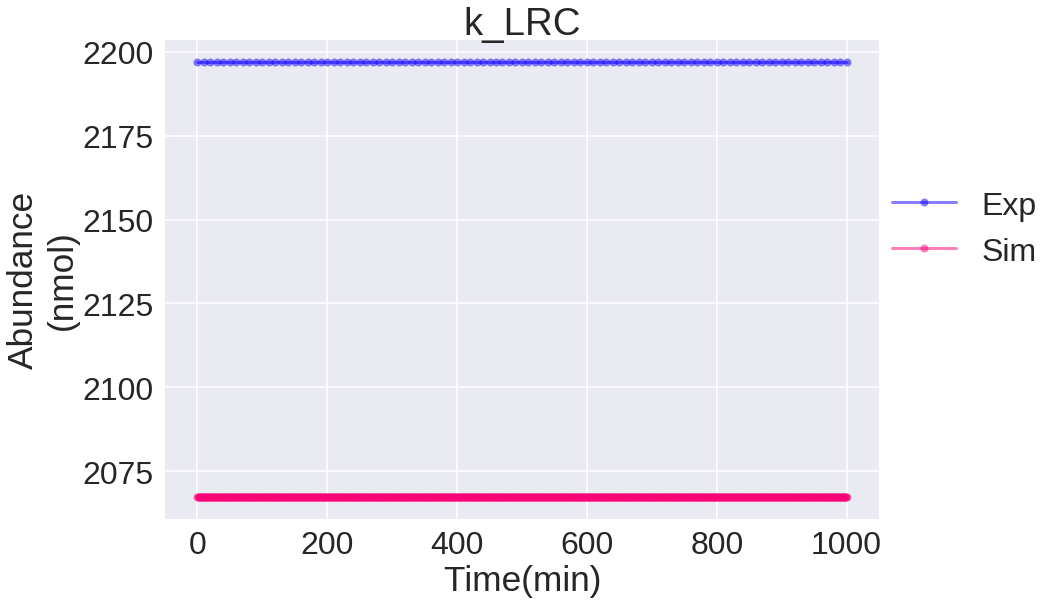

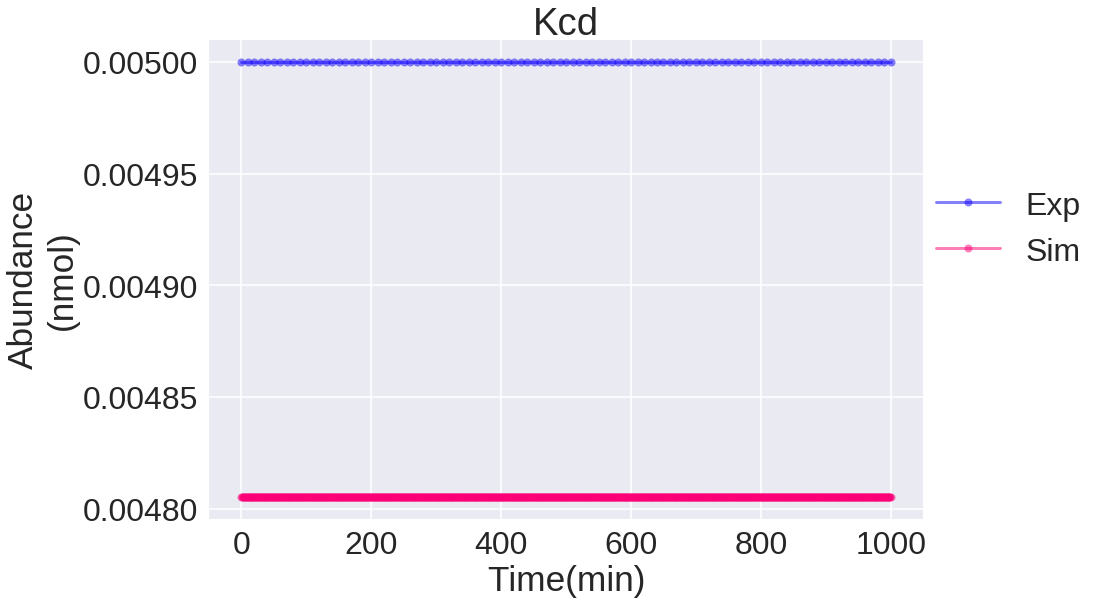

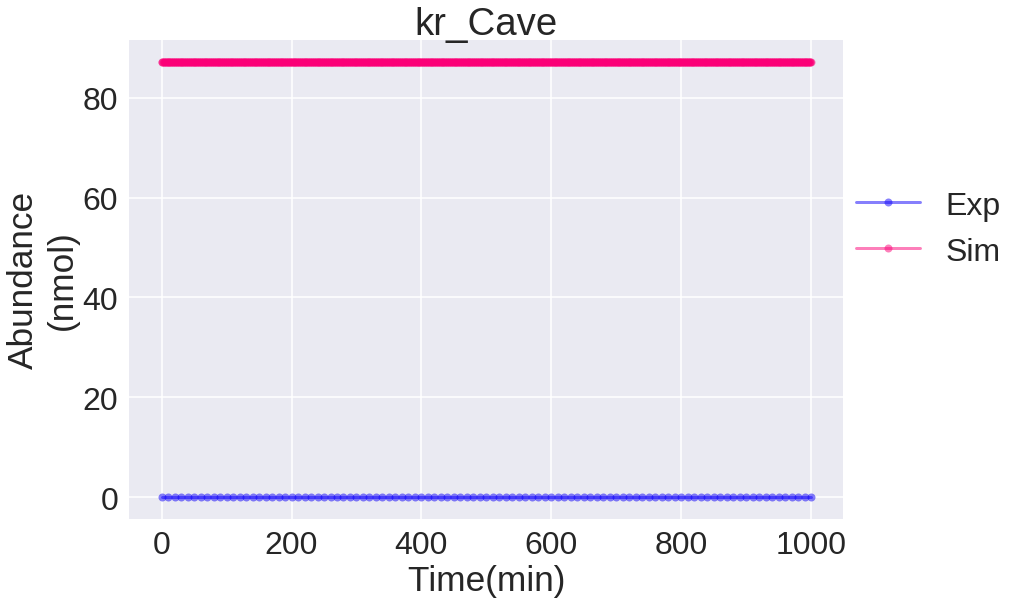

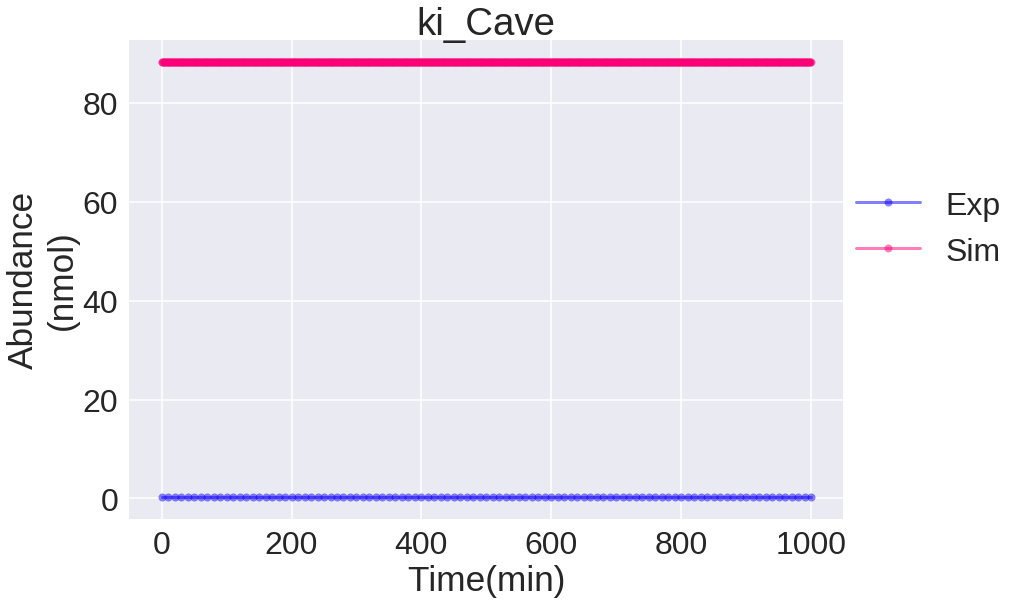

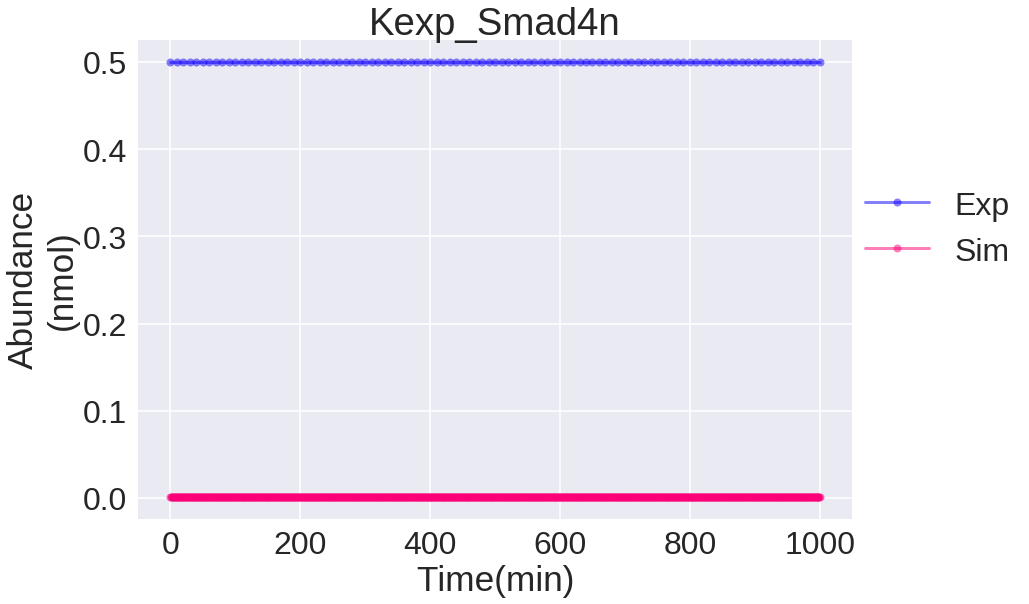

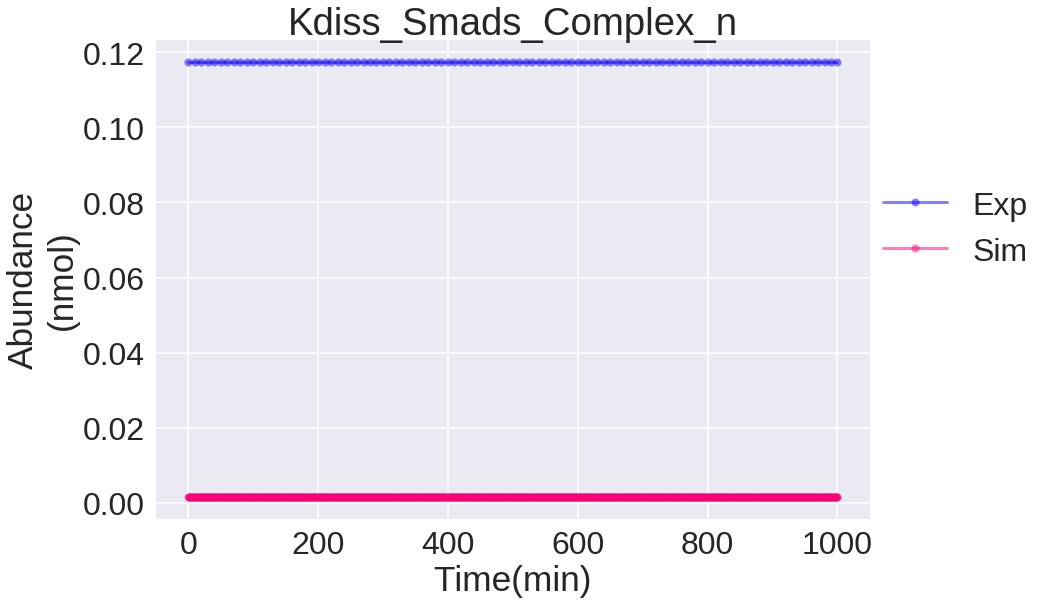

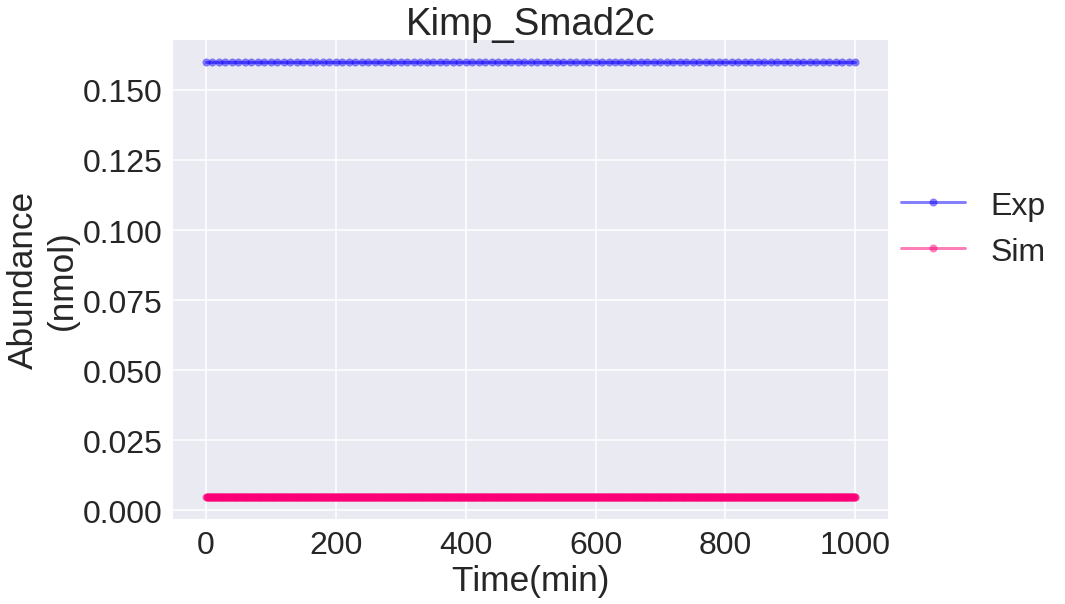

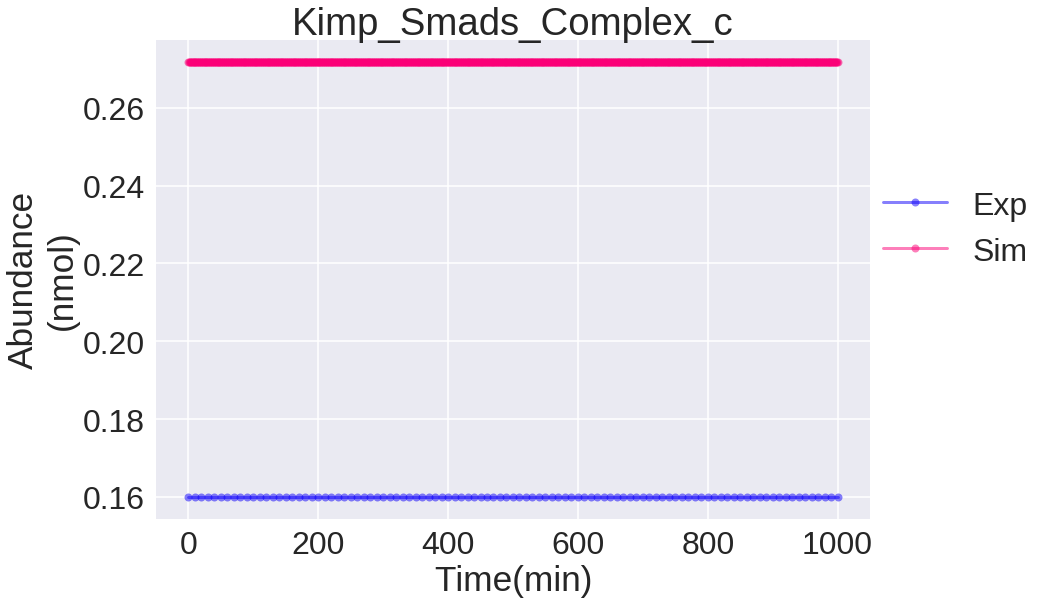

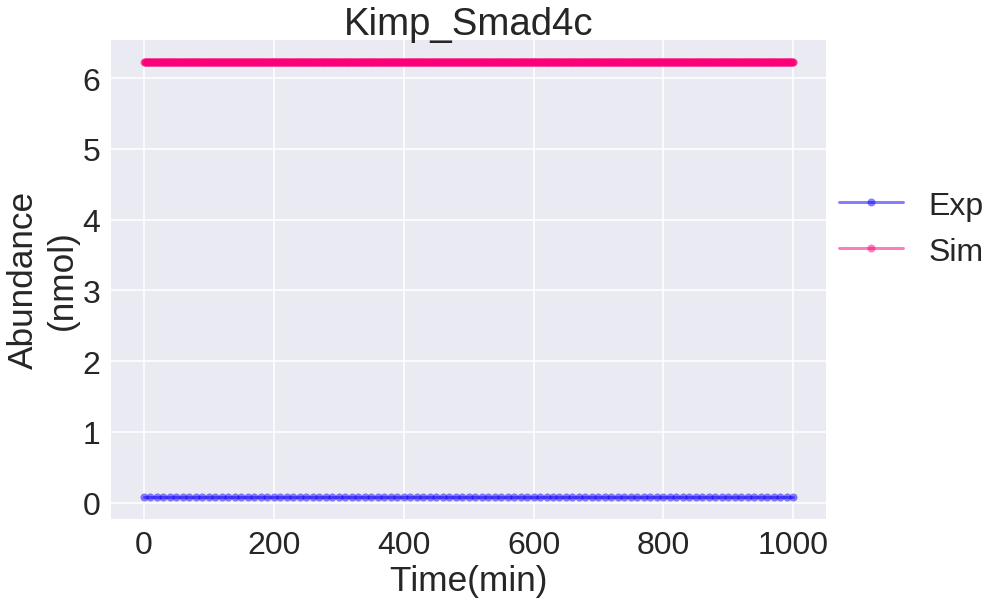

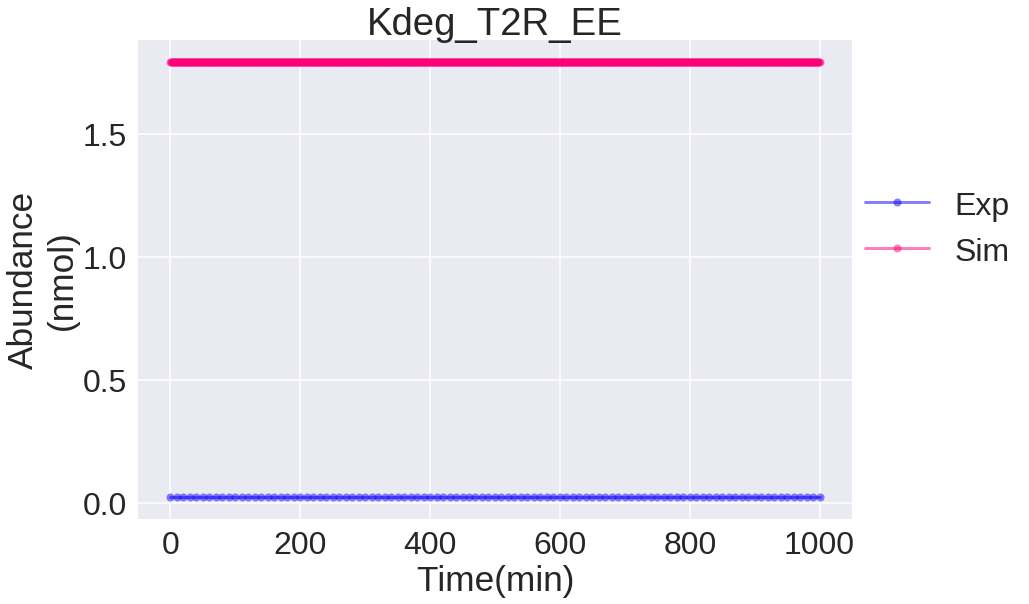

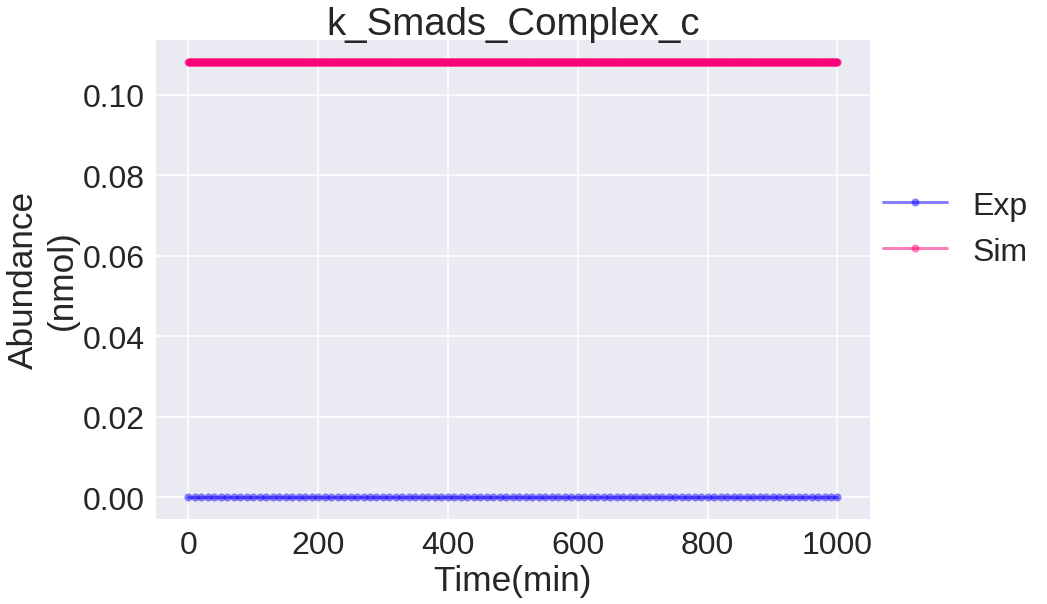

In [15]:
viz.PlotParameterEstimation(PE, savefig=True)

## Save to file (user specified options)

pycotools.viz:INFO:1559:    figure saved to "MyParameterEstimationResults/parameter_estimation_synthetic_data/Smad3n.png"
pycotools.viz:INFO:1559:    figure saved to "MyParameterEstimationResults/parameter_estimation_synthetic_data/Smad3c.png"
pycotools.viz:INFO:1559:    figure saved to "MyParameterEstimationResults/parameter_estimation_synthetic_data/Smad4n.png"
pycotools.viz:INFO:1559:    figure saved to "MyParameterEstimationResults/parameter_estimation_synthetic_data/Smad4c.png"
pycotools.viz:INFO:1559:    figure saved to "MyParameterEstimationResults/parameter_estimation_synthetic_data/T1R_Surf.png"
pycotools.viz:INFO:1559:    figure saved to "MyParameterEstimationResults/parameter_estimation_synthetic_data/T2R_Cave.png"
pycotools.viz:INFO:1559:    figure saved to "MyParameterEstimationResults/parameter_estimation_synthetic_data/T2R_Surf.png"
pycotools.viz:INFO:1559:    figure saved to "MyParameterEstimationResults/parameter_estimation_synthetic_data/Smads_Complex_n.png"
pycotools

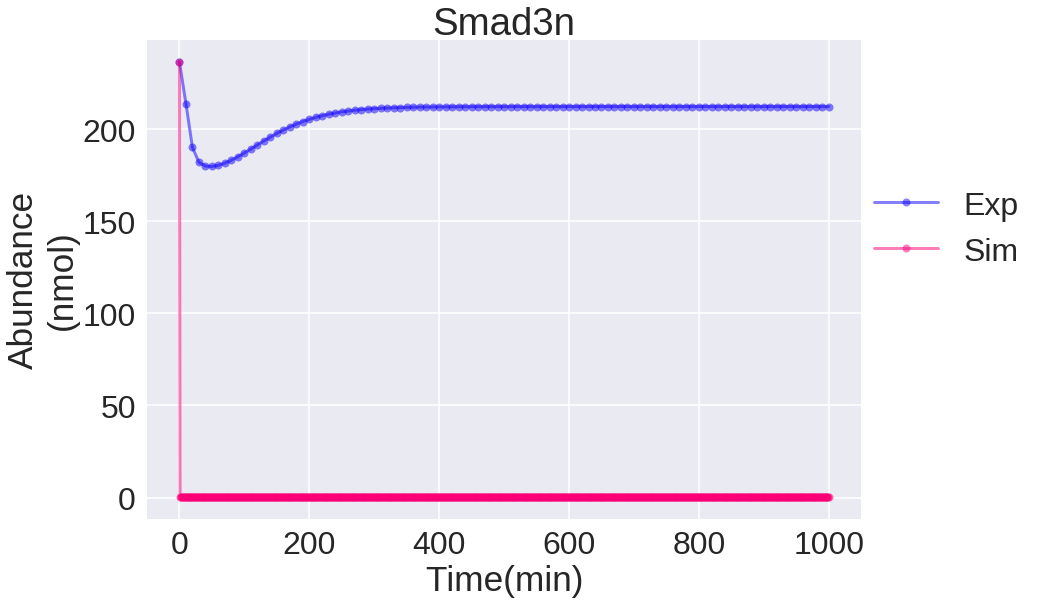

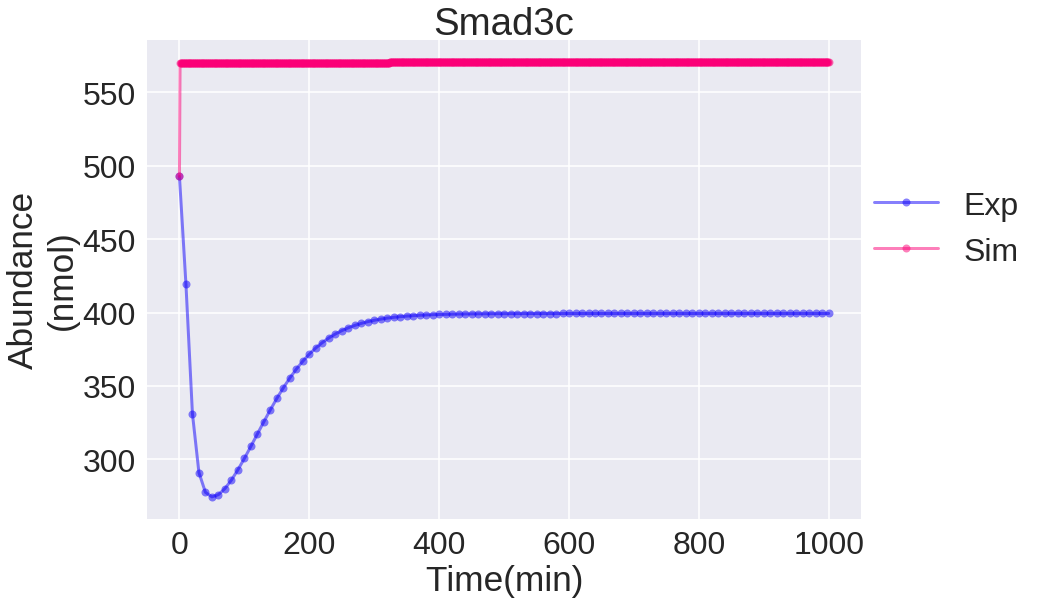

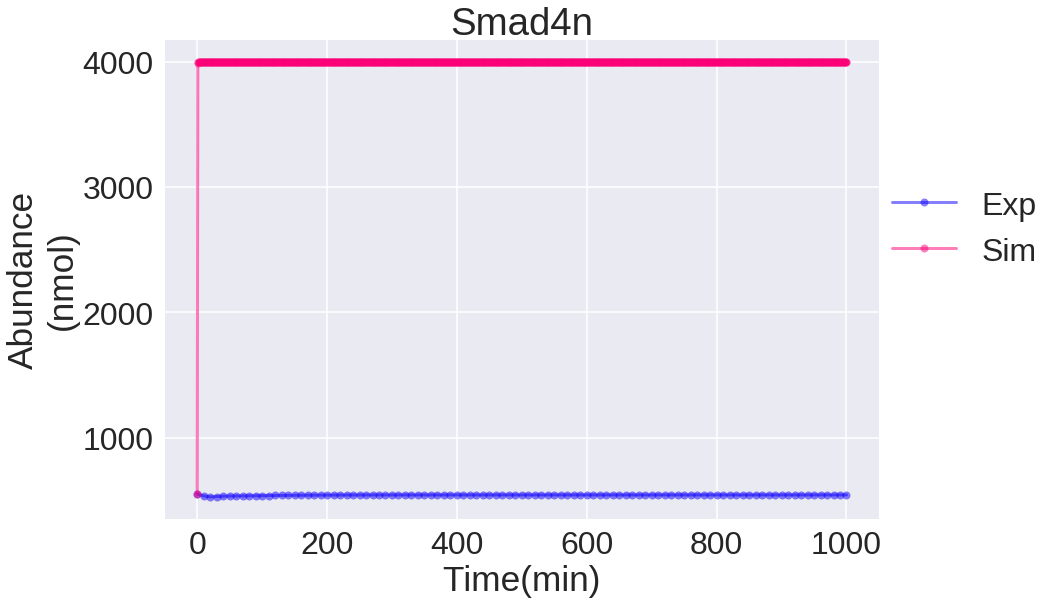

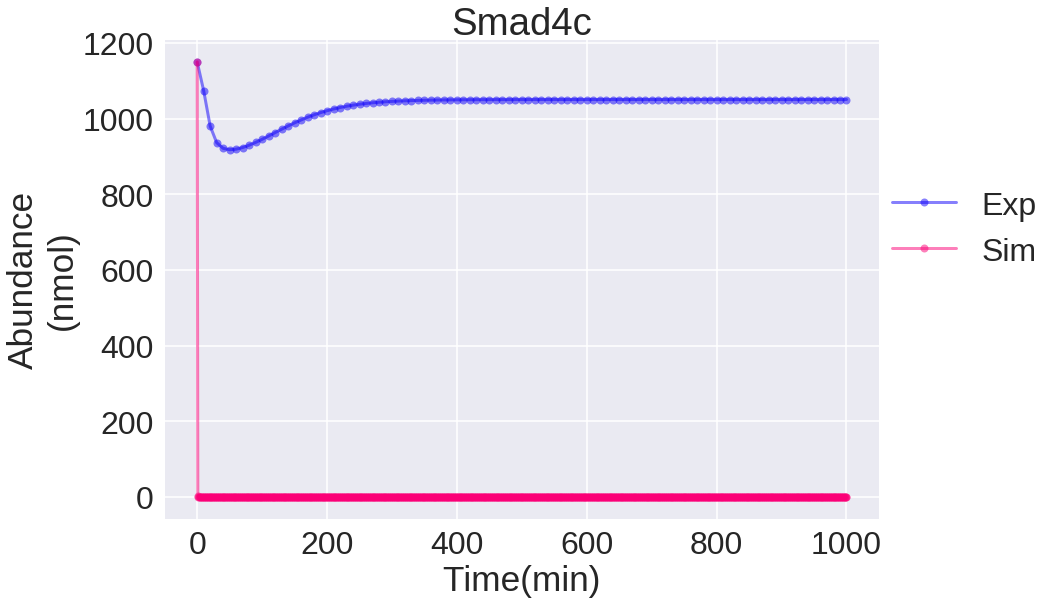

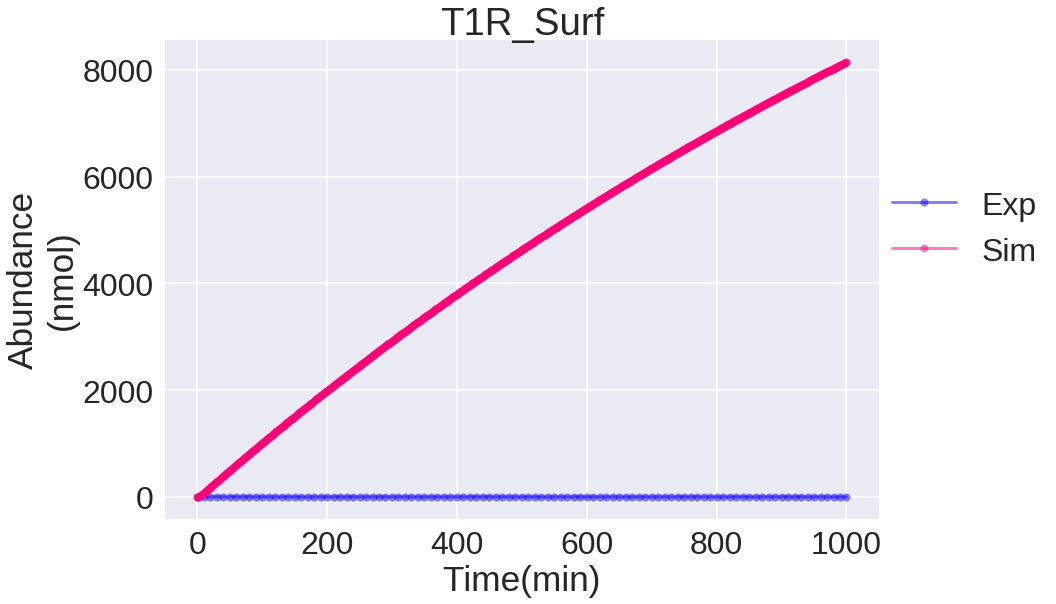

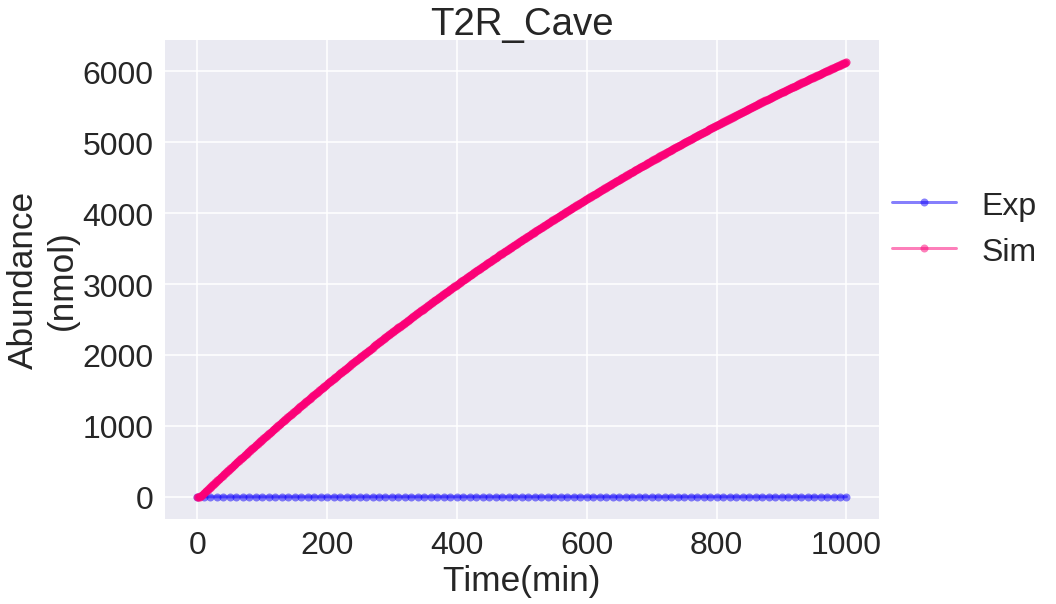

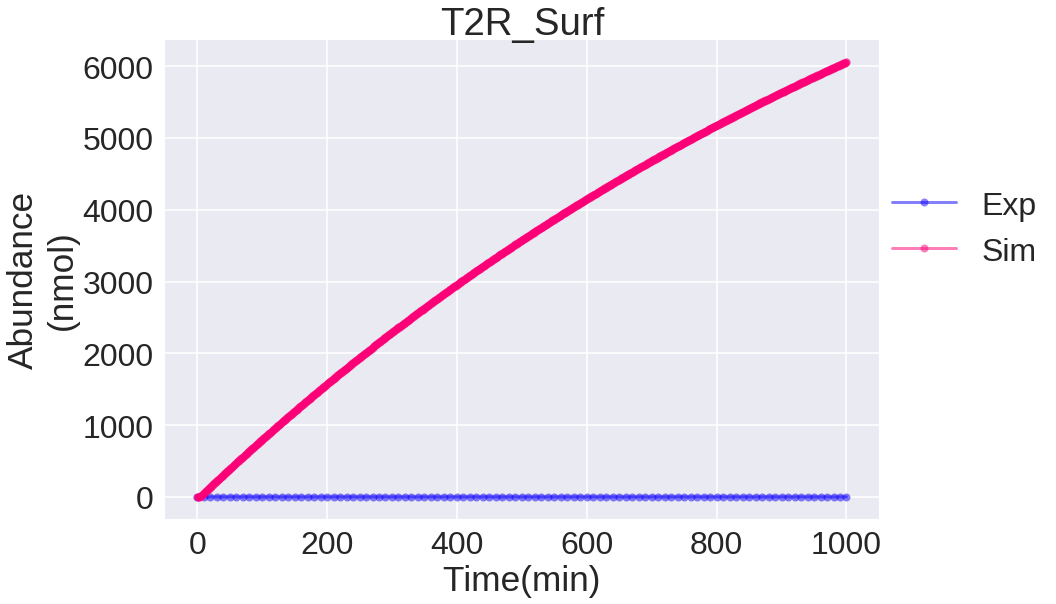

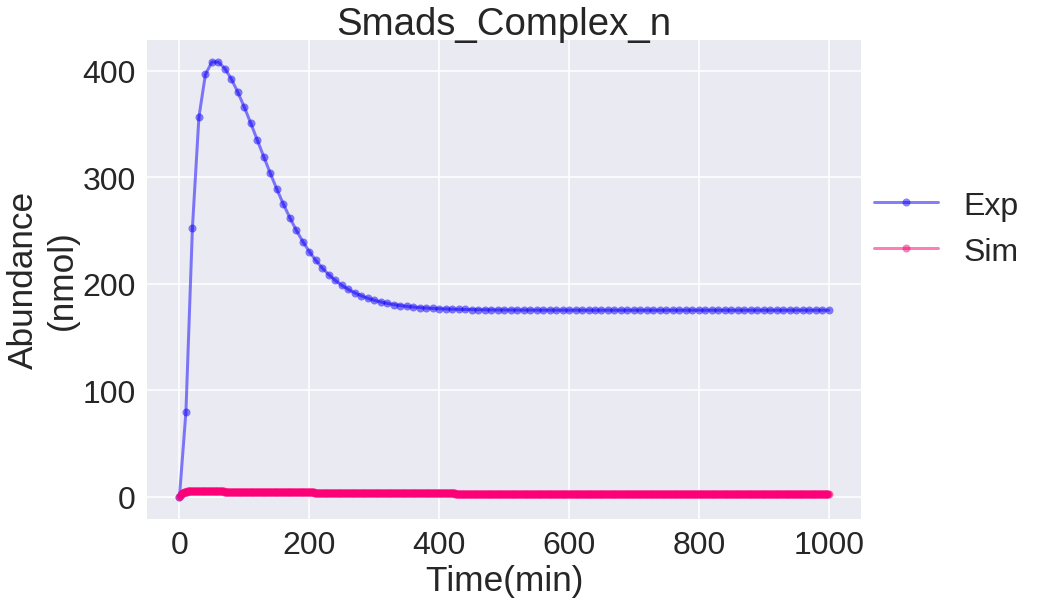

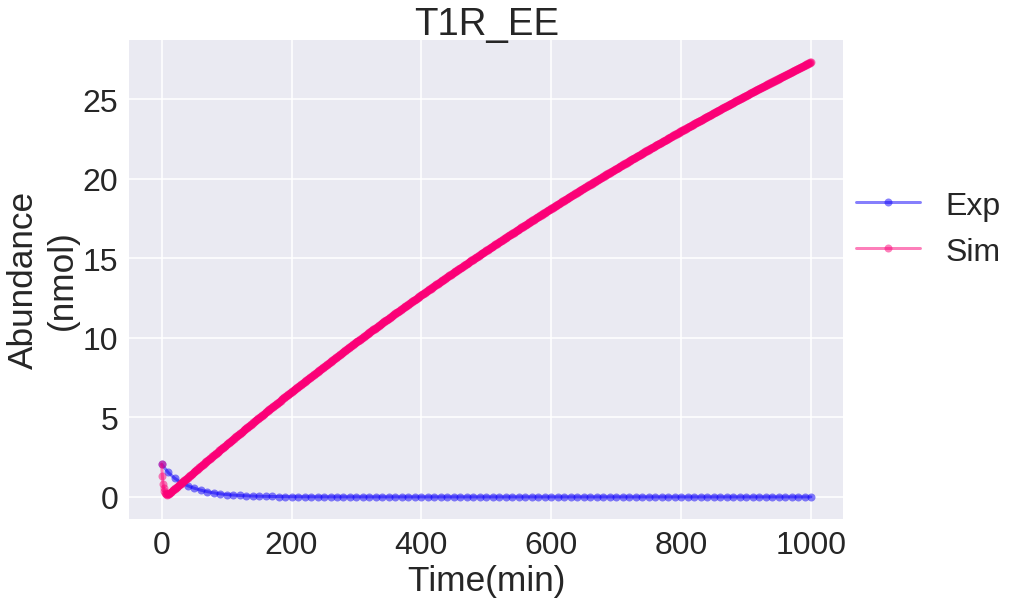

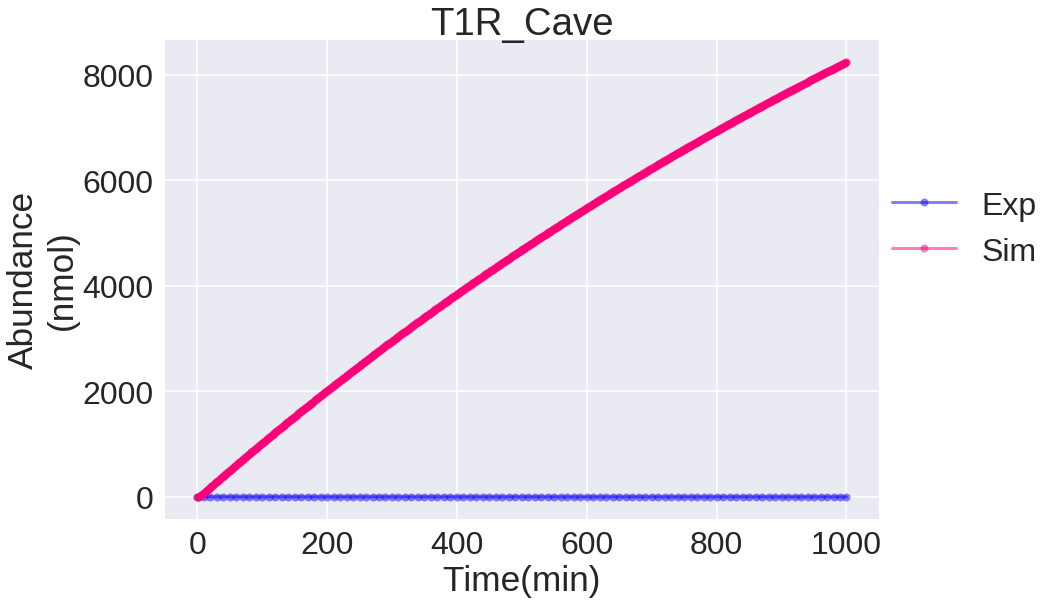

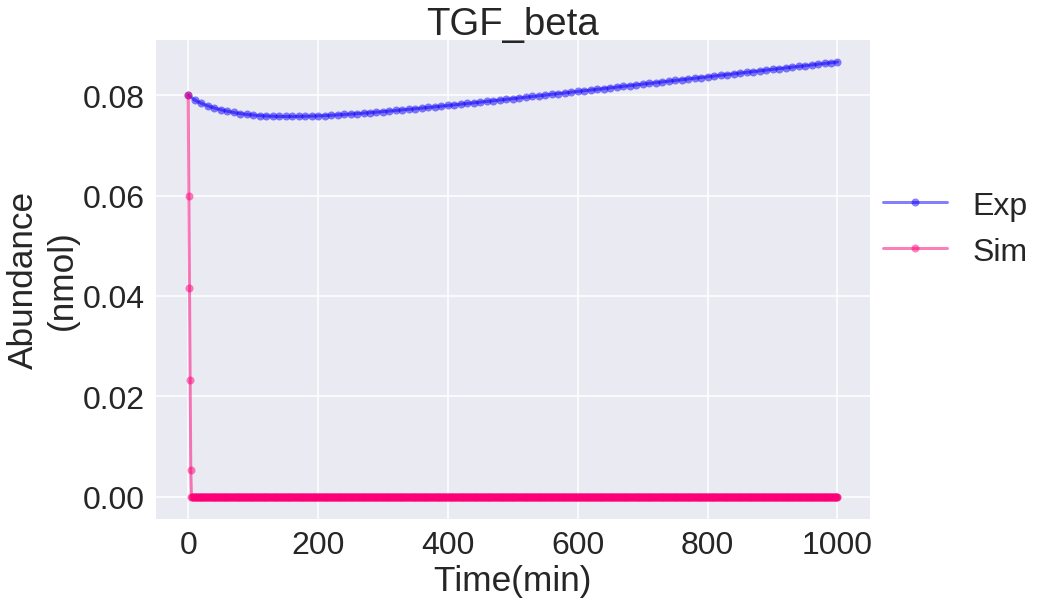

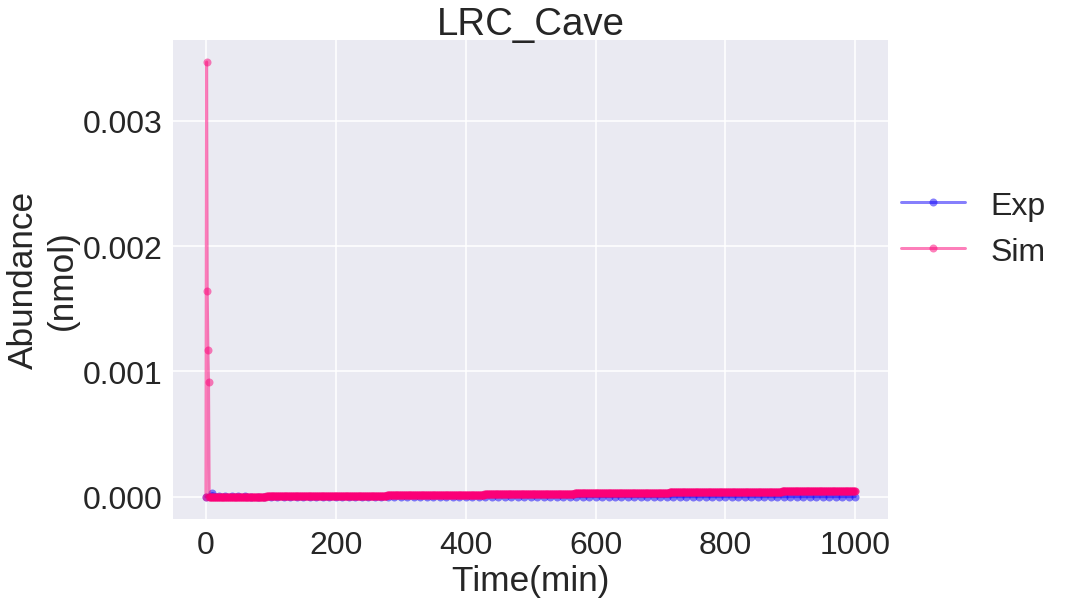

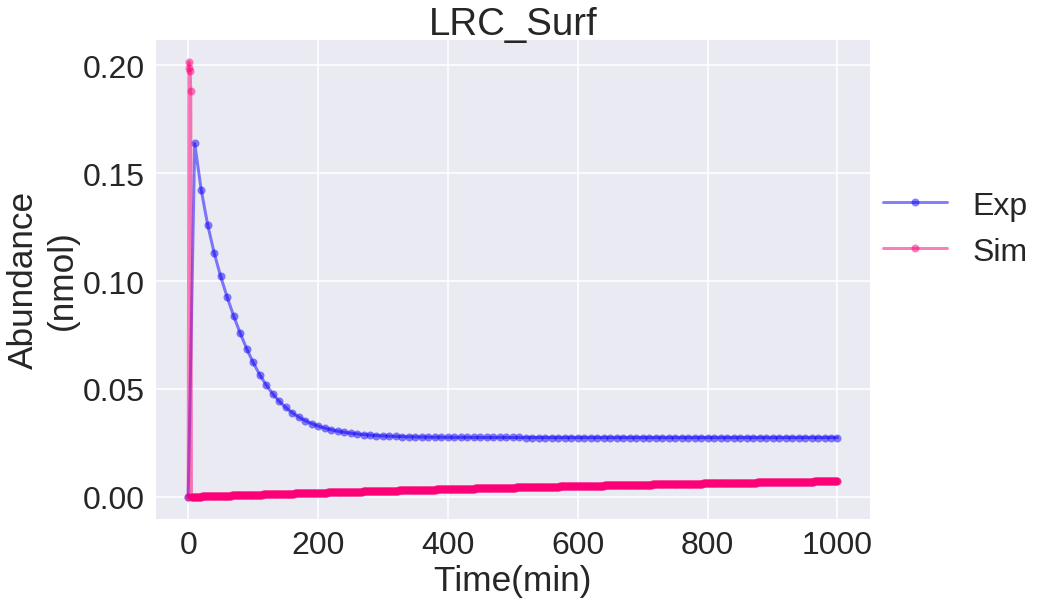

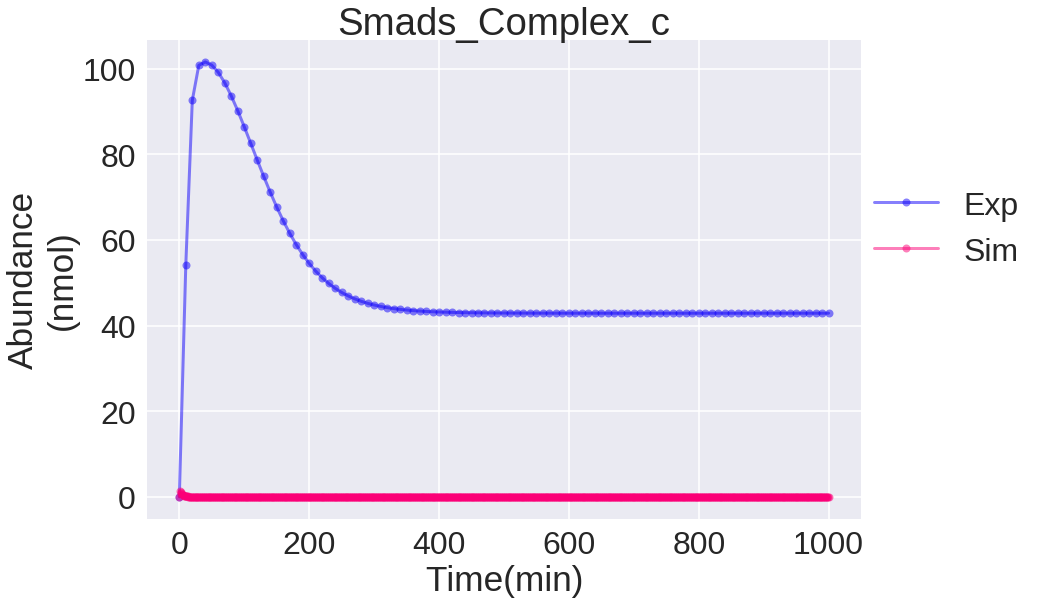

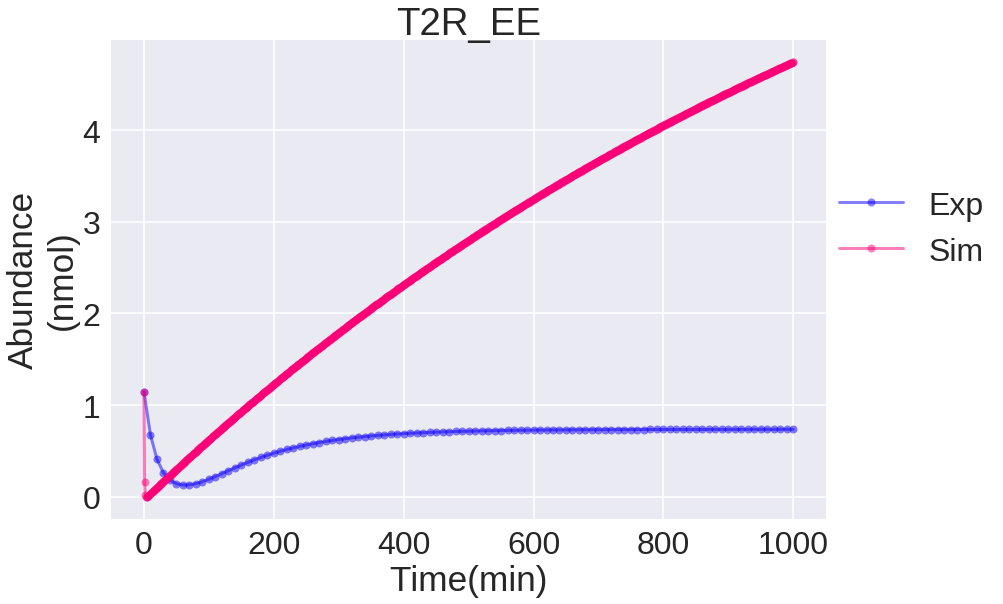

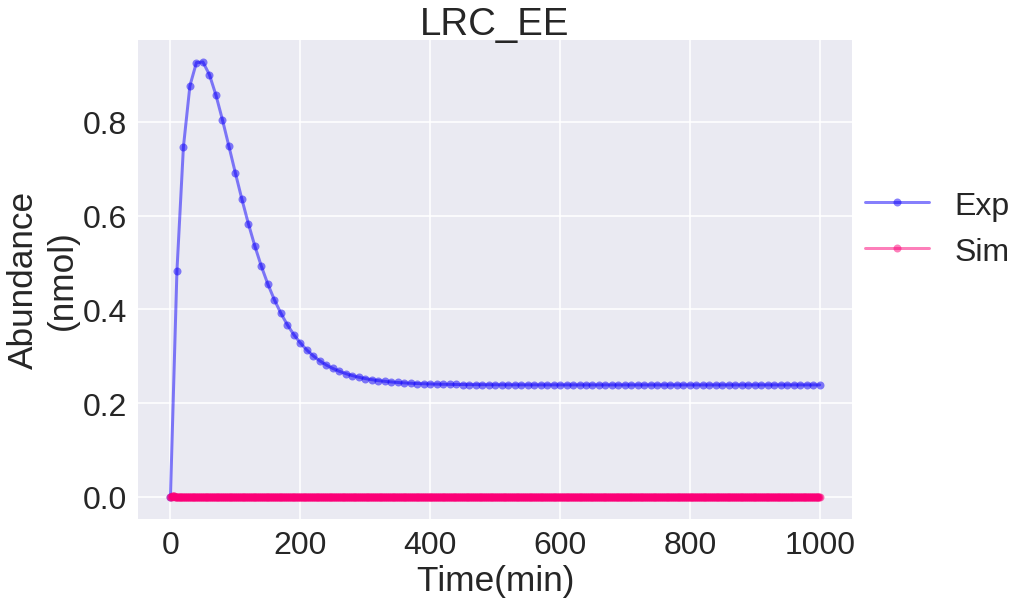

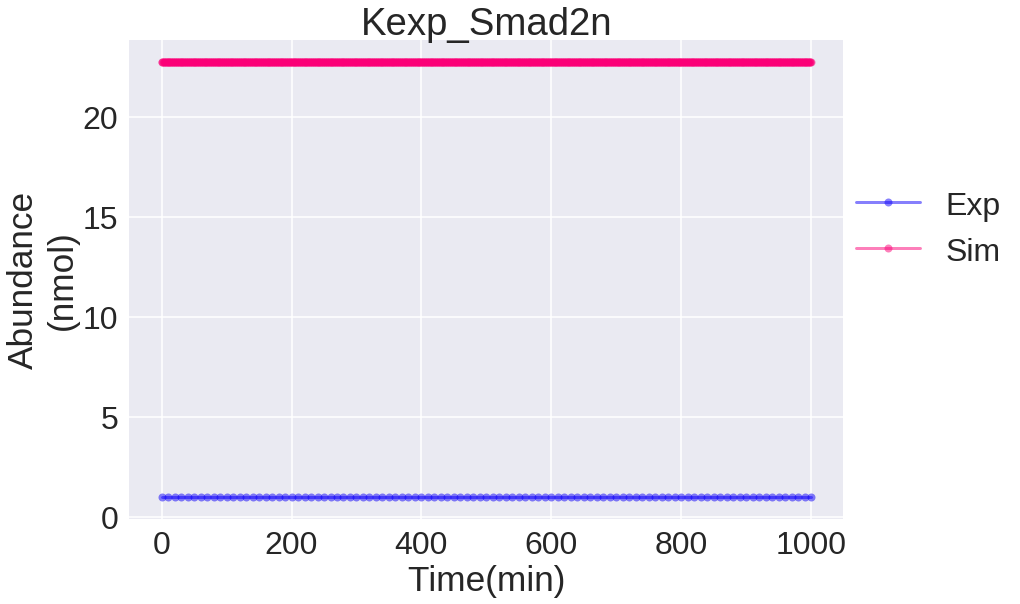

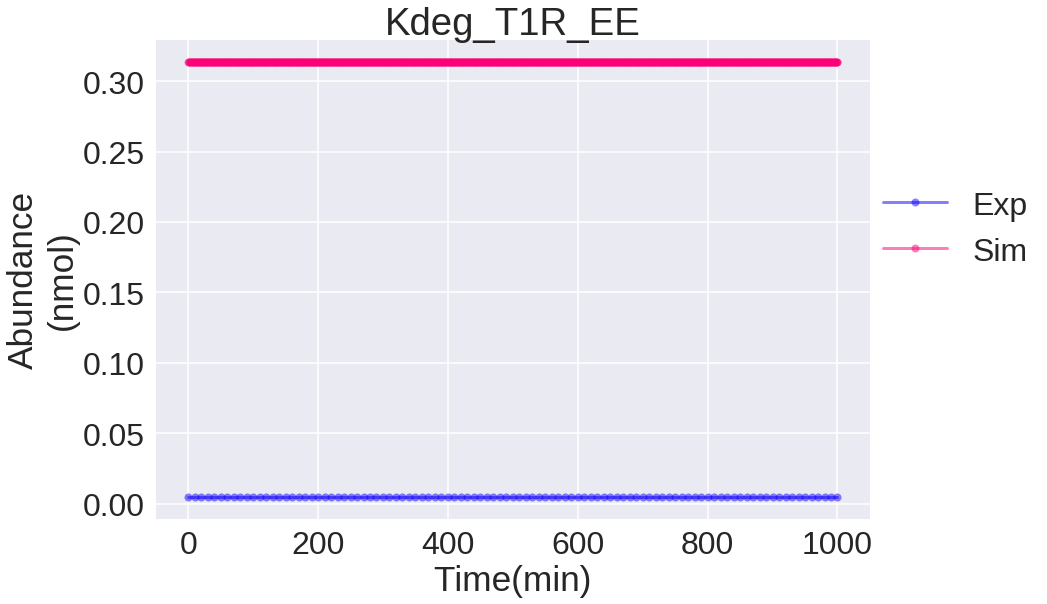

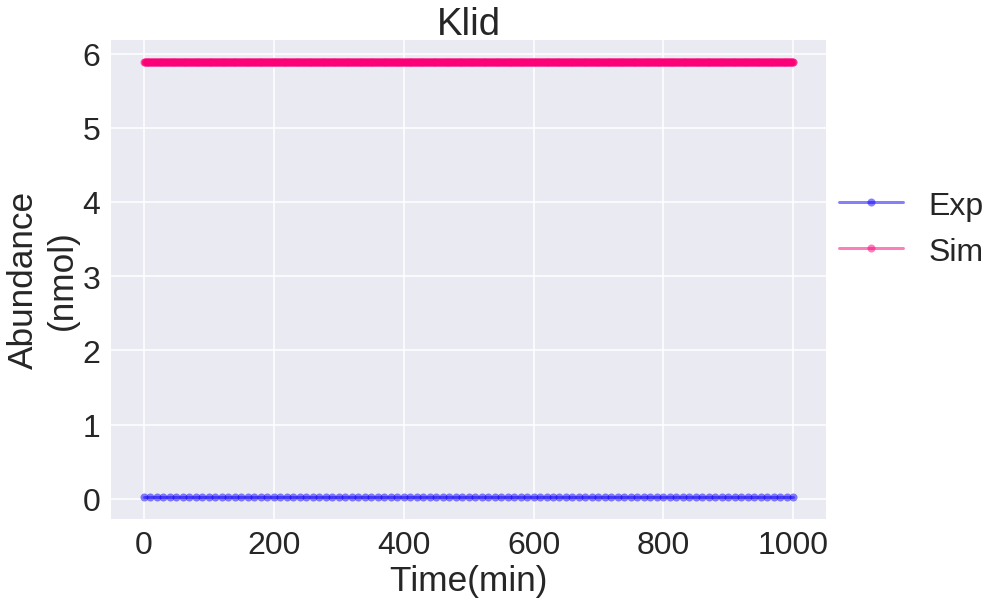

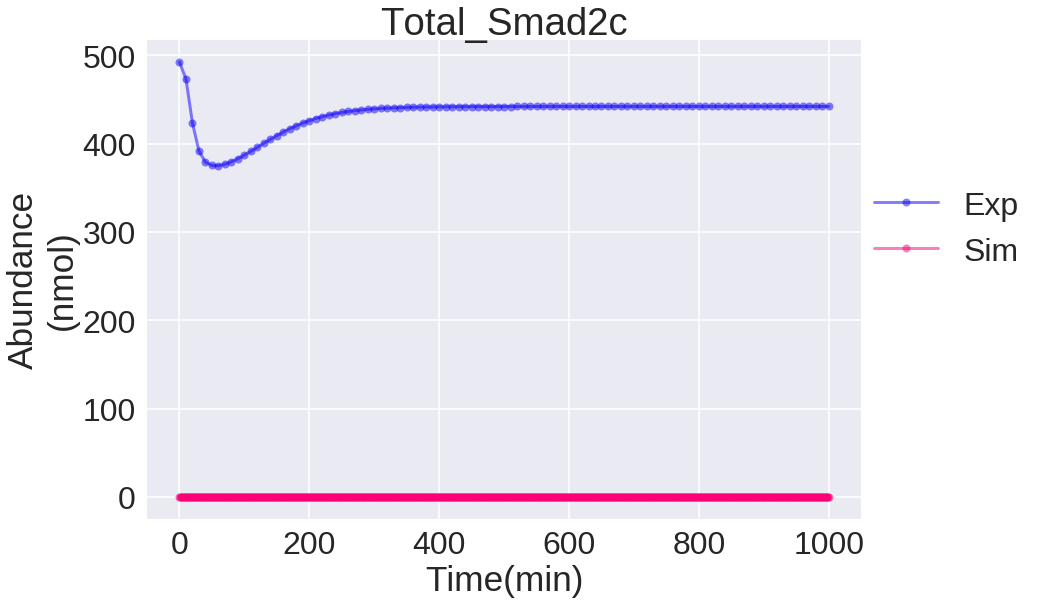

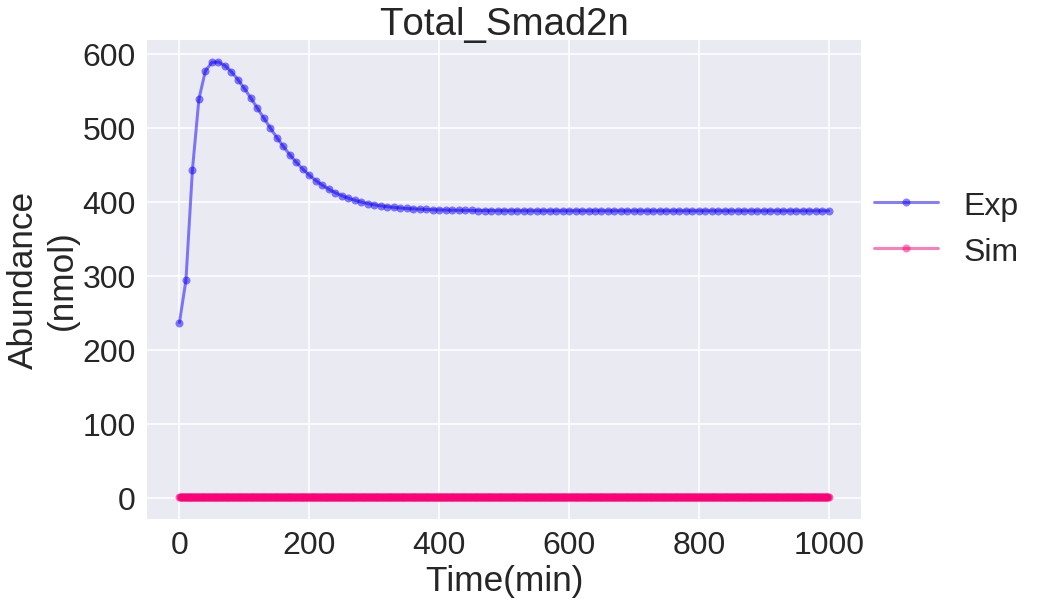

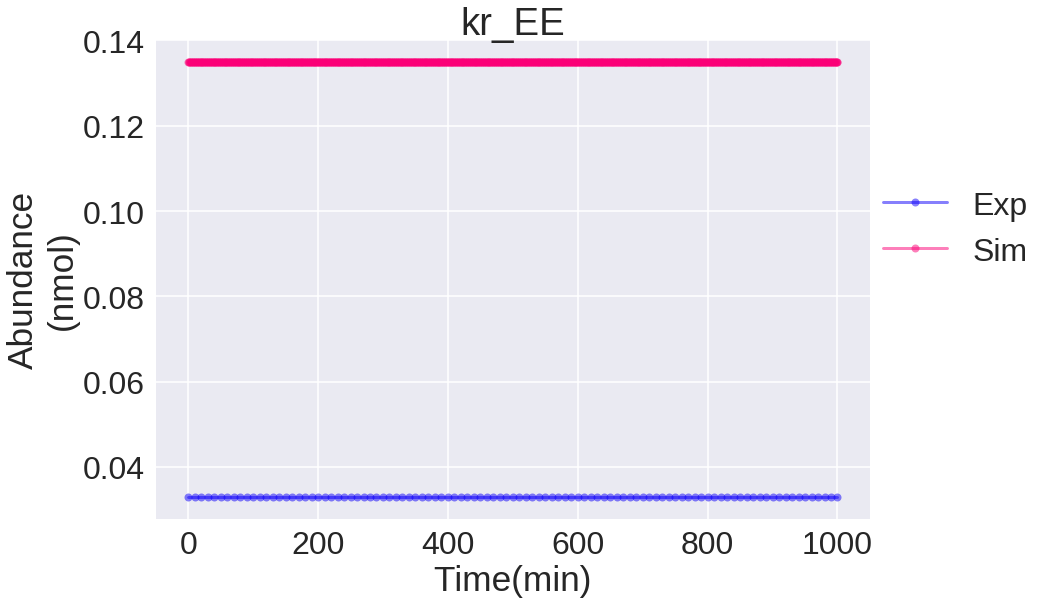

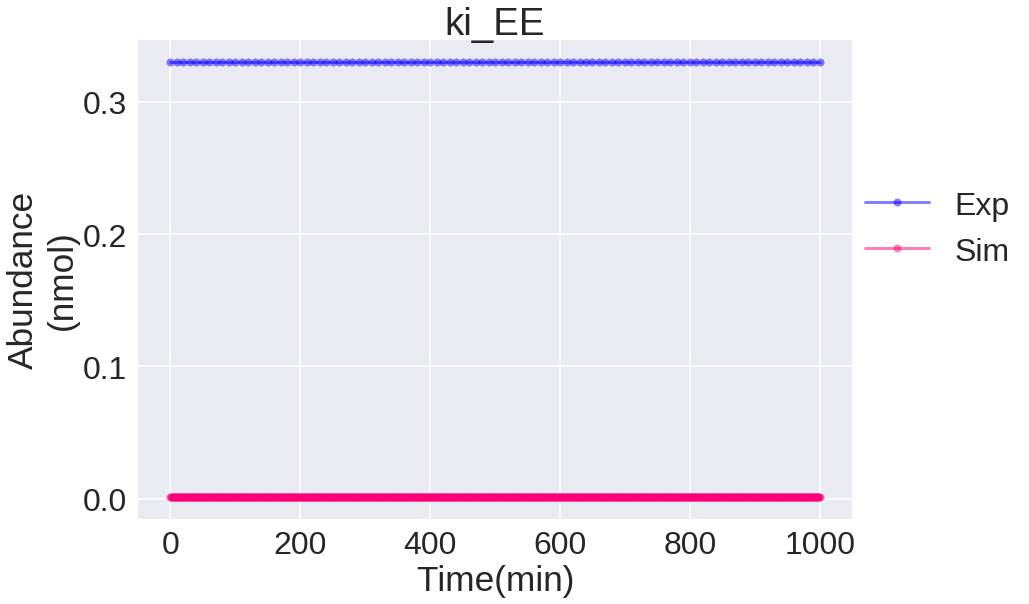

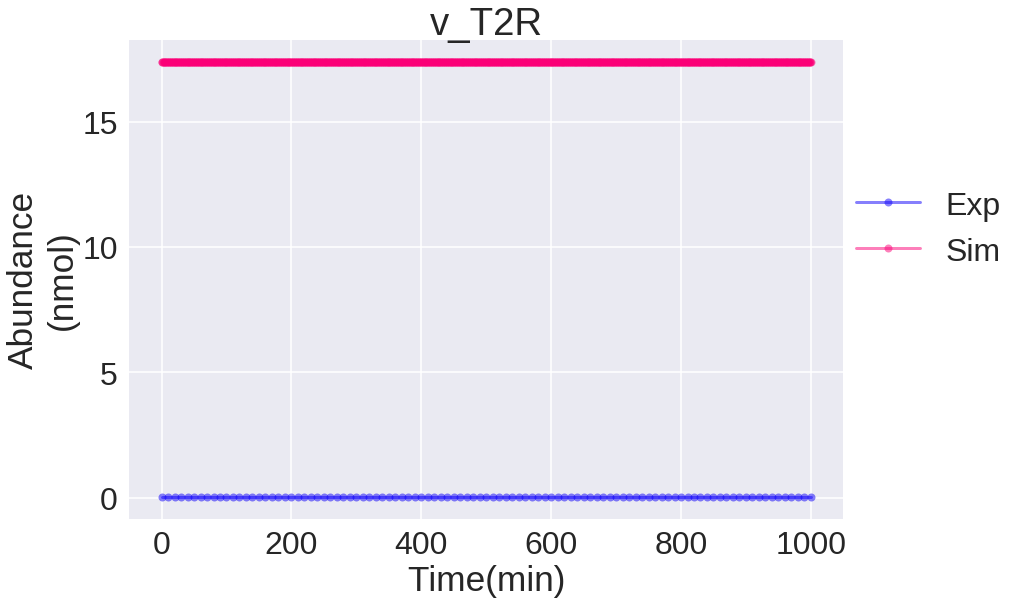

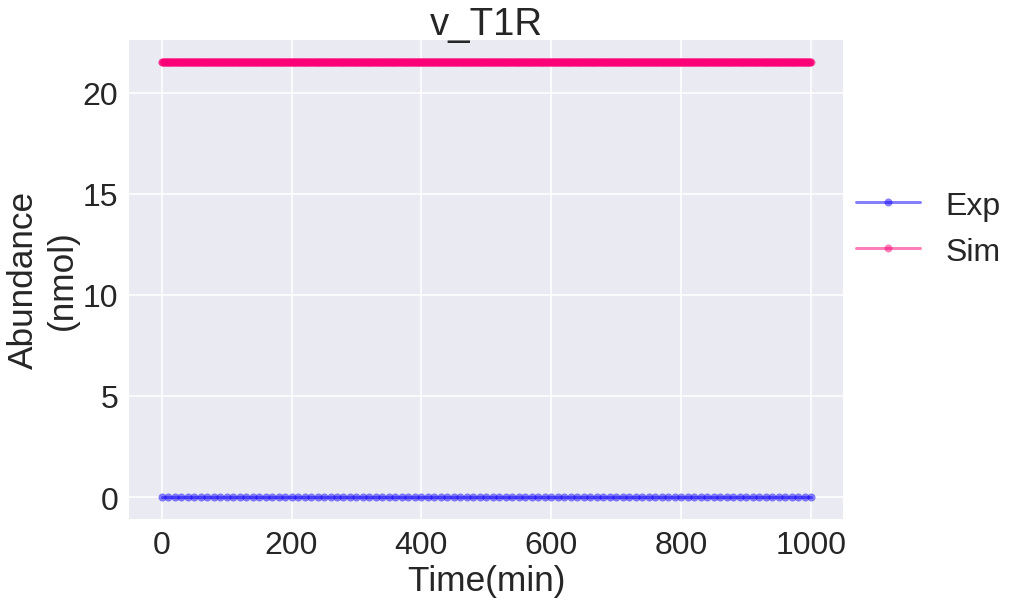

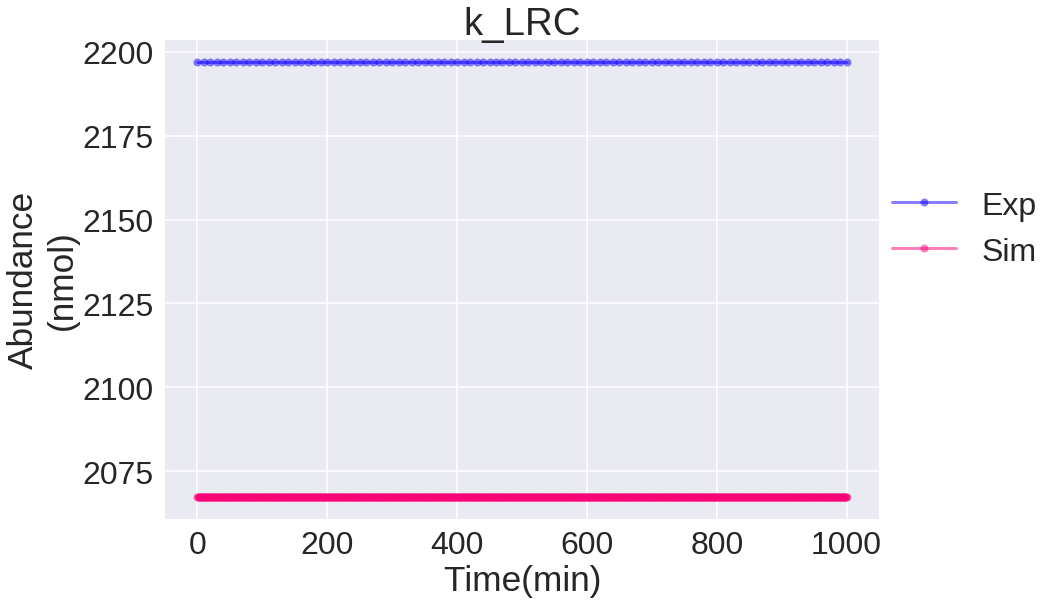

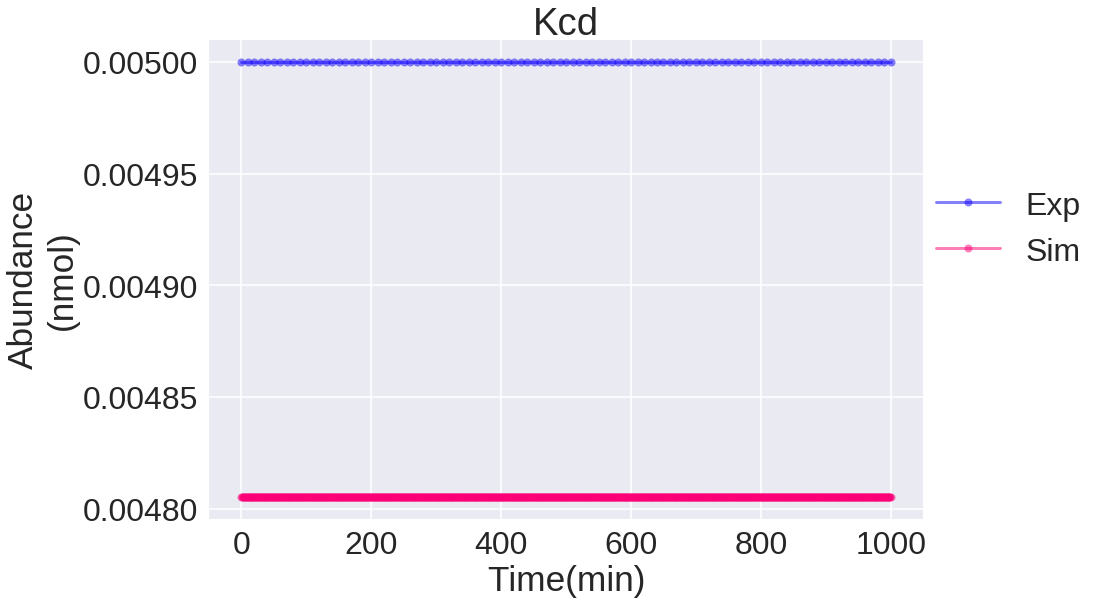

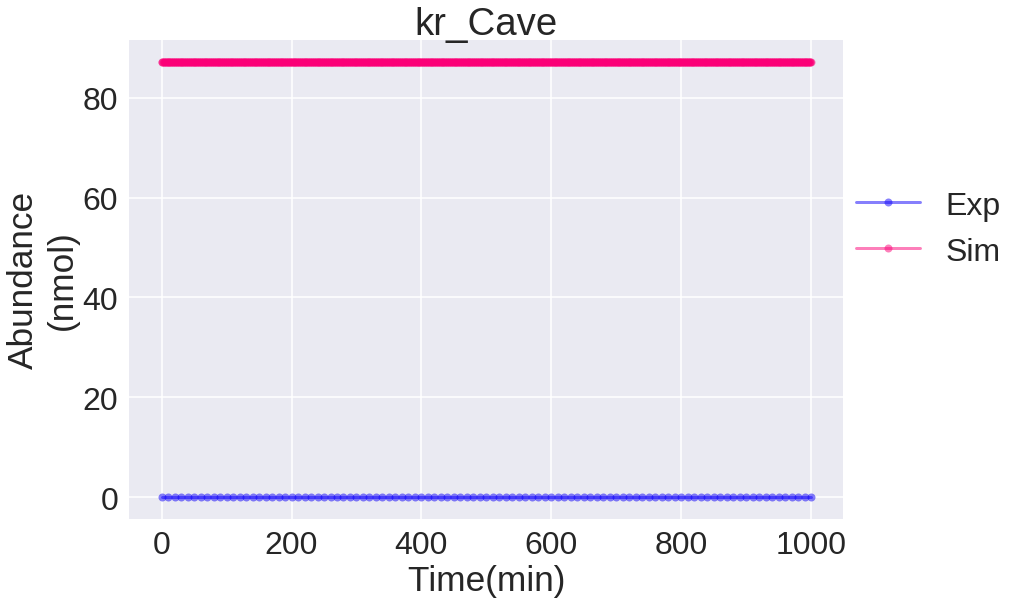

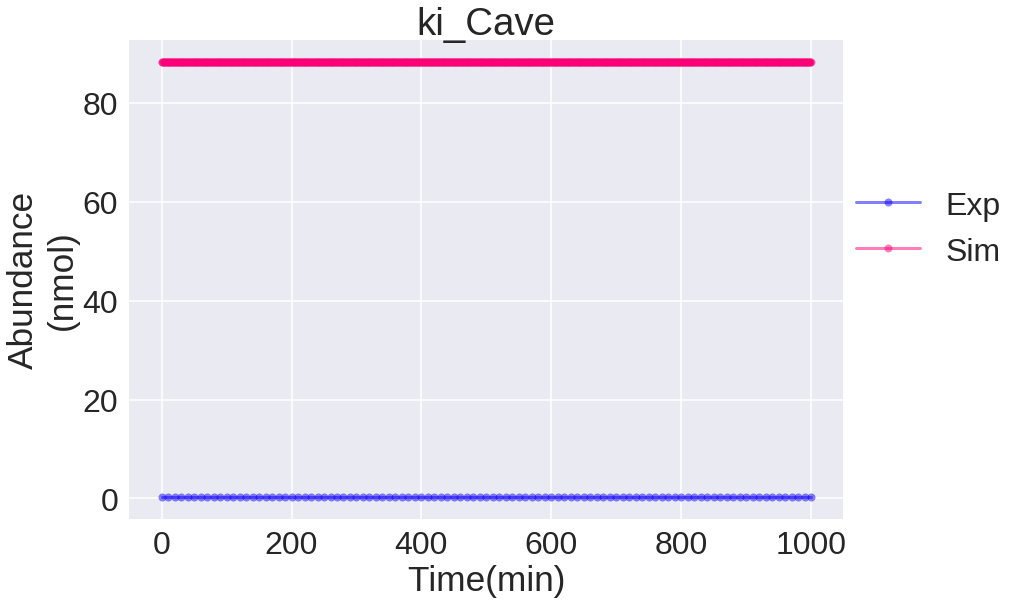

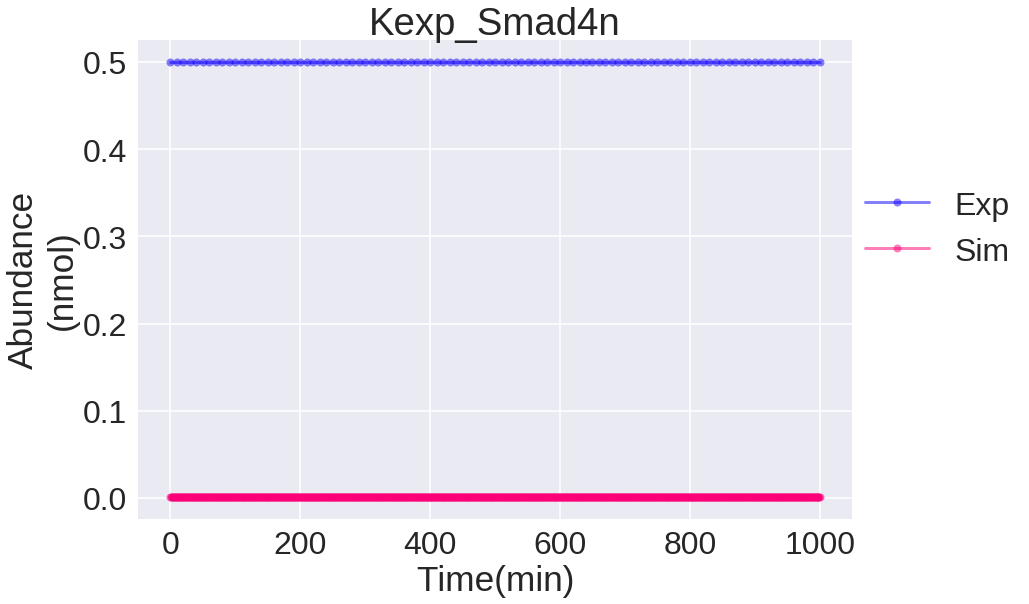

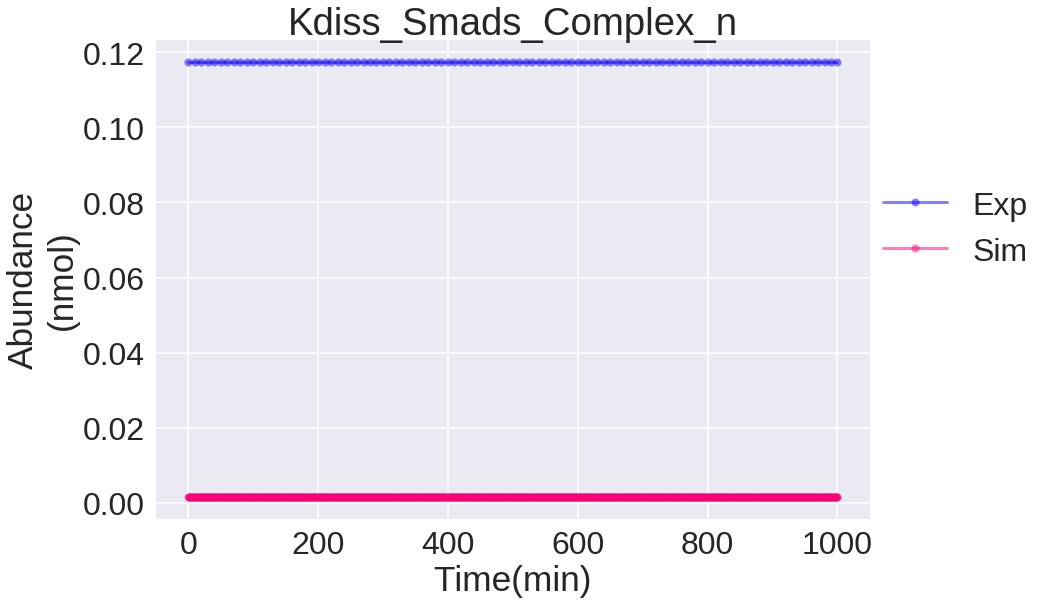

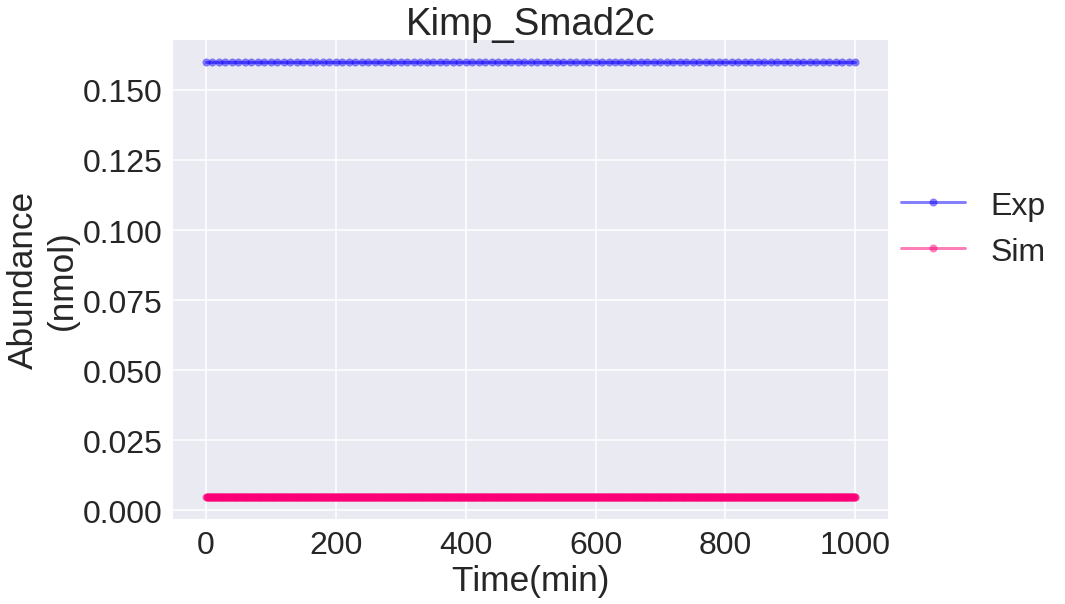

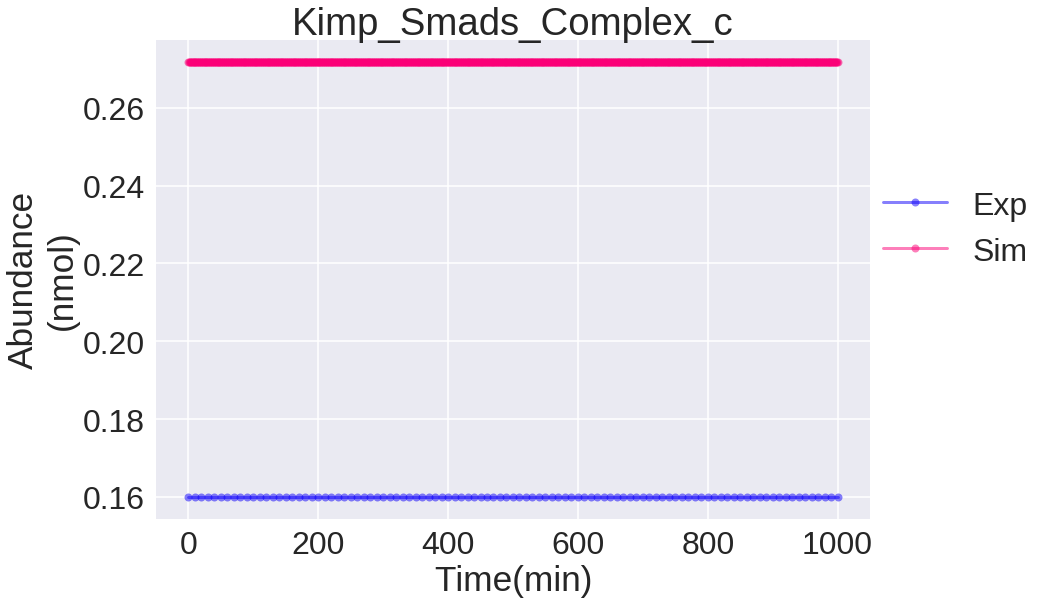

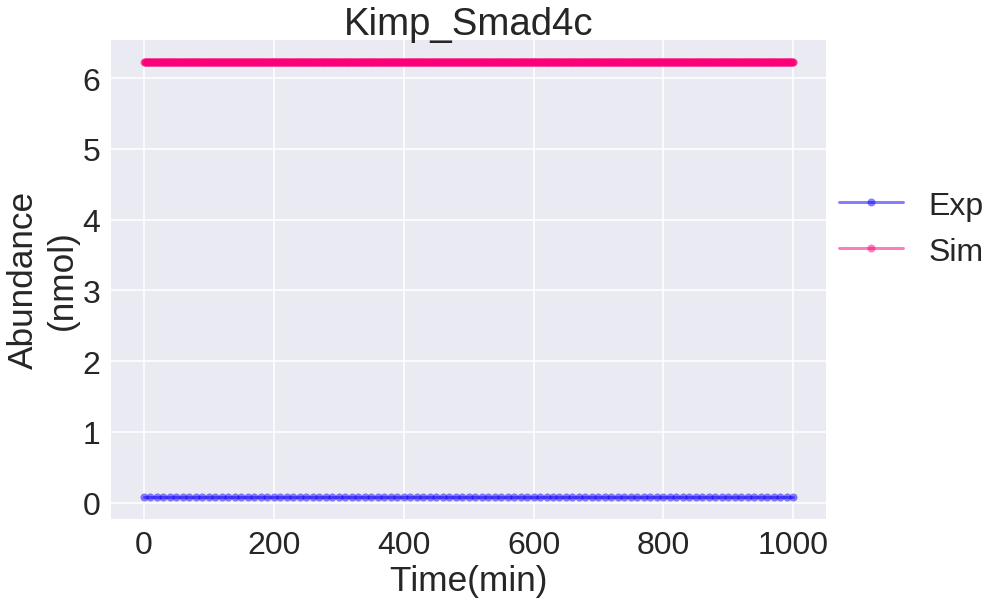

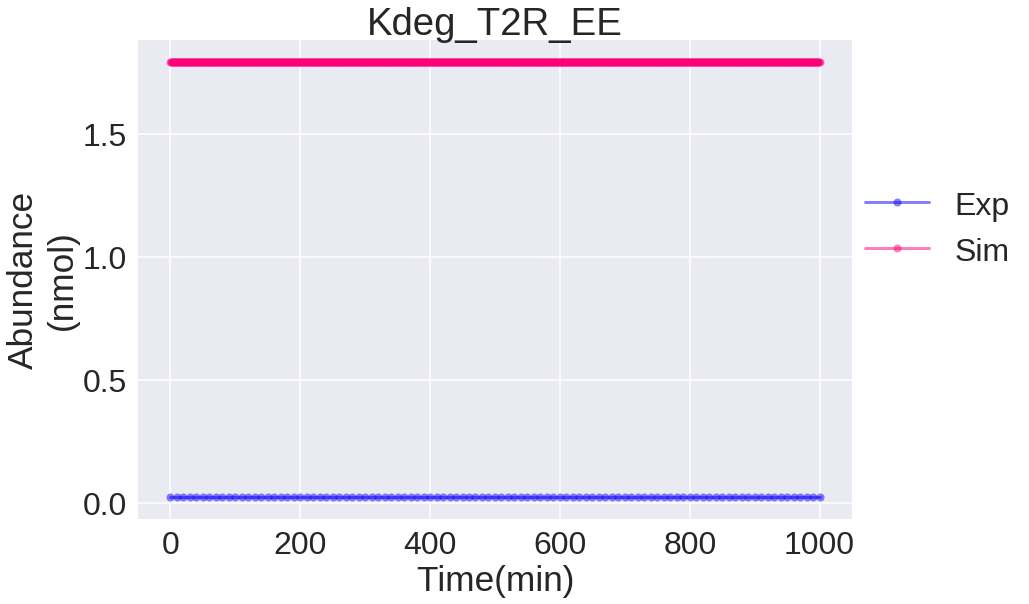

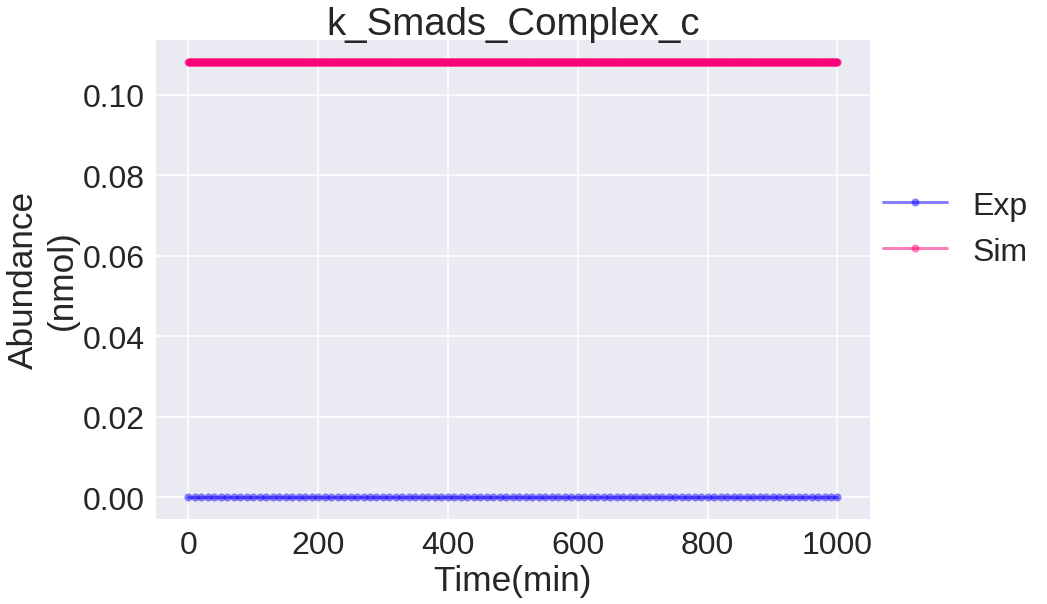

In [16]:
viz.PlotParameterEstimation(PE, savefig=True, results_directory='MyParameterEstimationResults')

## Select specific variables to plot

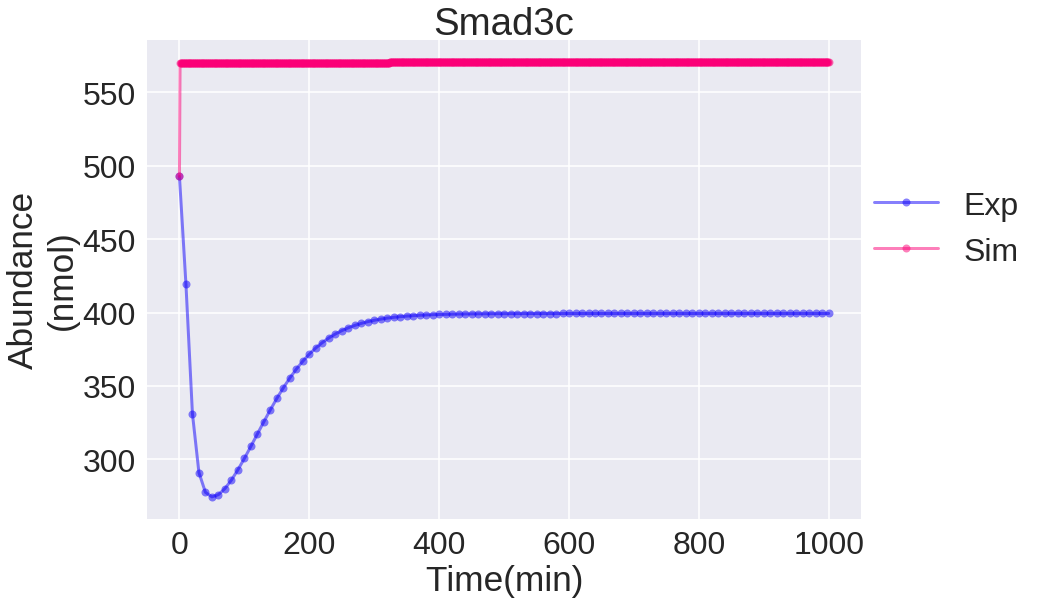

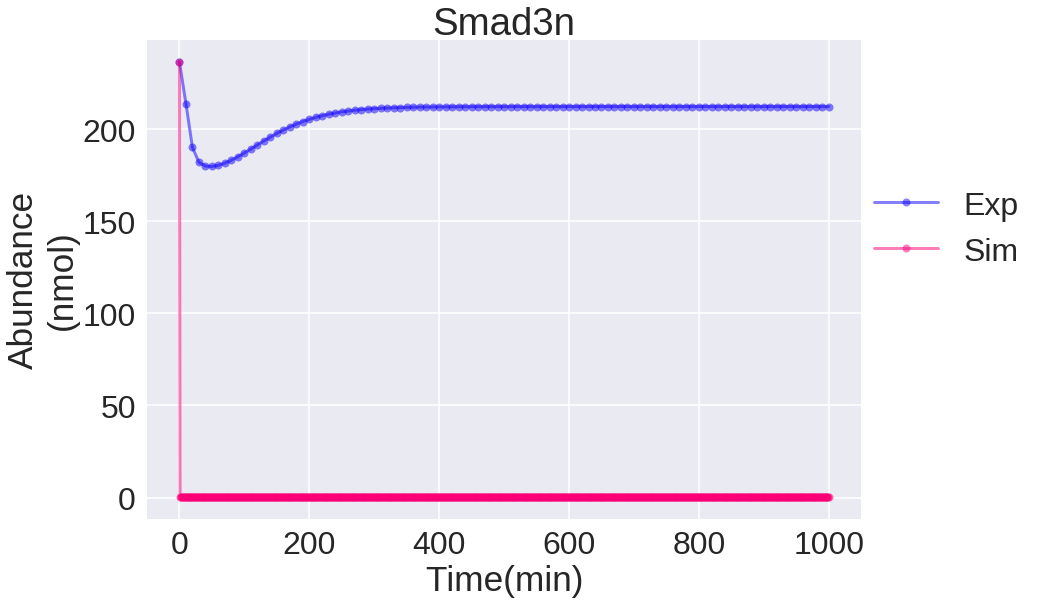

In [17]:
viz.PlotParameterEstimation(PE, y=['Smad3c', 'Smad3n'])

# Multiple Data Files
## Pre-requisites

### Change a parameter value  
Pycotools can easily handle multiple data files by giving `ParameterEsimation` a list of data file paths. Lets simulate some more data.

Lets first change a model parameter so both sets of simulated data are not identical:

In [18]:
## set metabolite Smad3c concentration to 150 (original is 492.61)
zi.set('metabolite', 'Smad3c', 150, match_field='name', change_field='concentration')

## Uncomment to manually check the model to ensure Smad3c initial conc. is 150
#zi.open()

Model(name=Zi2007_TGFbeta_signaling, time_unit=min, volume_unit=l, quantity_unit=nmol)

### Simulate second time course

In [19]:
report= 'parameter_estimation_synthetic_data2.txt'
TC=tasks.TimeCourse(zi,end=1000, intervals=10, step_size=100,
                    report_name=report, plot=True)
    

## Give fake data a meaningful name
zi_data_file2 = TC.report_name

### Format the second synthetic time course data
Again, we can use the `misc.correct_copasi_timecourse_headers` function as a convenient way to properly formatting copasi time course data for parameter estimation. 

In [20]:
misc.correct_copasi_timecourse_headers(zi_data_file2)

Time      Smad3n   Smad3c   Smad4n       Smad4c  T1R_Surf  T2R_Cave  \
0      0  236.450000  150.000   551.72  1149.400000     0.237     1.778   
1    100    0.142994  228.029  3996.86     0.278852  1004.500   807.424   
2    200    0.143036  228.131  3997.17     0.278862  1988.150  1591.260   
3    300    0.143069  228.212  3997.41     0.278868  2917.780  2318.480   
4    400    0.143095  228.274  3997.60     0.278872  3796.420  2993.170   
5    500    0.143114  228.322  3997.74     0.278873  4626.930  3619.120   
6    600    0.143129  228.358  3997.85     0.278872  5412.000  4199.850   
7    700    0.143139  228.383  3997.93     0.278869  6154.180  4738.640   
8    800    0.143146  228.400  3997.98     0.278866  6855.850  5238.510   
9    900    0.143150  228.411  3998.01     0.278861  7519.270  5702.270   
10  1000    0.143153  228.416  3998.03     0.278856  8146.580  6132.530   

    T2R_Surf  Smads_Complex_n    T1R_EE     ...       kr_Cave       Kcd  \
0      0.202          0.00000   2.06000     ...       87.1482  0.004805   
1    797.743          2.22028   3.30325     ...       87.1482  0.004805   
2   1572.090          1.91218   6.61653     ...       87.1482  0.004805   
3   2290.490          1.66938   9.74784     ...       87.1482  0.004805   
4   2957.010          1.48070  12.70740     ...       87.1482  0.004805   
5   3575.380          1.33675  15.50480     ...       87.1482  0.004805   
6   4149.080          1.22963  18.14920     ...       87.1482  0.004805   
7   4681.340          1.15271  20.64910     ...       87.1482  0.004805   
8   5175.150          1.10042  23.01250     ...       87.1482  0.004805   
9   5633.290          1.06810  25.24720     ...       87.1482  0.004805   
10  6058.340          1.05183  27.36010     ...       87.1482  0.004805   

    Kexp_Smad4n  k_Smads_Complex_c  Kimp_Smad2c  Kdiss_Smads_Complex_n  \
0      0.001304           0.108151     0.004747               0.001639   
1      0.001304           0.108151     0.004747               0.001639   
2      0.001304           0.108151     0.004747               0.001639   
3      0.001304           0.108151     0.004747               0.001639   
4      0.001304           0.108151     0.004747               0.001639   
5      0.001304           0.108151     0.004747               0.001639   
6      0.001304           0.108151     0.004747               0.001639   
7      0.001304           0.108151     0.004747               0.001639   
8      0.001304           0.108151     0.004747               0.001639   
9      0.001304           0.108151     0.004747               0.001639   
10     0.001304           0.108151     0.004747               0.001639   

    Kimp_Smad4c  Kimp_Smads_Complex_c  ki_Cave  Kdeg_T2R_EE  
0       6.23059              0.271784   88.216      1.79169  
1       6.23059              0.271784   88.216      1.79169  
2       6.23059              0.271784   88.216      1.79169  
3       6.23059              0.271784   88.216      1.79169  
4       6.23059              0.271784   88.216      1.79169  
5       6.23059              0.271784   88.216      1.79169  
6       6.23059              0.271784   88.216      1.79169  
7       6.23059              0.271784   88.216      1.79169  
8       6.23059              0.271784   88.216      1.79169  
9       6.23059              0.271784   88.216      1.79169  
10      6.23059              0.271784   88.216      1.79169  

[11 rows x 37 columns]

### Add independent variable
We are now setting up a parameter estimation where the Smad3c metabolite contains two separate initial conditions. These are handled by Copasi using independent variables ([see docs](http://copasi.org/Support/User_Manual/Tasks/Parameter_Estimation/)). 

In [21]:
def add_independent_variable(data_file, indep_var, value):
    """
    
    :param data_file: str. Path to pre-formatted time course data
    :param indep_var: str. Variable to add independent var for
    :param value: (int, float). Amount to set as independent
    :return: pandas.DataFrame. With independent variable as new column
    """
    ## read the data file into pandas
    df = pandas.read_csv(data_file, sep='\t', index_col=0)
    
    ## validate user input
    if indep_var not in list(df.columns):
        raise Exception
        
    ## ensure we don't add a indep_var twice
    if indep_var+'_indep' in list(df.columns):
        return df
    
    ## add independent variable column
    ## Append '_indep' to variable name to tell pycotools that its independent
    df[indep_var+'_indep'] = value
    
#     ## remove original data file
#     if os.path.isfile(data_file):
#         os.remove(data_file)
    
    
    ## write data file with indep value 
#     df.to_csv(data_file[:-4]+'_2.txt', sep='\t', index=True)
    df.to_csv(data_file, sep='\t', index=True)
    return df

## add independent variable to first set of synthetic data
add_independent_variable(zi_data_file, 'Smad3c', 492.61)

## add independent variable to first set of synthetic data
add_independent_variable(zi_data_file2, 'Smad3c', 150)

Smad3n   Smad3c   Smad4n       Smad4c  T1R_Surf  T2R_Cave  T2R_Surf  \
Time                                                                            
0     236.450000  150.000   551.72  1149.400000     0.237     1.778     0.202   
100     0.142994  228.029  3996.86     0.278852  1004.500   807.424   797.743   
200     0.143036  228.131  3997.17     0.278862  1988.150  1591.260  1572.090   
300     0.143069  228.212  3997.41     0.278868  2917.780  2318.480  2290.490   
400     0.143095  228.274  3997.60     0.278872  3796.420  2993.170  2957.010   
500     0.143114  228.322  3997.74     0.278873  4626.930  3619.120  3575.380   
600     0.143129  228.358  3997.85     0.278872  5412.000  4199.850  4149.080   
700     0.143139  228.383  3997.93     0.278869  6154.180  4738.640  4681.340   
800     0.143146  228.400  3997.98     0.278866  6855.850  5238.510  5175.150   
900     0.143150  228.411  3998.01     0.278861  7519.270  5702.270  5633.290   
1000    0.143153  228.416  3998.03     0.278856  8146.580  6132.530  6058.340   

      Smads_Complex_n    T1R_EE  T1R_Cave      ...            Kcd  \
Time                                           ...                  
0             0.00000   2.06000     2.092      ...       0.004805   
100           2.22028   3.30325  1016.690      ...       0.004805   
200           1.91218   6.61653  2012.400      ...       0.004805   
300           1.66938   9.74784  2953.420      ...       0.004805   
400           1.48070  12.70740  3842.840      ...       0.004805   
500           1.33675  15.50480  4683.530      ...       0.004805   
600           1.22963  18.14920  5478.220      ...       0.004805   
700           1.15271  20.64910  6229.500      ...       0.004805   
800           1.10042  23.01250  6939.770      ...       0.004805   
900           1.06810  25.24720  7611.330      ...       0.004805   
1000          1.05183  27.36010  8246.320      ...       0.004805   

      Kexp_Smad4n  k_Smads_Complex_c  Kimp_Smad2c  Kdiss_Smads_Complex_n  \
Time                                                                       
0        0.001304           0.108151     0.004747               0.001639   
100      0.001304           0.108151     0.004747               0.001639   
200      0.001304           0.108151     0.004747               0.001639   
300      0.001304           0.108151     0.004747               0.001639   
400      0.001304           0.108151     0.004747               0.001639   
500      0.001304           0.108151     0.004747               0.001639   
600      0.001304           0.108151     0.004747               0.001639   
700      0.001304           0.108151     0.004747               0.001639   
800      0.001304           0.108151     0.004747               0.001639   
900      0.001304           0.108151     0.004747               0.001639   
1000     0.001304           0.108151     0.004747               0.001639   

      Kimp_Smad4c  Kimp_Smads_Complex_c  ki_Cave  Kdeg_T2R_EE  Smad3c_indep  
Time                                                                         
0         6.23059              0.271784   88.216      1.79169           150  
100       6.23059              0.271784   88.216      1.79169           150  
200       6.23059              0.271784   88.216      1.79169           150  
300       6.23059              0.271784   88.216      1.79169           150  
400       6.23059              0.271784   88.216      1.79169           150  
500       6.23059              0.271784   88.216      1.79169           150  
600       6.23059              0.271784   88.216      1.79169           150  
700       6.23059              0.271784   88.216      1.79169           150  
800       6.23059              0.271784   88.216      1.79169           150  
900       6.23059              0.271784   88.216      1.79169           150  
1000      6.23059              0.271784   88.216      1.79169           150  

[11 rows x 37 columns]

## Setup parameter estimation with two data files
Pycotools can handle an arbitrary number of parameter estimation files at a time by passing a list of properly configured COPASI data files rather than a single string. 

Here we setup a parameter estimation to estimate all global variables using the two data files which were simulated from the model but with different starting values of Smad3c

In [22]:
config_file2 = os.path.join(os.path.dirname(zi_path), 'zi_config_file2.xlsx')
PE=tasks.ParameterEstimation(
    zi,[zi_data_file, zi_data_file2], method='genetic_algorithm',
    population_size=5, number_of_generations=20,
    metabolites=[], local_parameters=[], lower_bound=0.1, 
    upper_bound=100, config_filename=config_file2)
PE.write_config_file()
PE.setup()

Model(name=Zi2007_TGFbeta_signaling, time_unit=min, volume_unit=l, quantity_unit=nmol)

## Run parameter estimation with two data files

In [23]:
PE.run()

# Visualization 
The same arguments apply as when plotting parameter estimation from a single data file

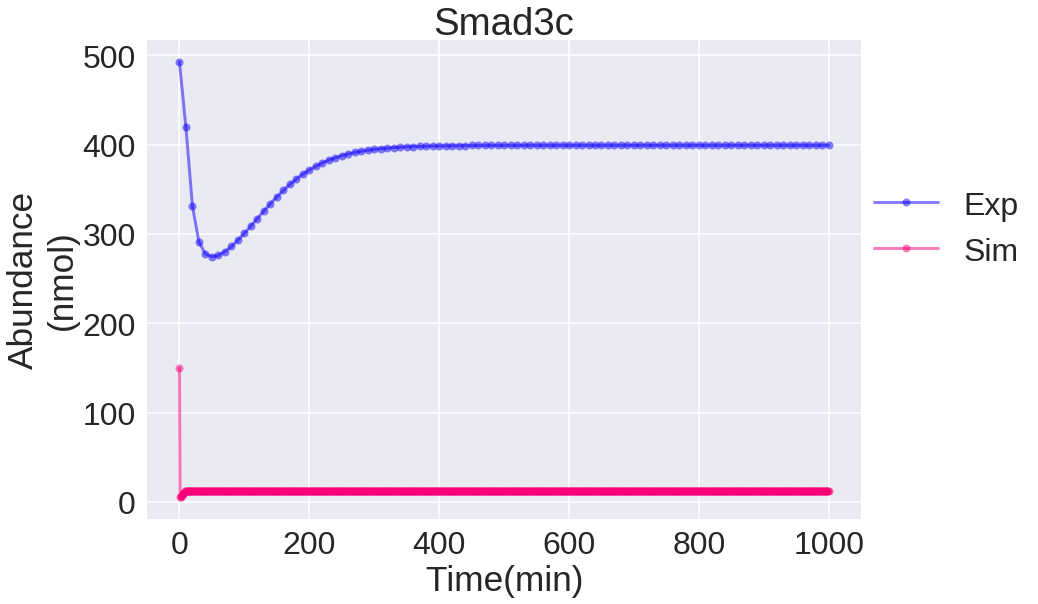

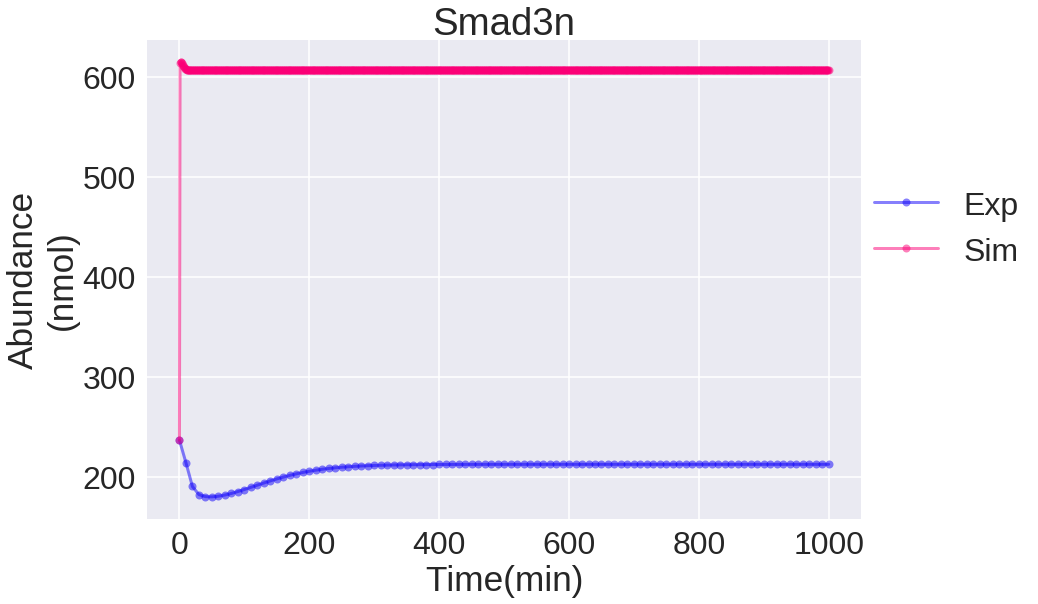

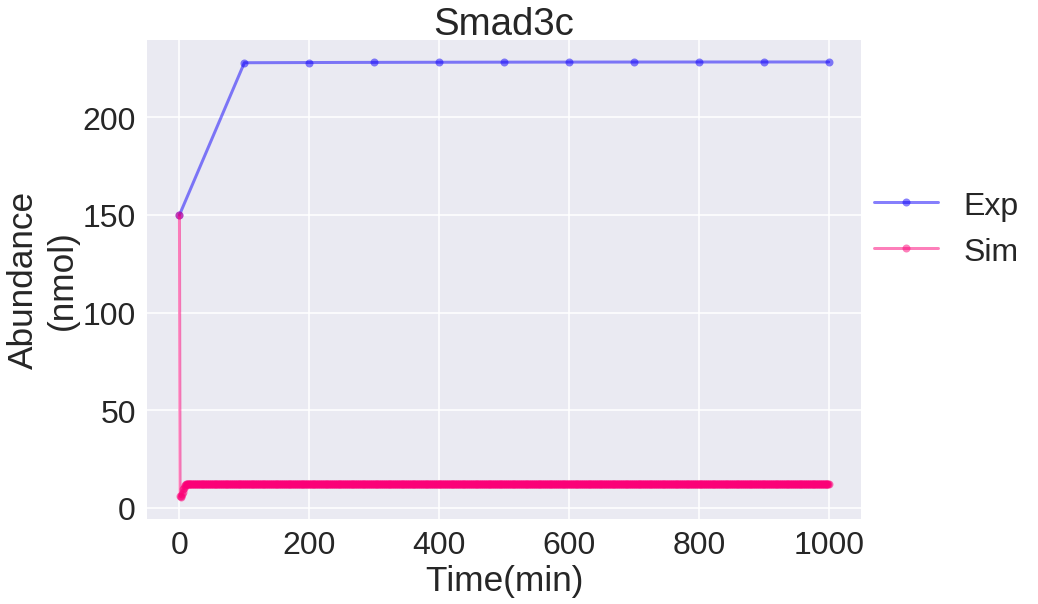

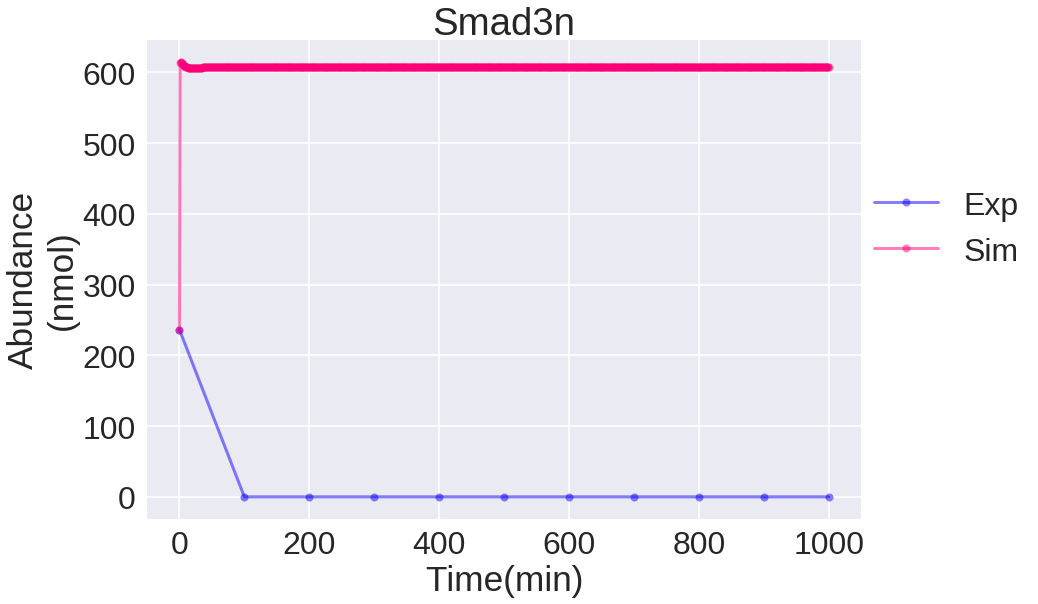

In [24]:
viz.PlotParameterEstimation(PE, y=['Smad3c', 'Smad3n'])

## Steady State data
By default, all data files are timecourse. To specify timecourse data we need to add a few more arguments to the ParameterEstimation instantiation - namely the experiment type argument. 

### Create fake steady state data

In [25]:
steady_state_data_file = os.path.join(os.path.dirname(zi_path), 'steady_state_data')
df = pandas.DataFrame([400], columns=['Smad3c'])
df.to_csv(steady_state_data_file, index=False)

## Setup parameter estimation with steady state

In [26]:
config_file = os.path.join(os.path.dirname(zi_path), 'Zi2002PEConfig3.csv')
PE = tasks.ParameterEstimation(
    zi, [zi_data_file, steady_state_data_file],
    experiment_type=['timecourse', 'steadystate'],
    weight_method=['mean_squared', 'mean_squared'],
    method='genetic_algorithm', population_size=15,
    number_of_generations=10, metabolites=[], local_parameters=[],
    lower_bound = 0.001, upper_bound = 3000, config_filename = config_file
)
PE.write_config_file()
PE.setup()

Model(name=Zi2007_TGFbeta_signaling, time_unit=min, volume_unit=l, quantity_unit=nmol)

Running and visualization are now the same as above. 